<a href="https://colab.research.google.com/github/Yukseltt/mr_analyze/blob/main/mr_analyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **BEYIN TÜMÖRÜ TESPİTİ PROJESİ**
Yapay Zeka Dönem Ödevi - Derin Öğrenme ile Tıbbi Görüntü Sınıflandırma

Bu proje, beyin MR görüntülerinde tümör tespiti yapmak için
10+ derin öğrenme modeli kullanmaktadır.

In [1]:
# KÜTÜPHANE İMPORT İŞLEMLERİ
# LIBRARY IMPORT OPERATIONS
import tensorflow as tf
import albumentations as A
from tensorflow.keras.applications import (MobileNetV2, ResNet50, VGG16,
                                           InceptionV3, EfficientNetB0,
                                           DenseNet121, Xception)
from tensorflow.keras import layers, models, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization, GlobalAveragePooling2D,
                                     Add, Multiply, Concatenate)

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, cohen_kappa_score)
import os
import warnings
warnings.filterwarnings('ignore')

import time

# MODEL METRİKLERİ LİSTESİ
# MODEL METRICS LIST
all_model_metrics = []

# ŞEMA GÖRSEL AYARLARI
# CHART VISUAL SETTINGS
sns.set_style('whitegrid')
sns.set_palette('dark')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# VERİ YÜKLEME VE GOOGLE DRIVE BAĞLANTISI YAPILMASI
# DATA LOADING AND GOOGLE DRIVE CONNECTION
from google.colab import drive
drive.mount('/content/drive')

# TRAIN VE TEST VERİLERİNİN KONUMLARI
# LOCATIONS OF TRAIN AND TEST DATA
train_dir = '/content/drive/MyDrive/mr_dataset_save/Training'
test_dir = '/content/drive/MyDrive/mr_dataset_save/Testing'

# SABİT PARAMETRELER
# CONSTANT PARAMETERS
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
RANDOM_SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Mounted at /content/drive


VERİ SETİ KEŞİFSEL ANALİZİ (EDA)
DATASET EXPLORATORY ANALYSIS (EDA)

Eğitim Seti:
  - Tümörlü Görüntü: 4117
  - Tümörsüz Görüntü: 4160
  - Toplam: 8277

Training Set:
  - Tumor Image: 4117
  - No Tumor Image: 4160
  - Total: 8277

Test Seti:
  - Tümörlü Görüntü: 906
  - Tümörsüz Görüntü: 910
  - Toplam: 1816

Test Set:
  - Tumor Image: 906
  - No Tumor Image: 910
  - Total: 1816


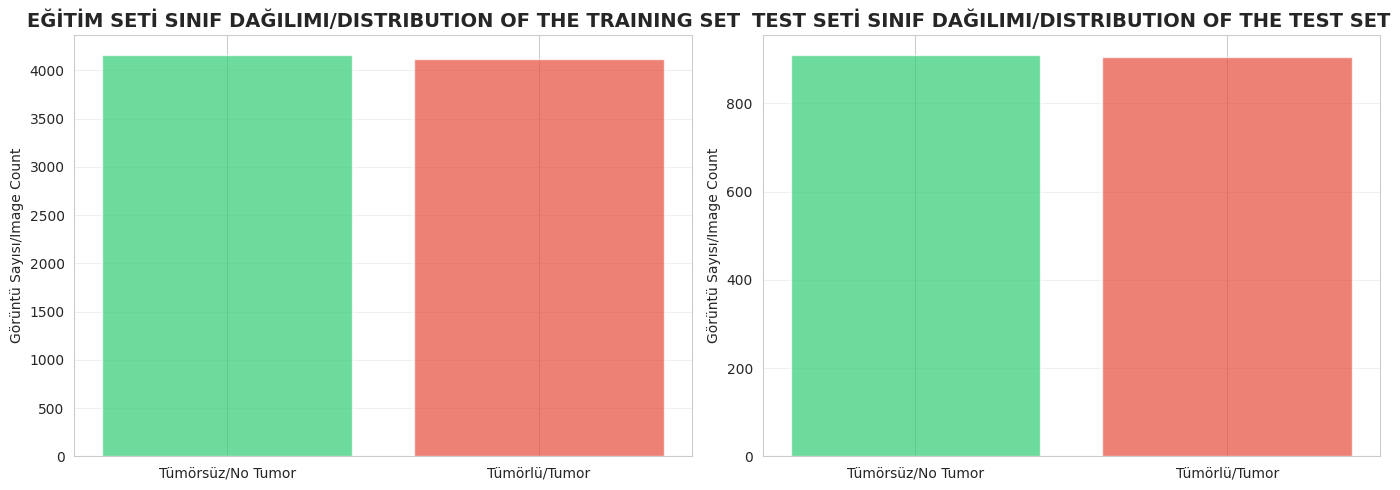

In [3]:
# KEŞİFSEL VERİ ANALİZİ (EDA)
# EXPLORATORY DATA ANALYSIS (EDA)
print("VERİ SETİ KEŞİFSEL ANALİZİ (EDA)")
print("DATASET EXPLORATORY ANALYSIS (EDA)")
print("=" * 80)

def count_images_in_folder(folder_path):
    """Klasördeki görüntü sayısı/Number of images in the folder:"""
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len([f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))])
    return count

# VERİ SETİNDEKİ GÖRSELLERİN İSTATİSTİKLERİ
# STATISTICS OF IMAGES IN THE DATASET
train_tumor = count_images_in_folder(os.path.join(train_dir, 'tumor'))
train_no_tumor = count_images_in_folder(os.path.join(train_dir, 'no tumor'))
test_tumor = count_images_in_folder(os.path.join(test_dir, 'tumor'))
test_no_tumor = count_images_in_folder(os.path.join(test_dir, 'no tumor'))

print(f"\nEğitim Seti:")
print(f"  - Tümörlü Görüntü: {train_tumor}")
print(f"  - Tümörsüz Görüntü: {train_no_tumor}")
print(f"  - Toplam: {train_tumor + train_no_tumor}")

print(f"\nTraining Set:")
print(f"  - Tumor Image: {train_tumor}")
print(f"  - No Tumor Image: {train_no_tumor}")
print(f"  - Total: {train_tumor + train_no_tumor}")

print(f"\nTest Seti:")
print(f"  - Tümörlü Görüntü: {test_tumor}")
print(f"  - Tümörsüz Görüntü: {test_no_tumor}")
print(f"  - Toplam: {test_tumor + test_no_tumor}")

print(f"\nTest Set:")
print(f"  - Tumor Image: {test_tumor}")
print(f"  - No Tumor Image: {test_no_tumor}")
print(f"  - Total: {test_tumor + test_no_tumor}")

# SINIF DAĞILIMLARININ GÖRSEL GRAFİKLERİNİN ÇİZİLMESİ
# PLOTTING VISUAL GRAPHS OF CLASS DISTRIBUTIONS
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# EĞİTİM SETİNİN VERİLERİNİN DAĞILIMI
# DATA DISTRIBUTION OF THE TRAINING SET
axes[0].bar(['Tümörsüz/No Tumor', 'Tümörlü/Tumor'], [train_no_tumor, train_tumor],
            color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[0].set_title('EĞİTİM SETİ SINIF DAĞILIMI/DISTRIBUTION OF THE TRAINING SET', fontsize=14, weight='bold')
axes[0].set_ylabel('Görüntü Sayısı/Image Count')
axes[0].grid(axis='y', alpha=0.3)

# TEST SETİNİN VERİLERİNİN DAĞILIMI
# DATA DISTRIBUTION OF THE TEST SET
axes[1].bar(['Tümörsüz/No Tumor', 'Tümörlü/Tumor'], [test_no_tumor, test_tumor],
            color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[1].set_title('TEST SETİ SINIF DAĞILIMI/DISTRIBUTION OF THE TEST SET', fontsize=14, weight='bold')
axes[1].set_ylabel('Görüntü Sayısı/Image Count')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('eda_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

VERİ AĞAÇLANDIRMA
DATA AUGMENTATION
Eğitim verisi yükleniyor...
Validasyon verisi yükleniyor...
Test verisi yükleniyor...
Loading training data...
Loading validation data...
Loading test data...
Found 8277 files belonging to 2 classes.
Using 6622 files for training.
Found 8277 files belonging to 2 classes.
Using 1655 files for validation.
Found 1816 files belonging to 2 classes.
Veri pipeline'ları oluşturuluyor...
Creating data pipelines...

Eğitim örnekleri: 6622
Validasyon örnekleri: 1655
Test örnekleri: 1816

Örnek görseller oluşturuluyor...

Training samples: 6622
Validation samples: 1655
Test samples: 1816

Generating sample images...


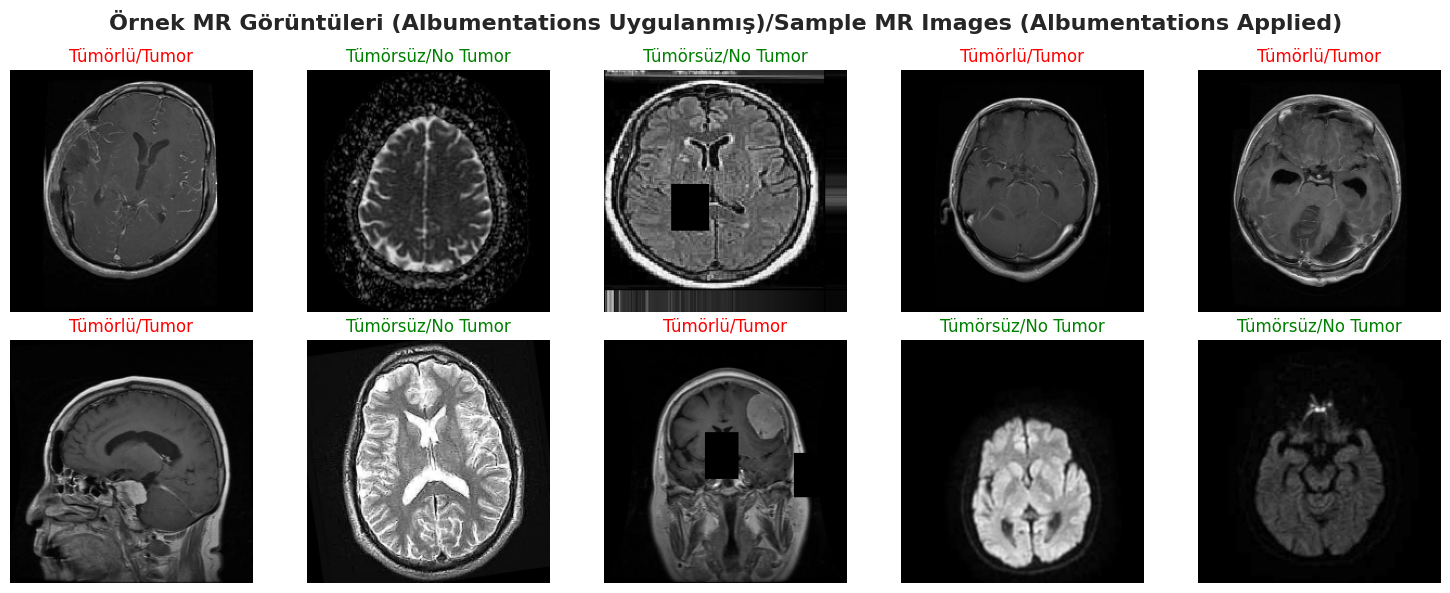

In [4]:
# VERİ AĞAÇLANDIRMA VE ÖN İŞLEME
# DATA AUGMENTATION AND PREPROCESSING
print("VERİ AĞAÇLANDIRMA")
print("DATA AUGMENTATION")
print("=" * 80)

train_transform = A.Compose([

    # GÖRÜNÜTÜYÜ -10 İLE +10 DERECE ARASINDA RASTGELE DÖNDÜRÜR. P=0.3 İLE BU İŞLEM %30 İHTİMAL İLE UYGULANIR.
    # RANDOMLY ROTATES THE IMAGE BETWEEN -10 AND +10 DEGREES. P=0.3 APPLIES THIS OPERATION WITH 30% PROBABILITY.
    A.Rotate(limit=10, p=0.3),

    # GÖRÜNTÜYÜ RASTGELE YATAY EKSENDE ÇEVİRİR. P=0.3 İLE BU İŞLEM %30 İHTİMAL İLE UYGULANIR.
    # DİKEY ÇEVİRME UYGULANMAMASININ SEBEBİ MR GÖRÜNTÜLERİNDE SONUÇLARIN YANILMASINA SEBEP OLABİLMESİDİR.
    # RANDOMLY FLIPS THE IMAGE HORIZONTALLY. P=0.3 APPLIES THIS OPERATION WITH 30% PROBABILITY.
    # VERTICAL FLIP IS NOT APPLIED BECAUSE IT CAN CAUSE MISLEADING RESULTS IN MR IMAGES.
    A.HorizontalFlip(p=0.3),

    # GÖRÜNTÜYÜ RASTGELE KAYDIRIR, DÖNDÜRÜR VE ÖLÇEKLER FAKAT BURADA DÖNDÜRME SIFIR ÇÜNKÜ DÖNDÜRME ZATEN UYGULANDI.
    # SHİFT_LİMİT=0.1 İLE GÖRÜNTÜ YATAY VE DİKEYDE EN FAZLA %10 KAYDIRILIR.
    # SCALE_LİMİT=0.1 İLE GÖRÜNTÜ EN FAZLA %10 BÜYÜR YA DA KÜÇÜLÜR.
    # P=0.3 İLE BU İŞLEM %30 İHTİMAL İLE UYGULANIR.
    # BU ŞEKİLDE HASTANIN MR ÇEKİLİRKEN YAPABİLECEĞİ HAREKETLER SİMÜLE EDİLMEYE ÇALIŞILIR.
    # RANDOMLY SHIFTS, ROTATES, AND SCALES THE IMAGE, BUT ROTATION IS ZERO HERE BECAUSE ROTATION WAS ALREADY APPLIED.
    # WITH SHİFT_LİMİT=0.1, THE IMAGE IS SHIFTED HORIZONTALLY AND VERTICALLY BY AT MOST 10%.
    # WITH SCALE_LİMİT=0.1, THE IMAGE IS SCALED (ZOOMED IN OR OUT) BY AT MOST 10%.
    # P=0.3 APPLIES THIS OPERATION WITH 30% PROBABILITY.
    # THIS ATTEMPTS TO SIMULATE MOVEMENTS A PATIENT MIGHT MAKE DURING AN MR SCAN.
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.3),

    # GÖRÜNTÜNÜN PARLAKLIĞINI DOĞRUSAL OLMAYAN BİR ŞEKİLDE DEĞİŞTİRİR.
    # GAMMA_LİMİT=(80,120) İLE GAMMA DEĞERİ 0.8 İLE 1.2 ARASINDA SEÇİLİR.
    # P=0.3 İLE BU İŞLEM %30 İHTİMAL İLE UYGULANIR.
    # NON-LINEARLY CHANGES THE BRIGHTNESS OF THE IMAGE.
    # WITH GAMMA_LİMİT=(80,120), THE GAMMA VALUE IS SELECTED BETWEEN 0.8 AND 1.2.
    # P=0.3 APPLIES THIS OPERATION WITH 30% PROBABILITY.
    A.RandomGamma(gamma_limit=(80,120), p=0.3),

    # GÖRÜNTÜ ÜZERİNDE BİR IZGARA (GRİD) OLUŞTURUR VE BU IZGARA NOKTALARINI RASTGELE KAYDIRIR.
    # BU, GÖRÜNTÜLERDE HAFİF, GERÇEKÇİ BÜKÜLMELERE VE BOZULMALARA NEDEN OLUR.
    # NUM_STEPS=50: IZGARANIN NE KADAR DETAYLI OLACAĞINI BELİRLER.
    # DİSTORT_LİMİT=0.04: BOZULMANIN (KAYMANIN) MAKSİMUM MİKTARINI BELİRLER.
    # P=0.1: BU İŞLEMİN UYGULANMA OLASILIĞI %10'DUR.
    # CREATES A GRID ON THE IMAGE AND RANDOMLY SHIFTS THE GRID POINTS.
    # THIS CAUSES SLIGHT, REALISTIC WARPING AND DISTORTIONS IN THE IMAGES.
    # NUM_STEPS=50: DETERMINES HOW DETAILED THE GRID WILL BE.
    # DİSTORT_LİMİT=0.04: DETERMINES THE MAXIMUM AMOUNT OF DISTORTION (SHIFT).
    # P=0.1: THE PROBABILITY OF THIS OPERATION BEING APPLIED IS 10%.
    A.GridDistortion(num_steps=50, distort_limit=0.04, p=0.1),

    # 'CUTOUT' OLARAK DA BİLİNİR. MODELİN EZBERLEMESİNİ ÖNLEMEK İÇİN GÖRÜNTÜ ÜZERİNE
    # RASTGELE KÜÇÜK SİYAH KARELER (BOŞLUKLAR) YERLEŞTİRİR.
    # MAX_HOLES=8: EN FAZLA 8 ADET BOŞLUK EKLER.
    # MAX_HEİGHT=16, MAX_WİDTH=16: BİR BOŞLUĞUN BOYUTU EN FAZLA 16X16 PİKSEL OLABİLİR.
    # MİN_HEİGHT=8, MİN_WİDTH=8: BİR BOŞLUĞUN BOYUTU EN AZ 8X8 PİKSEL OLABİLİR.
    # P=0.3: BU İŞLEMİN UYGULANMA OLASILIĞI %30'DUR.
    # ALSO KNOWN AS 'CUTOUT'. TO PREVENT THE MODEL FROM MEMORIZING, IT PLACES
    # RANDOM SMALL BLACK SQUARES (HOLES) ON THE IMAGE.
    # MAX_HOLES=8: ADDS A MAXIMUM OF 8 HOLES.
    # MAX_HEİGHT=16, MAX_WİDTH=16: A HOLE'S SIZE CAN BE AT MOST 16X16 PIXELS.
    # MİN_HEİGHT=8, MİN_WİDTH=8: A HOLE'S SIZE CAN BE AT LEAST 8X8 PIXELS.
    # P=0.3: THE PROBABILITY OF THIS OPERATION BEING APPLIED IS 30%.
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16,
                min_holes=1, min_height=8, min_width=8, p=0.3),

    # GÖRÜNTÜ PİKSEL DEĞERLERİNİ NORMALİZE EDER (STANDARTLAŞTIRIR).
    # BU ADIM, MODEL EĞİTİMİNİN KARARLI OLMASI İÇİN HER ZAMAN EN SONDA OLMALIDIR.
    # MEAN=(0.0,), STD=(1.0,): GRİ TONLAMALI (TEK KANAL) GÖRÜNTÜ İÇİN ORTALAMAYI 0, STANDART SAPMAYI 1 YAPAR.
    # MAX_PİXEL_VALUE=255.0: GİRDİ PİKSELLERİNİN (0-255 ARALIĞINDA) 0-1 ARALIĞINA ÖLÇEKLENMESİNİ SAĞLAR.
    # NORMALIZES (STANDARDIZES) THE IMAGE PIXEL VALUES.
    # THIS STEP MUST ALWAYS BE LAST FOR STABLE MODEL TRAINING.
    # MEAN=(0.0,), STD=(1.0,): SETS THE MEAN TO 0 AND STANDARD DEVIATION TO 1 FOR A GRAYSCALE (SINGLE CHANNEL) IMAGE.
    # MAX_PİXEL_VALUE=255.0: ENSURES INPUT PIXELS (IN THE 0-255 RANGE) ARE SCALED TO THE 0-1 RANGE.
    A.Normalize(mean=(0.0,), std=(1.0,), max_pixel_value=255.0),
])


# TEST VE VALİDASYON SETİ İÇİN SADECE NORMALİZASYON
# ONLY NORMALIZATION FOR THE TEST AND VALIDATION SET
test_transform = A.Compose([
    A.Normalize(mean=(0.0,), std=(1.0,), max_pixel_value=255.0),
])


# 2. ALBUMENTATİONS'I TENSORFLOW'A SARMALAYAN (WRAPPER) FONKSİYONLAR
# (BU BÖLÜMDE DEĞİŞİKLİK YOK)
# 2. WRAPPER FUNCTIONS FOR ALBUMENTATIONS IN TENSORFLOW
# (NO CHANGES IN THIS SECTION)
def aug_albumentations(image):
    """Görüntüyü numpy'a çevirir, aug uygular ve float32'ye döner./Converts the image to numpy, applies aug, and returns as float32."""
    aug_image = train_transform(image=image)['image']
    return aug_image.astype(np.float32)

def norm_albumentations(image):
    """Görüntüyü numpy'a çevirir, normalizasyon uygular ve float32'ye döner./Converts the image to numpy, applies normalization, and returns as float32."""
    aug_image = test_transform(image=image)['image']
    return aug_image.astype(np.float32)

def apply_aug(image, label):
    """tf.numpy_function kullanarak eğitim aug fonksiyonunu çalıştırır./Runs the training aug function using tf.numpy_function."""
    aug_img = tf.numpy_function(func=aug_albumentations, inp=[image], Tout=tf.float32)
    aug_img.set_shape([IMG_SIZE[0], IMG_SIZE[1], 1])
    return aug_img, label

def apply_norm(image, label):
    """tf.numpy_function kullanarak test/val norm fonksiyonunu çalıştırır./Runs the test/val norm function using tf.numpy_function."""
    norm_img = tf.numpy_function(func=norm_albumentations, inp=[image], Tout=tf.float32)
    norm_img.set_shape([IMG_SIZE[0], IMG_SIZE[1], 1])
    return norm_img, label


# 3. TF.DATA PİPELİNE'INI OLUŞTUR
# 3. CREATE THE TF.DATA PIPELINE
print("Eğitim verisi yükleniyor...")
print("Validasyon verisi yükleniyor...")
print("Test verisi yükleniyor...")
print("Loading training data...")
print("Loading validation data...")
print("Loading test data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=None,
    class_names=['no tumor', 'tumor'],
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=None,
    # <--- GÜNCELLEME: KLASÖR ADLARI 'NO TUMOR' (ETİKET 0) VE 'TUMOR' (ETİKET 1) OLARAK GÜNCELLENDİ.
    # <--- UPDATE: FOLDER NAMES UPDATED TO 'NO TUMOR' (LABEL 0) AND 'TUMOR' (LABEL 1).
    class_names=['no tumor', 'tumor'],
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=None,
    # <--- GÜNCELLEME: KLASÖR ADLARI 'NO TUMOR' (ETİKET 0) VE 'TUMOR' (ETİKET 1) OLARAK GÜNCELLENDİ.
    # <--- UPDATE: FOLDER NAMES UPDATED TO 'NO TUMOR' (LABEL 0) AND 'TUMOR' (LABEL 1).
    class_names=['no tumor', 'tumor'],
    label_mode='binary',
    shuffle=False               # TEST VERİSİ ASLA KARIŞTIRILMAMALI
                                # TEST DATA SHOULD NEVER BE SHUFFLED
)

# 4. PİPELİNE'A AUGMENTATİON, BATCH VE PREFETCH ADIMLARINI UYGULA
# (BU BÖLÜMDE DEĞİŞİKLİK YOK)
# 4. APPLY AUGMENTATION, BATCH, AND PREFETCH STEPS TO THE PIPELINE
# (NO CHANGES IN THIS SECTION)
print("Veri pipeline'ları oluşturuluyor...")
print("Creating data pipelines...")
train_generator = (
    train_ds
    .shuffle(buffer_size=1000, seed=RANDOM_SEED)
    .map(apply_aug, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

val_generator = (
    val_ds
    .map(apply_norm, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

test_generator = (
    test_ds
    .map(apply_norm, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

# ÖRNEK SAYILARINI AL
# GET SAMPLE COUNTS
train_samples = len(train_ds)
val_samples = len(val_ds)
test_samples = len(test_ds)

print(f"\nEğitim örnekleri: {train_samples}")
print(f"Validasyon örnekleri: {val_samples}")
print(f"Test örnekleri: {test_samples}")
print("\nÖrnek görseller oluşturuluyor...")

print(f"\nTraining samples: {train_samples}")
print(f"Validation samples: {val_samples}")
print(f"Test samples: {test_samples}")
print("\nGenerating sample images...")

# ÖRNEK GÖRÜNTÜLERİ GÖSTERME (YENİ PİPELİNE'DAN)
# DISPLAYING SAMPLE IMAGES (FROM THE NEW PIPELINE)
plt.figure(figsize=(15, 6))
for images, labels in train_generator.take(1):
    for i in range(10):
        if i >= BATCH_SIZE: break
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].numpy().reshape(224, 224), cmap='gray')
        label_val = labels[i].numpy()

        # NOT: BURADAKİ MANTIK ('NO TUMOR' -> 0, 'TUMOR' -> 1 EŞLEŞMESİ)
        # YENİ CLASS_NAMES İLE HALA DOĞRU ÇALIŞMAKTADIR.
        # NOTE: THE LOGIC HERE ('NO TUMOR' -> 0, 'TUMOR' -> 1 MAPPING)
        # STILL WORKS CORRECTLY WITH THE NEW CLASS_NAMES.
        plt.title(f"{'Tümörlü/Tumor' if label_val > 0.5 else 'Tümörsüz/No Tumor'}",
                  color='red' if label_val > 0.5 else 'green')
        plt.axis('off')
plt.suptitle('Örnek MR Görüntüleri (Albumentations Uygulanmış)/Sample MR Images (Albumentations Applied)', fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('sample_images_albumentations.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# ==================== CALLBACK TANIMLAMALARI ====================

# Google Drive'da modelleri kaydedeceğimiz kalıcı yolu burada tanımlıyoruz
DRIVE_SAVE_PATH = '/content/drive/MyDrive/saved_models/'

# Bu klasörün var olduğundan emin olalım, yoksa oluşturalım
os.makedirs(DRIVE_SAVE_PATH, exist_ok=True)


def get_callbacks(model_name):
    """Her model için özelleştirilmiş callback'ler döndürür"""

    # Modelin kaydedileceği tam yolu oluşturuyoruz (Drive yolu + model adı)
    model_save_file = os.path.join(DRIVE_SAVE_PATH, f'best_model_{model_name}.h5')

    print(f"En iyi model şu yola kaydedilecek: {model_save_file}") # Bilgilendirme

    return [
        # Erken durdurma: Val_loss 5 epoch iyileşmezse dur
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        # Öğrenme hızı azaltma: Val_loss 3 epoch iyileşmezse LR'yi düşür
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        # En iyi modeli GÜNCELLENMİŞ YOLA (Google Drive'a) kaydet
        ModelCheckpoint(
            model_save_file,  # <-- ASIL DEĞİŞİKLİK BURADA
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            verbose=0
        )
    ]

In [6]:
# ==================== METRİK HESAPLAMA FONKSİYONLARI ====================

def calculate_metrics(y_true, y_pred_prob, model_name):
    """
    Model için tüm metrikleri hesaplar ve görselleştirir.
    (GÜNCELLENMİŞ tf.data UYUMLU FONKSİYON)
    Artık generator yerine doğrudan etiketleri (y_true) ve tahminleri (y_pred_prob) alır.
    """

    # Tahminleri 0.5 eşik değerine göre sınıflara ayır
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # y_true'nun da 1D dizi olduğundan emin ol
    y_true = y_true.flatten()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Metrikleri hesapla
    # ravel() -> [TN, FP, FN, TP]
    # Sağlam hata kontrolü: Eğer cm (2,2) değilse (örn: model her şeyi tek sınıf tahmin ettiyse)
    tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else (0, 0, 0, 0)

    # cm.ravel() 4 eleman döndürmezse diye ekstra kontrol
    if (tn + fp + fn + tp) == 0 and len(y_true) > 0:
        if y_true[0] == 0: # Sadece negatif sınıf varsa
            tn = len(y_true)
        else: # Sadece pozitif sınıf varsa
            tp = len(y_true)

    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    kappa = cohen_kappa_score(y_true, y_pred)

    # ROC eğrisi
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1-Score': f1_score,
        'Kappa': kappa,
        'AUC': roc_auc
    }

    # Sadece gerekli 3 değeri döndür
    return metrics, cm, (fpr, tpr, roc_auc)

def plot_model_results(history, metrics, cm, roc_data, model_name):
    """Model sonuçlarını görselleştirir"""

    fig = plt.figure(figsize=(18, 10))

    # 1. Accuracy grafiği
    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title(f'{model_name} - Accuracy', fontsize=12, weight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 2. Loss grafiği
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title(f'{model_name} - Loss', fontsize=12, weight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # 3. Confusion Matrix
    ax3 = plt.subplot(2, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['no tumor', 'tumor'],
                yticklabels=['no tumor', 'tumor'],
                ax=ax3, cbar_kws={'label': 'Sayı'})
    ax3.set_title(f'{model_name} - Confusion Matrix', fontsize=12, weight='bold')
    ax3.set_ylabel('Gerçek')
    ax3.set_xlabel('Tahmin')

    # 4. ROC Eğrisi
    ax4 = plt.subplot(2, 3, 4)
    fpr, tpr, roc_auc = roc_data
    ax4.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax4.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax4.set_title(f'{model_name} - ROC Curve', fontsize=12, weight='bold')
    ax4.set_xlabel('False Positive Rate')
    ax4.set_ylabel('True Positive Rate')
    ax4.legend()
    ax4.grid(alpha=0.3)

    # 5. Metrik Bar Chart
    ax5 = plt.subplot(2, 3, 5)
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_values = [metrics['Accuracy'], metrics['Precision'],
                     metrics['Recall (Sensitivity)'], metrics['F1-Score']]
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
    bars = ax5.bar(metric_names, metric_values, color=colors, alpha=0.7)
    ax5.set_title(f'{model_name} - Performance Metrics', fontsize=12, weight='bold')
    ax5.set_ylim([0, 1.1])
    ax5.grid(axis='y', alpha=0.3)

    # Bar üzerinde değerler
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    # 6. Özet metrikler tablo
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    table_data = [
        ['Accuracy', f"{metrics['Accuracy']:.4f}"],
        ['Precision', f"{metrics['Precision']:.4f}"],
        ['Recall', f"{metrics['Recall (Sensitivity)']:.4f}"],
        ['Specificity', f"{metrics['Specificity']:.4f}"],
        ['F1-Score', f"{metrics['F1-Score']:.4f}"],
        ['Kappa', f"{metrics['Kappa']:.4f}"],
        ['AUC', f"{metrics['AUC']:.4f}"]
    ]
    table = ax6.table(cellText=table_data, cellLoc='left',
                     colLabels=['Metrik', 'Değer'],
                     loc='center', colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax6.set_title(f'{model_name} - Detaylı Metrikler', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.savefig(f'{model_name}_results.png', dpi=300, bbox_inches='tight')
    plt.show()

## **Modeller**


*   MODEL 1: HİBRİT MODEL (MobileNetV2 + ResNet50)
*   MODEL 2: HİBRİT MODEL (InceptionV3 + EfficientNetB0)
*   MODEL 3: HİBRİT MODEL (DenseNet121 + Xception)
*   MODEL 4: HİBRİT MODEL (VGG16 + EfficientNetB0)
*   MODEL 5: KENDİ EĞİTTİĞİM MODEL (EYTV1):
*   Liste öğesi
*   Liste öğesi
*   Liste öğesi
*   Liste öğesi




## **MODEL 1: HİBRİT MODEL (MobileNetV2 + ResNet50)**

In [ ]:
# ==================== MODEL 1: HİBRİT MODEL (MobileNetV2 + ResNet50) ====================
print("\n" + "=" * 80)
print("MODEL 8: Hibrit Model (MobileNetV2 + ResNet50)")
print("=" * 80)

def create_hybrid_mobilenet_resnet_model():
    """
    MobileNetV2 ve ResNet50 modellerinin özelliklerini birleştiren
    bir hibrit model oluşturur.
    """
    # 1. Temel Modelleri Yükle (sınıflandırma katmanları olmadan)
    base_mobilenet = MobileNetV2(weights='imagenet', include_top=False,
                                 input_shape=(224, 224, 3))
    base_resnet = ResNet50(weights='imagenet', include_top=False,
                           input_shape=(224, 224, 3))

    # Katmanları dondurarak önceden öğrenilmiş bilgileri koru
    for layer in base_mobilenet.layers[:-20]:
        layer.trainable = False
    for layer in base_resnet.layers[:-15]:
        layer.trainable = False

    # Her modelin ismini özelleştirerek katman ismi çakışmasını önle
    base_mobilenet._name = "mobilenet_base"
    base_resnet._name = "resnet_base"

    # 2. Ortak Giriş Katmanı
    # Görüntü tek kanallı (grayscale) olarak gelecek
    input_layer = Input(shape=(224, 224, 1), name="input_image")

    # Girdiyi 3 kanala çıkararak her iki modele de uygun hale getir
    input_rgb = Conv2D(3, (3, 3), padding='same', activation='relu', name="grayscale_to_rgb")(input_layer)

    # 3. Modellerin Çıktılarını Al
    features_mobilenet = base_mobilenet(input_rgb)
    features_resnet = base_resnet(input_rgb)

    # Özellik haritalarını vektöre dönüştür
    pooled_mobilenet = GlobalAveragePooling2D(name="mobilenet_pooling")(features_mobilenet)
    pooled_resnet = GlobalAveragePooling2D(name="resnet_pooling")(features_resnet)

    # 4. Özellikleri Birleştir (Concatenate)
    merged_features = Concatenate(name="merged_features")([pooled_mobilenet, pooled_resnet])

    # 5. Yeni Sınıflandırıcı Katmanları
    x = Dropout(0.5, name="merged_dropout_1")(merged_features)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), name="merged_dense_1")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4, name="merged_dropout_2")(x)
    output_layer = Dense(1, activation='sigmoid', name="output_layer")(x)

    # 6. Hibrit Modeli Oluştur
    hybrid_model = Model(inputs=input_layer, outputs=output_layer, name="Hybrid_MobileNet_ResNet")

    # Modeli derle
    hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

    return hybrid_model

# Hibrit modeli oluştur ve özetini yazdır
hybrid_model = create_hybrid_mobilenet_resnet_model()
print(hybrid_model.summary())

start_time = time.time() # Eğitimi başlatmadan süreyi kaydet

# Hibrit modeli eğit
hybrid_history = hybrid_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=get_callbacks('hybrid_mobilenet_resnet'),
    verbose=1
)

end_time = time.time() # Eğitim bittiğinde süreyi kaydet
total_time = end_time - start_time

actual_epochs = len(hybrid_history.history['loss'])
avg_epoch_time = total_time / actual_epochs
print(f"Toplam Eğitim Süresi: {total_time:.2f} saniye")
print(f"Çalışan Epoch Sayısı: {actual_epochs}")
print(f"Epoch Başına Ortalama Süre: {avg_epoch_time:.2f} saniye")


MODEL 8: Hibrit Model (MobileNetV2 + ResNet50)
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "Hybrid_MobileNet_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grayscale_to_rgb    │ (None, 224, 224,  │         30 │ input_image[0][0] │
│ (Conv2D)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ grayscale_to_rgb… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ grayscale_to_rgb… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_pooling   │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet_pooling      │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_features     │ (None, 3328)      │          0 │ mobilenet_poolin… │
│ (Concatenate)       │                   │            │ resnet_pooling[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dropout_1    │ (None, 3328)      │          0 │ merged_features[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dense_1      │ (None, 256)       │    852,224 │ merged_dropout_1… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ merged_dense_1[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dropout_2    │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │        257 │ merged_dropout_2… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,699,231 (101.85 MB)

 Trainable params: 7,579,487 (28.91 MB)

 Non-trainable params: 19,119,744 (72.94 MB)

None
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_hybrid_mobilenet_resnet.h5
Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9000 - loss: 0.6725

207/207 ━━━━━━━━━━━━━━━━━━━━ 1740s 8s/step - accuracy: 0.9001 - loss: 0.6720 - val_accuracy: 0.9589 - val_loss: 0.5693 - learning_rate: 5.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9660 - loss: 0.4025

207/207 ━━━━━━━━━━━━━━━━━━━━ 63s 287ms/step - accuracy: 0.9660 - loss: 0.4022 - val_accuracy: 0.9795 - val_loss: 0.3152 - learning_rate: 5.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 58s 265ms/step - accuracy: 0.9792 - loss: 0.2742 - val_accuracy: 0.9716 - val_loss: 0.3896 - learning_rate: 5.0000e-04
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 57s 256ms/step - accuracy: 0.9822 - loss: 0.2121 - val_accuracy: 0.8828 - val_loss: 1.0845 - learning_rate: 5.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9880 - loss: 0.1543
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
207/207 ━━━━━━━━━━━━━━━━━━━━ 59s 265ms/step - accuracy: 0.9880 - loss: 0.1543 - val_accuracy: 0.8792 - val_loss: 1.2547 - learning_rate: 5.0000e-04
Epoch 6/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9892 - loss: 0.1188

207/207 ━━━━━━━━━━━━━━━━━━━━ 63s 289ms/step - accuracy: 0.9892 - loss: 0.1188 - val_accuracy: 0.9607 - val_loss: 0.3018 - learning_rate: 2.5000e-04
Epoch 7/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9956 - loss: 0.0877

207/207 ━━━━━━━━━━━━━━━━━━━━ 80s 280ms/step - accuracy: 0.9956 - loss: 0.0877 - val_accuracy: 0.9861 - val_loss: 0.1571 - learning_rate: 2.5000e-04
Epoch 8/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9929 - loss: 0.0837

207/207 ━━━━━━━━━━━━━━━━━━━━ 89s 314ms/step - accuracy: 0.9929 - loss: 0.0837 - val_accuracy: 0.9879 - val_loss: 0.1359 - learning_rate: 2.5000e-04
Epoch 9/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9958 - loss: 0.0635

207/207 ━━━━━━━━━━━━━━━━━━━━ 65s 295ms/step - accuracy: 0.9958 - loss: 0.0635 - val_accuracy: 0.9867 - val_loss: 0.1349 - learning_rate: 2.5000e-04
Epoch 10/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 61s 276ms/step - accuracy: 0.9960 - loss: 0.0564 - val_accuracy: 0.9885 - val_loss: 0.1421 - learning_rate: 2.5000e-04
Epoch 11/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9940 - loss: 0.0523

207/207 ━━━━━━━━━━━━━━━━━━━━ 62s 282ms/step - accuracy: 0.9940 - loss: 0.0523 - val_accuracy: 0.9885 - val_loss: 0.1311 - learning_rate: 2.5000e-04
Epoch 12/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9940 - loss: 0.0480

207/207 ━━━━━━━━━━━━━━━━━━━━ 68s 310ms/step - accuracy: 0.9940 - loss: 0.0480 - val_accuracy: 0.9927 - val_loss: 0.1022 - learning_rate: 2.5000e-04
Epoch 13/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9930 - loss: 0.0477

207/207 ━━━━━━━━━━━━━━━━━━━━ 65s 297ms/step - accuracy: 0.9930 - loss: 0.0477 - val_accuracy: 0.9952 - val_loss: 0.0982 - learning_rate: 2.5000e-04
Epoch 14/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9946 - loss: 0.0386

207/207 ━━━━━━━━━━━━━━━━━━━━ 63s 290ms/step - accuracy: 0.9946 - loss: 0.0386 - val_accuracy: 0.9940 - val_loss: 0.0791 - learning_rate: 2.5000e-04
Epoch 15/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9976 - loss: 0.0276

207/207 ━━━━━━━━━━━━━━━━━━━━ 70s 313ms/step - accuracy: 0.9976 - loss: 0.0276 - val_accuracy: 0.9946 - val_loss: 0.0756 - learning_rate: 2.5000e-04
Epoch 16/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9950 - loss: 0.0295

207/207 ━━━━━━━━━━━━━━━━━━━━ 68s 314ms/step - accuracy: 0.9950 - loss: 0.0295 - val_accuracy: 0.9952 - val_loss: 0.0737 - learning_rate: 2.5000e-04
Epoch 17/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 61s 278ms/step - accuracy: 0.9935 - loss: 0.0353 - val_accuracy: 0.9934 - val_loss: 0.0764 - learning_rate: 2.5000e-04
Epoch 18/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 57s 262ms/step - accuracy: 0.9930 - loss: 0.0404 - val_accuracy: 0.9934 - val_loss: 0.0811 - learning_rate: 2.5000e-04
Epoch 19/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9961 - loss: 0.0263

207/207 ━━━━━━━━━━━━━━━━━━━━ 64s 295ms/step - accuracy: 0.9961 - loss: 0.0263 - val_accuracy: 0.9927 - val_loss: 0.0602 - learning_rate: 2.5000e-04
Epoch 20/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 75s 261ms/step - accuracy: 0.9966 - loss: 0.0298 - val_accuracy: 0.9940 - val_loss: 0.0864 - learning_rate: 2.5000e-04
Epoch 21/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step - accuracy: 0.9950 - loss: 0.0272 - val_accuracy: 0.9940 - val_loss: 0.0671 - learning_rate: 2.5000e-04
Epoch 22/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9959 - loss: 0.0284
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
207/207 ━━━━━━━━━━━━━━━━━━━━ 57s 261ms/step - accuracy: 0.9959 - loss: 0.0284 - val_accuracy: 0.9934 - val_loss: 0.0612 - learning_rate: 2.5000e-04
Epoch 23/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9971 - loss: 0.0225

207/207 ━━━━━━━━━━━━━━━━━━━━ 61s 281ms/step - accuracy: 0.9971 - loss: 0.0225 - val_accuracy: 0.9970 - val_loss: 0.0479 - learning_rate: 1.2500e-04
Epoch 24/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9959 - loss: 0.0197

207/207 ━━━━━━━━━━━━━━━━━━━━ 69s 316ms/step - accuracy: 0.9959 - loss: 0.0197 - val_accuracy: 0.9958 - val_loss: 0.0381 - learning_rate: 1.2500e-04
Epoch 25/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9984 - loss: 0.0147

207/207 ━━━━━━━━━━━━━━━━━━━━ 63s 287ms/step - accuracy: 0.9984 - loss: 0.0147 - val_accuracy: 0.9958 - val_loss: 0.0319 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 25.
Toplam Eğitim Süresi: 3294.12 saniye
Çalışan Epoch Sayısı: 25
Epoch Başına Ortalama Süre: 131.76 saniye


Hibrit model test verisi üzerinde değerlendiriliyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 694s 12s/step


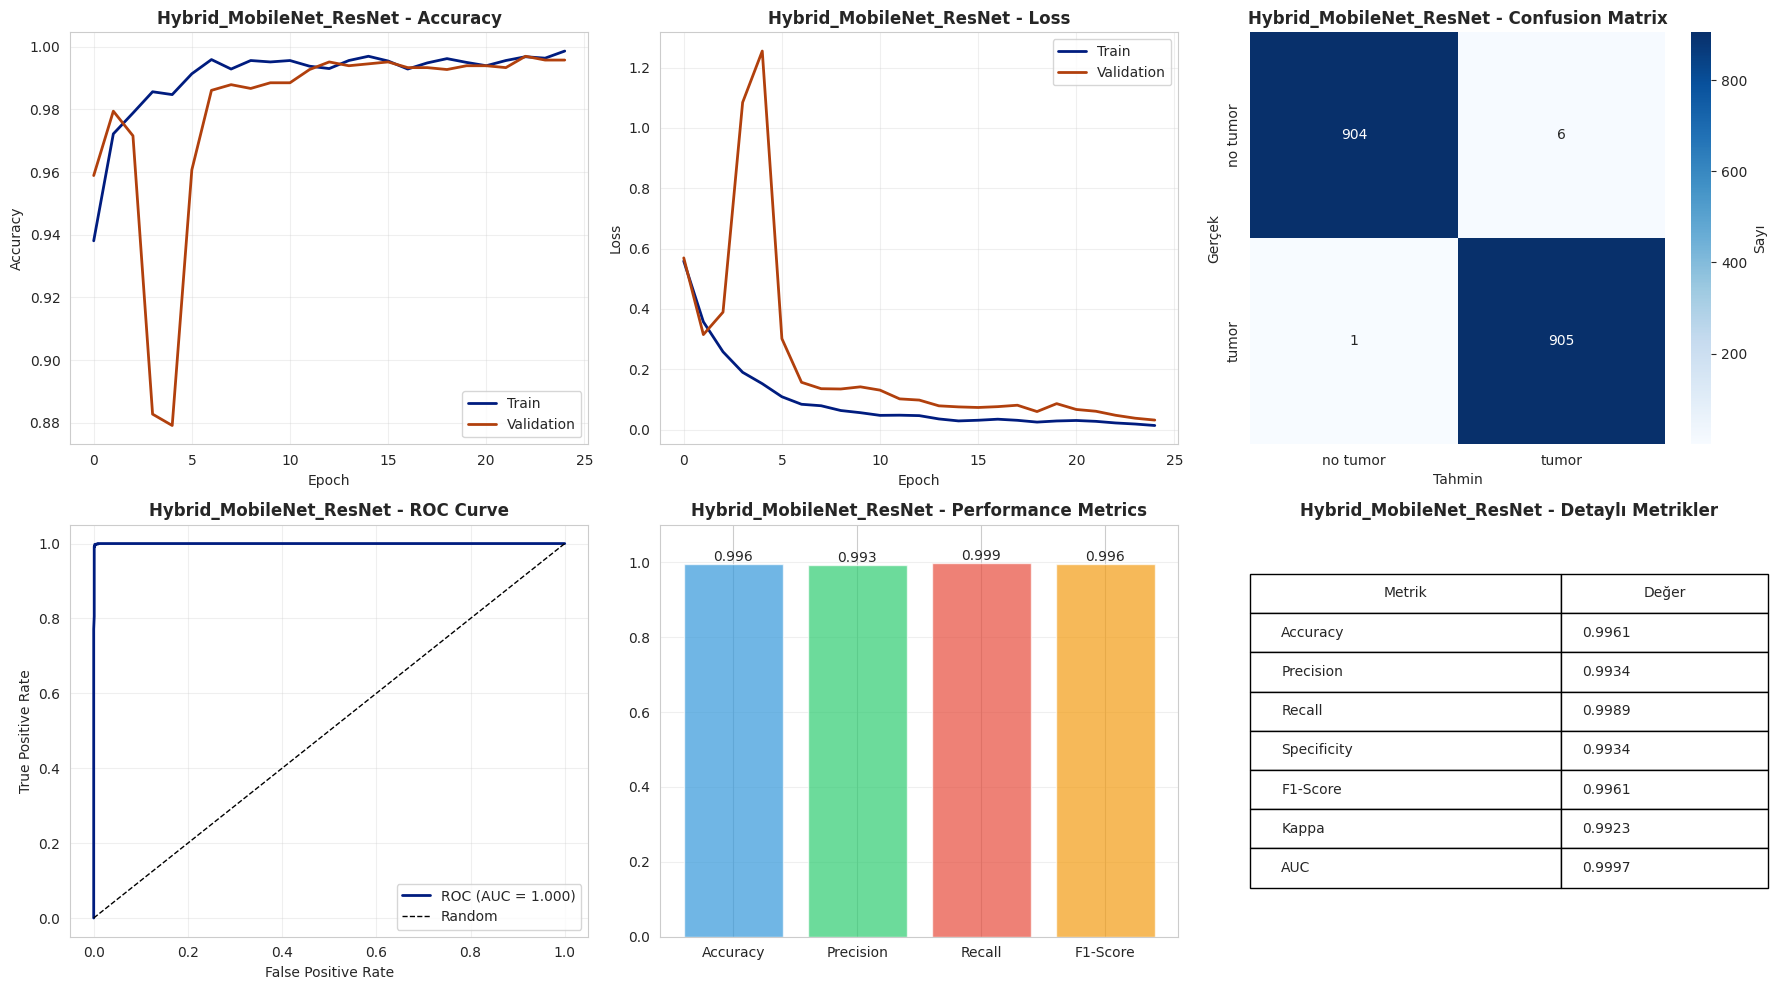

In [ ]:
print("Hibrit model test verisi üzerinde değerlendiriliyor...")
# 1. Test jeneratörü (tf.data.Dataset) üzerinde TAHMİN yap
y_pred_prob = hybrid_model.predict(test_generator, verbose=1)

# 2. Test jeneratöründen GERÇEK etiketleri (y_true) çek
y_true = np.concatenate([labels for images, labels in test_generator], axis=0)


# 3. Yeni calculate_metrics fonksiyonunu (y_true ve y_pred_prob ile) çağır
hybrid_metrics, hybrid_cm, hybrid_roc = calculate_metrics(
    y_true, y_pred_prob, 'Hybrid_MobileNet_ResNet'
)

hybrid_metrics['Avg. Epoch Time (s)'] = avg_epoch_time

# 4. plot_model_results fonksiyonunu çağır
plot_model_results(hybrid_history, hybrid_metrics, hybrid_cm,
                   hybrid_roc, 'Hybrid_MobileNet_ResNet')

# Model Tablosuna Kaydet
all_model_metrics.append(hybrid_metrics)

## MODEL 2: HİBRİT MODEL (InceptionV3 + EfficientNetB0)

In [ ]:
# ==================== MODEL 2: HİBRİT MODEL (InceptionV3 + EfficientNetB0) ====================
print("\n" + "=" * 80)
print("MODEL 9: Hibrit Model (InceptionV3 + EfficientNetB0)")
print("=" * 80)

def create_hybrid_inception_efficientnet_model():
    """
    InceptionV3 ve EfficientNetB0 modellerinin özelliklerini birleştiren
    bir hibrit model oluşturur.
    """
    # 1. Temel Modelleri Yükle (sınıflandırma katmanları olmadan)
    base_inception = InceptionV3(weights='imagenet', include_top=False,
                                 input_shape=(224, 224, 3))
    base_efficientnet = EfficientNetB0(weights='imagenet', include_top=False,
                                   input_shape=(224, 224, 3))

    # Katmanları dondurarak önceden öğrenilmiş bilgileri koru
    # (Bu modellerde dondurulacak katman sayıları farklı olabilir,
    #  ilk hibritteki gibi makul değerler seçiyoruz)
    for layer in base_inception.layers[:-30]:
        layer.trainable = False
    for layer in base_efficientnet.layers[:-20]:
        layer.trainable = False

    # Her modelin ismini özelleştirerek katman ismi çakışmasını önle
    base_inception._name = "inception_base"
    base_efficientnet._name = "efficientnet_base"

    # 2. Ortak Giriş Katmanı (1 kanaldan 3 kanala adaptör)
    input_layer = Input(shape=(224, 224, 1), name="input_image")
    input_rgb = Conv2D(3, (3, 3), padding='same', activation='relu', name="grayscale_to_rgb")(input_layer)

    # 3. Modellerin Çıktılarını Al
    features_inception = base_inception(input_rgb)
    features_efficientnet = base_efficientnet(input_rgb)

    # Özellik haritalarını vektöre dönüştür
    pooled_inception = GlobalAveragePooling2D(name="inception_pooling")(features_inception)
    pooled_efficientnet = GlobalAveragePooling2D(name="efficientnet_pooling")(features_efficientnet)

    # 4. Özellikleri Birleştir (Concatenate)
    merged_features = Concatenate(name="merged_features_2")([pooled_inception, pooled_efficientnet])

    # 5. Yeni Sınıflandırıcı Katmanları (İlk modelle aynı başarılı mimariyi kullanalım)
    x = Dropout(0.5, name="merged_dropout_2_1")(merged_features)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), name="merged_dense_2_1")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4, name="merged_dropout_2_2")(x)
    output_layer = Dense(1, activation='sigmoid', name="output_layer_2")(x)

    # 6. Hibrit Modeli Oluştur
    hybrid_model_2 = Model(inputs=input_layer, outputs=output_layer, name="Hybrid_Inception_EfficientNet")

    # Modeli derle
    hybrid_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

    return hybrid_model_2

# Hibrit modeli oluştur ve özetini yazdır
hybrid_model_2 = create_hybrid_inception_efficientnet_model()
print(hybrid_model_2.summary())

start_time_2 = time.time() # Eğitimi başlatmadan süreyi kaydet

# Hibrit modeli eğit
# (Değişken adlarını hybrid_history_2 olarak değiştirerek çakışmayı önlüyoruz)
hybrid_history_2 = hybrid_model_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=get_callbacks('hybrid_inception_efficientnet'),
    verbose=1
)

end_time_2 = time.time() # Eğitim bittiğinde süreyi kaydet
total_time_2 = end_time_2 - start_time_2
actual_epochs_2 = len(hybrid_history_2.history['loss'])
avg_epoch_time_2 = total_time_2 / actual_epochs_2
print(f"Toplam Eğitim Süresi: {total_time_2:.2f} saniye")
print(f"Çalışan Epoch Sayısı: {actual_epochs_2}")
print(f"Epoch Başına Ortalama Süre: {avg_epoch_time_2:.2f} saniye")


MODEL 9: Hibrit Model (InceptionV3 + EfficientNetB0)
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Hybrid_Inception_EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grayscale_to_rgb    │ (None, 224, 224,  │         30 │ input_image[0][0] │
│ (Conv2D)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 5, 5,      │ 21,802,784 │ grayscale_to_rgb… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ grayscale_to_rgb… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_pooling   │ (None, 2048)      │          0 │ inception_v3[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnet_pooli… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_features_2   │ (None, 3328)      │          0 │ inception_poolin… │
│ (Concatenate)       │                   │            │ efficientnet_poo… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dropout_2_1  │ (None, 3328)      │          0 │ merged_features_… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dense_2_1    │ (None, 256)       │    852,224 │ merged_dropout_2… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ merged_dense_2_1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dropout_2_2  │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer_2      │ (None, 1)         │        257 │ merged_dropout_2… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,705,890 (101.87 MB)

 Trainable params: 7,360,015 (28.08 MB)

 Non-trainable params: 19,345,875 (73.80 MB)

None
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_hybrid_inception_efficientnet.h5
Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8922 - loss: 0.7421

207/207 ━━━━━━━━━━━━━━━━━━━━ 1188s 5s/step - accuracy: 0.8924 - loss: 0.7416 - val_accuracy: 0.9776 - val_loss: 0.4677 - learning_rate: 5.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9573 - loss: 0.4863

207/207 ━━━━━━━━━━━━━━━━━━━━ 60s 272ms/step - accuracy: 0.9574 - loss: 0.4861 - val_accuracy: 0.9849 - val_loss: 0.3585 - learning_rate: 5.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9786 - loss: 0.3461

207/207 ━━━━━━━━━━━━━━━━━━━━ 64s 290ms/step - accuracy: 0.9786 - loss: 0.3461 - val_accuracy: 0.9940 - val_loss: 0.2638 - learning_rate: 5.0000e-04
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9800 - loss: 0.2758

207/207 ━━━━━━━━━━━━━━━━━━━━ 77s 270ms/step - accuracy: 0.9800 - loss: 0.2757 - val_accuracy: 0.9897 - val_loss: 0.2208 - learning_rate: 5.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9833 - loss: 0.2203

207/207 ━━━━━━━━━━━━━━━━━━━━ 63s 290ms/step - accuracy: 0.9833 - loss: 0.2203 - val_accuracy: 0.9921 - val_loss: 0.1709 - learning_rate: 5.0000e-04
Epoch 6/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9876 - loss: 0.1644

207/207 ━━━━━━━━━━━━━━━━━━━━ 65s 297ms/step - accuracy: 0.9876 - loss: 0.1644 - val_accuracy: 0.9946 - val_loss: 0.1316 - learning_rate: 5.0000e-04
Epoch 7/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9888 - loss: 0.1307

207/207 ━━━━━━━━━━━━━━━━━━━━ 76s 269ms/step - accuracy: 0.9888 - loss: 0.1307 - val_accuracy: 0.9946 - val_loss: 0.1151 - learning_rate: 5.0000e-04
Epoch 8/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9882 - loss: 0.1104

207/207 ━━━━━━━━━━━━━━━━━━━━ 68s 308ms/step - accuracy: 0.9882 - loss: 0.1104 - val_accuracy: 0.9946 - val_loss: 0.0836 - learning_rate: 5.0000e-04
Epoch 9/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9929 - loss: 0.0795

207/207 ━━━━━━━━━━━━━━━━━━━━ 66s 300ms/step - accuracy: 0.9929 - loss: 0.0795 - val_accuracy: 0.9940 - val_loss: 0.0751 - learning_rate: 5.0000e-04
Epoch 10/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9904 - loss: 0.0718

207/207 ━━━━━━━━━━━━━━━━━━━━ 78s 280ms/step - accuracy: 0.9904 - loss: 0.0718 - val_accuracy: 0.9934 - val_loss: 0.0666 - learning_rate: 5.0000e-04
Epoch 11/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 65s 297ms/step - accuracy: 0.9905 - loss: 0.0657 - val_accuracy: 0.9927 - val_loss: 0.0672 - learning_rate: 5.0000e-04
Epoch 12/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9907 - loss: 0.0593

207/207 ━━━━━━━━━━━━━━━━━━━━ 66s 299ms/step - accuracy: 0.9907 - loss: 0.0593 - val_accuracy: 0.9952 - val_loss: 0.0528 - learning_rate: 5.0000e-04
Epoch 13/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9958 - loss: 0.0444

207/207 ━━━━━━━━━━━━━━━━━━━━ 69s 317ms/step - accuracy: 0.9958 - loss: 0.0444 - val_accuracy: 0.9952 - val_loss: 0.0521 - learning_rate: 5.0000e-04
Epoch 14/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9970 - loss: 0.0352

207/207 ━━━━━━━━━━━━━━━━━━━━ 65s 295ms/step - accuracy: 0.9970 - loss: 0.0352 - val_accuracy: 0.9946 - val_loss: 0.0385 - learning_rate: 5.0000e-04
Epoch 15/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 72s 319ms/step - accuracy: 0.9921 - loss: 0.0391 - val_accuracy: 0.9964 - val_loss: 0.0492 - learning_rate: 5.0000e-04
Epoch 16/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 63s 281ms/step - accuracy: 0.9925 - loss: 0.0418 - val_accuracy: 0.9958 - val_loss: 0.0501 - learning_rate: 5.0000e-04
Epoch 17/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9935 - loss: 0.0416
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
207/207 ━━━━━━━━━━━━━━━━━━━━ 66s 289ms/step - accuracy: 0.9935 - loss: 0.0416 - val_accuracy: 0.9946 - val_loss: 0.0522 - learning_rate: 5.0000e-04
Epoch 18/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 66s 306ms/step - accuracy: 0.9967 - loss: 0.0356 - val_accuracy: 0.9952 - val_loss: 0.0416 - learning_rate: 2.5000e-04
Epoch 19/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 61s 277ms/step - 

Hibrit model (InceptionV3 + EfficientNetB0) test verisi üzerinde değerlendiriliyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step


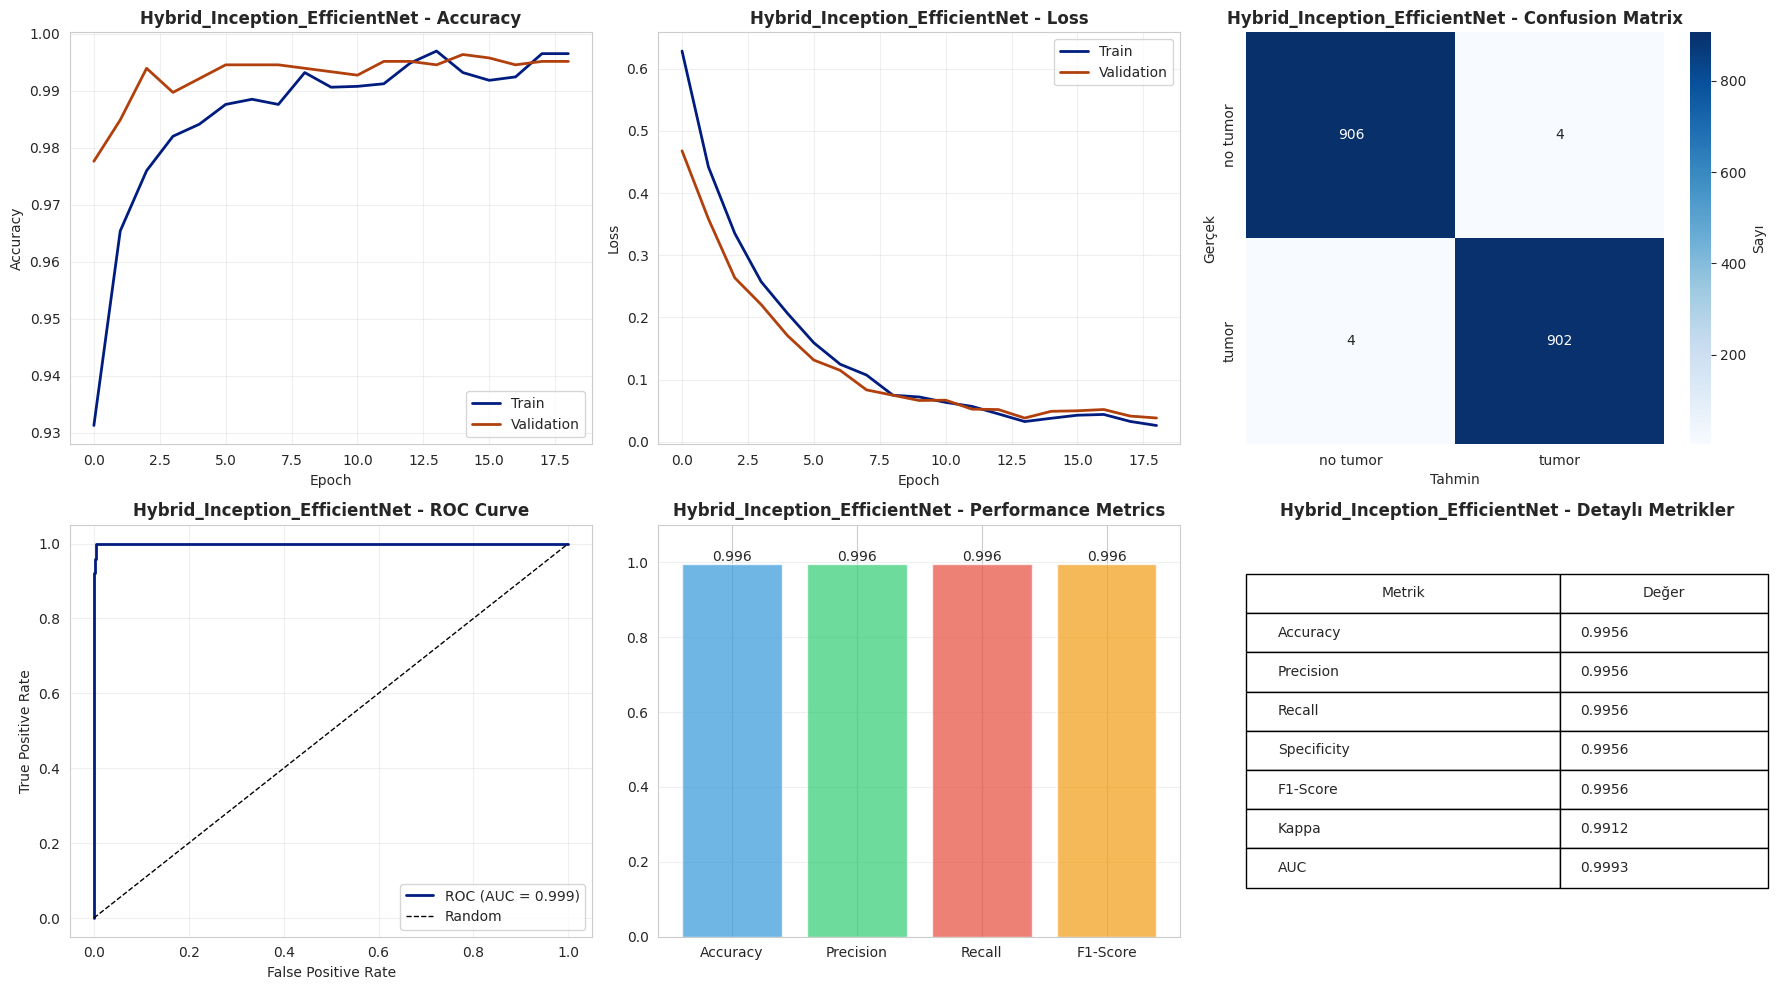

In [ ]:
# ==================== MODEL 2: METRİK HESAPLAMA (Hybrid: InceptionV3 + EfficientNetB0) ====================
print("Hibrit model (InceptionV3 + EfficientNetB0) test verisi üzerinde değerlendiriliyor...")
# 1. Test jeneratörü (tf.data.Dataset) üzerinde TAHMİN yap
y_pred_prob_2 = hybrid_model_2.predict(test_generator, verbose=1)

# 2. Test jeneratörü (tf.data.Dataset) üzerinden GERÇEK etiketleri (y_true) çek
y_true_2 = np.concatenate([labels for images, labels in test_generator], axis=0)

# 3. Yeni calculate_metrics fonksiyonunu çağır
# (ÖNCE metrik sözlüğünü ('hybrid_metrics_2') oluşturuyoruz)
hybrid_metrics_2, hybrid_cm_2, hybrid_roc_2 = calculate_metrics(
    y_true_2, y_pred_prob_2, 'Hybrid_Inception_EfficientNet'
)

# <--- GÜNCELLEME: Ortalama epoch süresini DOĞRU sözlüğe (hybrid_metrics_2)
# ve DOĞRU zamanda (calculate_metrics'ten SONRA) ekliyoruz.
hybrid_metrics_2['Avg. Epoch Time (s)'] = avg_epoch_time_2
# <--- GÜNCELLEME SONU --- >

# 4. plot_model_results fonksiyonunu çağır
plot_model_results(hybrid_history_2, hybrid_metrics_2, hybrid_cm_2,
                   hybrid_roc_2, 'Hybrid_Inception_EfficientNet')

# 5. Model Tablosuna Kaydet
all_model_metrics.append(hybrid_metrics_2)

### **MODEL 3: HİBRİT MODEL (DenseNet121 + Xception)**

In [ ]:
# ==================== MODEL 3: HİBRİT MODEL (DenseNet121 + Xception) ====================
print("\n" + "=" * 80)
print("MODEL 10: Hibrit Model (DenseNet121 + Xception)")
print("=" * 80)

def create_hybrid_densenet_xception_model():
    """
    DenseNet121 ve Xception modellerinin özelliklerini birleştiren
    bir hibrit model oluşturur.
    """
    # 1. Temel Modelleri Yükle
    base_densenet = DenseNet121(weights='imagenet', include_top=False,
                                 input_shape=(224, 224, 3))
    base_xception = Xception(weights='imagenet', include_top=False,
                             input_shape=(224, 224, 3))

    # Katmanları dondur
    for layer in base_densenet.layers[:-25]:
        layer.trainable = False
    for layer in base_xception.layers[:-20]:
        layer.trainable = False

    # Katman ismi çakışmasını önle
    base_densenet._name = "densenet_base"
    base_xception._name = "xception_base"

    # 2. Ortak Giriş Katmanı (1 kanaldan 3 kanala adaptör)
    input_layer = Input(shape=(224, 224, 1), name="input_image")
    input_rgb = Conv2D(3, (3, 3), padding='same', activation='relu', name="grayscale_to_rgb")(input_layer)

    # 3. Modellerin Çıktılarını Al
    features_densenet = base_densenet(input_rgb)
    features_xception = base_xception(input_rgb)

    # Özellik haritalarını vektöre dönüştür
    pooled_densenet = GlobalAveragePooling2D(name="densenet_pooling")(features_densenet)
    pooled_xception = GlobalAveragePooling2D(name="xception_pooling")(features_xception)

    # 4. Özellikleri Birleştir
    merged_features = Concatenate(name="merged_features_3")([pooled_densenet, pooled_xception])

    # 5. Yeni Sınıflandırıcı Katmanları (Başarılı mimariyi tekrar kullanalım)
    x = Dropout(0.5, name="merged_dropout_3_1")(merged_features)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), name="merged_dense_3_1")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4, name="merged_dropout_3_2")(x)
    output_layer = Dense(1, activation='sigmoid', name="output_layer_3")(x)

    # 6. Hibrit Modeli Oluştur
    hybrid_model_3 = Model(inputs=input_layer, outputs=output_layer, name="Hybrid_DenseNet_Xception")

    # Modeli derle
    hybrid_model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

    return hybrid_model_3

# Hibrit modeli oluştur ve özetini yazdır
hybrid_model_3 = create_hybrid_densenet_xception_model()
print(hybrid_model_3.summary())

# Zaman ölçümü için başlat
start_time_3 = time.time()

# Hibrit modeli eğit
hybrid_history_3 = hybrid_model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=get_callbacks('hybrid_densenet_xception'),
    verbose=1
)

# Zaman ölçümünü bitir ve hesapla
end_time_3 = time.time()
total_time_3 = end_time_3 - start_time_3
actual_epochs_3 = len(hybrid_history_3.history['loss'])
avg_epoch_time_3 = total_time_3 / actual_epochs_3

print(f"Toplam Eğitim Süresi: {total_time_3:.2f} saniye")
print(f"Çalışan Epoch Sayısı: {actual_epochs_3}")
print(f"Epoch Başına Ortalama Süre: {avg_epoch_time_3:.2f} saniye")


MODEL 10: Hibrit Model (DenseNet121 + Xception)
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Hybrid_DenseNet_Xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grayscale_to_rgb    │ (None, 224, 224,  │         30 │ input_image[0][0] │
│ (Conv2D)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet121         │ (None, 7, 7,      │  7,037,504 │ grayscale_to_rgb… │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 7, 7,      │ 20,861,480 │ grayscale_to_rgb… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet_pooling    │ (None, 1024)      │          0 │ densenet121[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception_pooling    │ (None, 2048)      │          0 │ xception[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_features_3   │ (None, 3072)      │          0 │ densenet_pooling… │
│ (Concatenate)       │                   │            │ xception_pooling… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dropout_3_1  │ (None, 3072)      │          0 │ merged_features_… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dense_3_1    │ (None, 256)       │    786,688 │ merged_dropout_3… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ merged_dense_3_1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dropout_3_2  │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer_3      │ (None, 1)         │        257 │ merged_dropout_3… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,686,983 (109.43 MB)

 Trainable params: 8,638,535 (32.95 MB)

 Non-trainable params: 20,048,448 (76.48 MB)

None
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_hybrid_densenet_xception.h5
Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8993 - loss: 0.6362

207/207 ━━━━━━━━━━━━━━━━━━━━ 981s 4s/step - accuracy: 0.8995 - loss: 0.6355 - val_accuracy: 0.9861 - val_loss: 0.3331 - learning_rate: 5.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9702 - loss: 0.3296

207/207 ━━━━━━━━━━━━━━━━━━━━ 104s 481ms/step - accuracy: 0.9703 - loss: 0.3294 - val_accuracy: 0.9921 - val_loss: 0.2175 - learning_rate: 5.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9877 - loss: 0.2129

207/207 ━━━━━━━━━━━━━━━━━━━━ 107s 500ms/step - accuracy: 0.9877 - loss: 0.2129 - val_accuracy: 0.9952 - val_loss: 0.1591 - learning_rate: 5.0000e-04
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9893 - loss: 0.1533

207/207 ━━━━━━━━━━━━━━━━━━━━ 108s 501ms/step - accuracy: 0.9893 - loss: 0.1533 - val_accuracy: 0.9885 - val_loss: 0.1333 - learning_rate: 5.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9951 - loss: 0.1088

207/207 ━━━━━━━━━━━━━━━━━━━━ 109s 504ms/step - accuracy: 0.9951 - loss: 0.1088 - val_accuracy: 0.9903 - val_loss: 0.1156 - learning_rate: 5.0000e-04
Epoch 6/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9903 - loss: 0.0988

207/207 ━━━━━━━━━━━━━━━━━━━━ 108s 504ms/step - accuracy: 0.9903 - loss: 0.0988 - val_accuracy: 0.9903 - val_loss: 0.0881 - learning_rate: 5.0000e-04
Epoch 7/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9947 - loss: 0.0739

207/207 ━━━━━━━━━━━━━━━━━━━━ 110s 515ms/step - accuracy: 0.9947 - loss: 0.0738 - val_accuracy: 0.9964 - val_loss: 0.0575 - learning_rate: 5.0000e-04
Epoch 8/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9918 - loss: 0.0671

207/207 ━━━━━━━━━━━━━━━━━━━━ 108s 506ms/step - accuracy: 0.9918 - loss: 0.0670 - val_accuracy: 0.9964 - val_loss: 0.0532 - learning_rate: 5.0000e-04
Epoch 9/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9919 - loss: 0.0619

207/207 ━━━━━━━━━━━━━━━━━━━━ 107s 501ms/step - accuracy: 0.9919 - loss: 0.0619 - val_accuracy: 0.9976 - val_loss: 0.0460 - learning_rate: 5.0000e-04
Epoch 10/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 103s 482ms/step - accuracy: 0.9918 - loss: 0.0551 - val_accuracy: 0.9927 - val_loss: 0.0595 - learning_rate: 5.0000e-04
Epoch 11/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9939 - loss: 0.0473

207/207 ━━━━━━━━━━━━━━━━━━━━ 106s 499ms/step - accuracy: 0.9939 - loss: 0.0473 - val_accuracy: 0.9964 - val_loss: 0.0408 - learning_rate: 5.0000e-04
Epoch 12/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 104s 486ms/step - accuracy: 0.9940 - loss: 0.0438 - val_accuracy: 0.9970 - val_loss: 0.0411 - learning_rate: 5.0000e-04
Epoch 13/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9960 - loss: 0.0371

207/207 ━━━━━━━━━━━━━━━━━━━━ 107s 502ms/step - accuracy: 0.9960 - loss: 0.0371 - val_accuracy: 0.9976 - val_loss: 0.0312 - learning_rate: 5.0000e-04
Epoch 14/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 104s 488ms/step - accuracy: 0.9962 - loss: 0.0320 - val_accuracy: 0.9958 - val_loss: 0.0375 - learning_rate: 5.0000e-04
Epoch 15/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 100s 469ms/step - accuracy: 0.9957 - loss: 0.0363 - val_accuracy: 0.9934 - val_loss: 0.0427 - learning_rate: 5.0000e-04
Epoch 16/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9970 - loss: 0.0262

207/207 ━━━━━━━━━━━━━━━━━━━━ 108s 505ms/step - accuracy: 0.9970 - loss: 0.0262 - val_accuracy: 0.9982 - val_loss: 0.0244 - learning_rate: 5.0000e-04
Epoch 17/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 104s 483ms/step - accuracy: 0.9972 - loss: 0.0281 - val_accuracy: 0.9970 - val_loss: 0.0292 - learning_rate: 5.0000e-04
Epoch 18/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 100s 468ms/step - accuracy: 0.9983 - loss: 0.0222 - val_accuracy: 0.9958 - val_loss: 0.0291 - learning_rate: 5.0000e-04
Epoch 19/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9961 - loss: 0.0290

207/207 ━━━━━━━━━━━━━━━━━━━━ 106s 494ms/step - accuracy: 0.9961 - loss: 0.0290 - val_accuracy: 0.9970 - val_loss: 0.0230 - learning_rate: 5.0000e-04
Epoch 20/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 104s 483ms/step - accuracy: 0.9976 - loss: 0.0205 - val_accuracy: 0.9970 - val_loss: 0.0355 - learning_rate: 5.0000e-04
Epoch 21/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 139s 468ms/step - accuracy: 0.9954 - loss: 0.0260 - val_accuracy: 0.9952 - val_loss: 0.0290 - learning_rate: 5.0000e-04
Epoch 22/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9962 - loss: 0.0264
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
207/207 ━━━━━━━━━━━━━━━━━━━━ 100s 468ms/step - accuracy: 0.9962 - loss: 0.0264 - val_accuracy: 0.9970 - val_loss: 0.0311 - learning_rate: 5.0000e-04
Epoch 23/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 101s 468ms/step - accuracy: 0.9951 - loss: 0.0250 - val_accuracy: 0.9970 - val_loss: 0.0239 - learning_rate: 2.5000e-04
Epoch 24/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/ste

207/207 ━━━━━━━━━━━━━━━━━━━━ 106s 496ms/step - accuracy: 0.9985 - loss: 0.0150 - val_accuracy: 0.9970 - val_loss: 0.0198 - learning_rate: 2.5000e-04
Epoch 25/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9991 - loss: 0.0113

207/207 ━━━━━━━━━━━━━━━━━━━━ 111s 522ms/step - accuracy: 0.9991 - loss: 0.0113 - val_accuracy: 0.9982 - val_loss: 0.0188 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 25.
Toplam Eğitim Süresi: 3542.40 saniye
Çalışan Epoch Sayısı: 25
Epoch Başına Ortalama Süre: 141.70 saniye


Hibrit model (DenseNet121 + Xception) test verisi üzerinde değerlendiriliyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 315s 5s/step


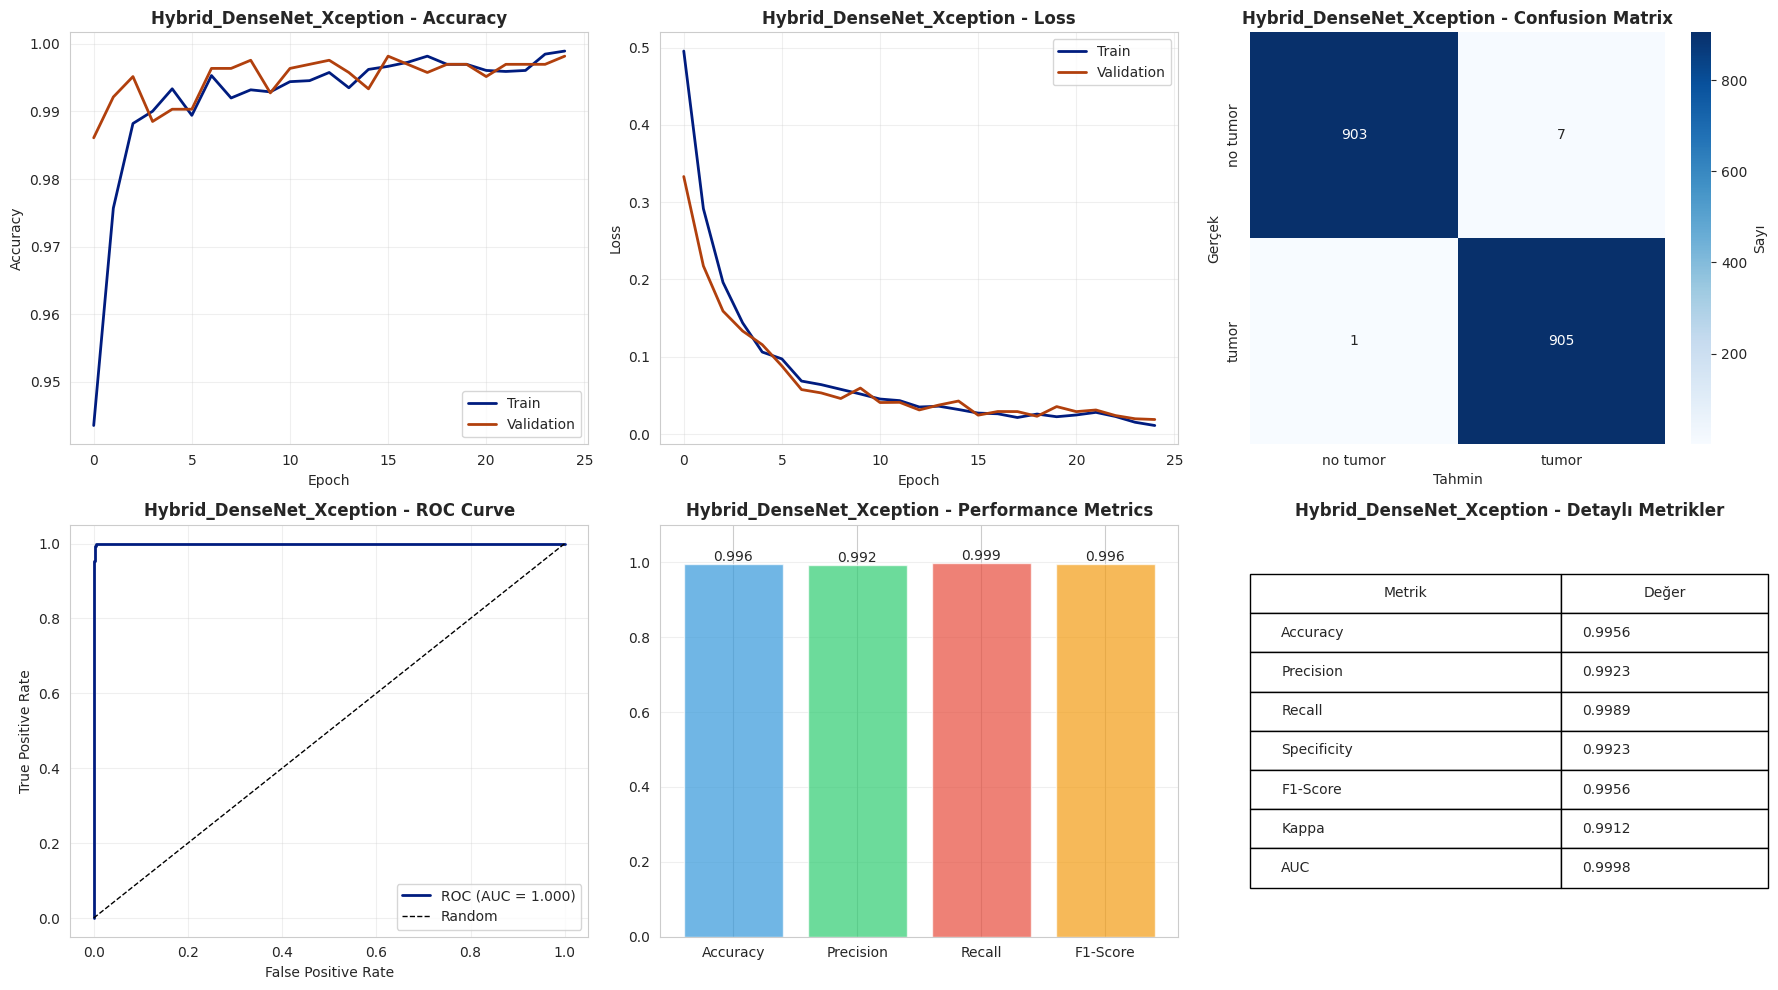

In [ ]:
# ==================== MODEL 3: METRİK HESAPLAMA (Hybrid: DenseNet121 + Xception) ====================
print("Hibrit model (DenseNet121 + Xception) test verisi üzerinde değerlendiriliyor...")
# 1. Test jeneratörü (tf.data.Dataset) üzerinde TAHMİN yap
y_pred_prob_3 = hybrid_model_3.predict(test_generator, verbose=1)

# 2. Test jeneratöründen GERÇEK etiketleri (y_true) çek
# (y_true değişkeni önceki metrik hücresinde zaten tanımlanmış olabilir,
# ancak burada 'y_true_3' olarak yeniden çekmek en güvenli yoldur)
y_true_3 = np.concatenate([labels for images, labels in test_generator], axis=0)

# 3. Yeni calculate_metrics fonksiyonunu çağır
hybrid_metrics_3, hybrid_cm_3, hybrid_roc_3 = calculate_metrics(
    y_true_3, y_pred_prob_3, 'Hybrid_DenseNet_Xception'
)

# 4. Ortalama epoch süresini metrik sözlüğüne ekle
hybrid_metrics_3['Avg. Epoch Time (s)'] = avg_epoch_time_3

# 5. plot_model_results fonksiyonunu çağır
plot_model_results(hybrid_history_3, hybrid_metrics_3, hybrid_cm_3,
                   hybrid_roc_3, 'Hybrid_DenseNet_Xception')

# 6. Model Tablosuna Kaydet
all_model_metrics.append(hybrid_metrics_3)

### **MODEL 4: HİBRİT MODEL (VGG16 + EfficientNetB0)**

In [ ]:
# ==================== MODEL 4: HİBRİT MODEL (VGG16 + EfficientNetB0) ====================
print("\n" + "=" * 80)
print("MODEL 11: Hibrit Model (VGG16 + EfficientNetB0)")
print("=" * 80)

def create_hybrid_vgg_efficientnet_model():
    """
    VGG16 ve EfficientNetB0 modellerinin özelliklerini birleştiren
    bir hibrit model oluşturur.
    """
    # 1. Temel Modelleri Yükle
    base_vgg = VGG16(weights='imagenet', include_top=False,
                     input_shape=(224, 224, 3))
    base_efficientnet = EfficientNetB0(weights='imagenet', include_top=False,
                                   input_shape=(224, 224, 3))

    # Katmanları dondur
    # VGG16'nın son 4 katmanını (son conv bloğu) eğitime aç
    for layer in base_vgg.layers[:-4]:
        layer.trainable = False
    # EfficientNet'in son 20 katmanını eğitime aç
    for layer in base_efficientnet.layers[:-20]:
        layer.trainable = False

    # Katman ismi çakışmasını önle
    base_vgg._name = "vgg_base"
    base_efficientnet._name = "efficientnet_base_2" # (Daha önce kullanıldıysa diye)

    # 2. Ortak Giriş Katmanı (1 kanaldan 3 kanala adaptör)
    input_layer = Input(shape=(224, 224, 1), name="input_image")
    input_rgb = Conv2D(3, (3, 3), padding='same', activation='relu', name="grayscale_to_rgb")(input_layer)

    # 3. Modellerin Çıktılarını Al
    features_vgg = base_vgg(input_rgb)
    features_efficientnet = base_efficientnet(input_rgb)

    # Özellik haritalarını vektöre dönüştür
    # VGG16'nın çıktısı (7,7,512) boyutludur, GAP ile vektörleştirilir.
    pooled_vgg = GlobalAveragePooling2D(name="vgg_pooling")(features_vgg)
    pooled_efficientnet = GlobalAveragePooling2D(name="efficientnet_pooling_2")(features_efficientnet)

    # 4. Özellikleri Birleştir
    merged_features = Concatenate(name="merged_features_4")([pooled_vgg, pooled_efficientnet])

    # 5. Yeni Sınıflandırıcı Katmanları (Başarılı mimariyi tekrar kullanalım)
    x = Dropout(0.5, name="merged_dropout_4_1")(merged_features)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), name="merged_dense_4_1")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4, name="merged_dropout_4_2")(x)
    output_layer = Dense(1, activation='sigmoid', name="output_layer_4")(x)

    # 6. Hibrit Modeli Oluştur
    hybrid_model_4 = Model(inputs=input_layer, outputs=output_layer, name="Hybrid_VGG16_EfficientNet")

    # Modeli derle
    hybrid_model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

    return hybrid_model_4

# Hibrit modeli oluştur ve özetini yazdır
hybrid_model_4 = create_hybrid_vgg_efficientnet_model()
print(hybrid_model_4.summary())

# Zaman ölçümü için başlat
start_time_4 = time.time()

# Hibrit modeli eğit
hybrid_history_4 = hybrid_model_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=get_callbacks('hybrid_vgg16_efficientnet'),
    verbose=1
)

# Zaman ölçümünü bitir ve hesapla
end_time_4 = time.time()
total_time_4 = end_time_4 - start_time_4
actual_epochs_4 = len(hybrid_history_4.history['loss'])
avg_epoch_time_4 = total_time_4 / actual_epochs_4

print(f"Toplam Eğitim Süresi: {total_time_4:.2f} saniye")
print(f"Çalışan Epoch Sayısı: {actual_epochs_4}")
print(f"Epoch Başına Ortalama Süre: {avg_epoch_time_4:.2f} saniye")


MODEL 11: Hibrit Model (VGG16 + EfficientNetB0)
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Hybrid_VGG16_EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grayscale_to_rgb    │ (None, 224, 224,  │         30 │ input_image[0][0] │
│ (Conv2D)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ grayscale_to_rgb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ grayscale_to_rgb… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg_pooling         │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnet_pooli… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_features_4   │ (None, 1792)      │          0 │ vgg_pooling[0][0… │
│ (Concatenate)       │                   │            │ efficientnet_poo… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dropout_4_1  │ (None, 1792)      │          0 │ merged_features_… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dense_4_1    │ (None, 256)       │    459,008 │ merged_dropout_4… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ merged_dense_4_1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dropout_4_2  │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer_4      │ (None, 1)         │        257 │ merged_dropout_4… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,224,578 (73.34 MB)

 Trainable params: 8,890,191 (33.91 MB)

 Non-trainable params: 10,334,387 (39.42 MB)

None
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_hybrid_vgg16_efficientnet.h5
Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8116 - loss: 0.8352

207/207 ━━━━━━━━━━━━━━━━━━━━ 1042s 4s/step - accuracy: 0.8120 - loss: 0.8341 - val_accuracy: 0.7994 - val_loss: 1.0872 - learning_rate: 5.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9438 - loss: 0.3614

207/207 ━━━━━━━━━━━━━━━━━━━━ 102s 473ms/step - accuracy: 0.9438 - loss: 0.3611 - val_accuracy: 0.9547 - val_loss: 0.2917 - learning_rate: 5.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9677 - loss: 0.2136

207/207 ━━━━━━━━━━━━━━━━━━━━ 104s 484ms/step - accuracy: 0.9677 - loss: 0.2136 - val_accuracy: 0.9873 - val_loss: 0.1229 - learning_rate: 5.0000e-04
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9728 - loss: 0.1551

207/207 ━━━━━━━━━━━━━━━━━━━━ 103s 483ms/step - accuracy: 0.9728 - loss: 0.1550 - val_accuracy: 0.9837 - val_loss: 0.0963 - learning_rate: 5.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9783 - loss: 0.1227

207/207 ━━━━━━━━━━━━━━━━━━━━ 103s 483ms/step - accuracy: 0.9783 - loss: 0.1226 - val_accuracy: 0.9891 - val_loss: 0.0773 - learning_rate: 5.0000e-04
Epoch 6/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 100s 467ms/step - accuracy: 0.9845 - loss: 0.0894 - val_accuracy: 0.9861 - val_loss: 0.0794 - learning_rate: 5.0000e-04
Epoch 7/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 98s 457ms/step - accuracy: 0.9862 - loss: 0.0726 - val_accuracy: 0.9819 - val_loss: 0.0917 - learning_rate: 5.0000e-04
Epoch 8/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9828 - loss: 0.0754

207/207 ━━━━━━━━━━━━━━━━━━━━ 100s 470ms/step - accuracy: 0.9828 - loss: 0.0754 - val_accuracy: 0.9946 - val_loss: 0.0447 - learning_rate: 5.0000e-04
Epoch 9/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9866 - loss: 0.0684

207/207 ━━━━━━━━━━━━━━━━━━━━ 104s 481ms/step - accuracy: 0.9866 - loss: 0.0684 - val_accuracy: 0.9934 - val_loss: 0.0424 - learning_rate: 5.0000e-04
Epoch 10/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9879 - loss: 0.0581

207/207 ━━━━━━━━━━━━━━━━━━━━ 103s 477ms/step - accuracy: 0.9879 - loss: 0.0581 - val_accuracy: 0.9952 - val_loss: 0.0339 - learning_rate: 5.0000e-04
Epoch 11/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 103s 461ms/step - accuracy: 0.9895 - loss: 0.0526 - val_accuracy: 0.9952 - val_loss: 0.0420 - learning_rate: 5.0000e-04
Epoch 12/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 98s 457ms/step - accuracy: 0.9911 - loss: 0.0474 - val_accuracy: 0.9934 - val_loss: 0.0529 - learning_rate: 5.0000e-04
Epoch 13/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9924 - loss: 0.0439

207/207 ━━━━━━━━━━━━━━━━━━━━ 102s 476ms/step - accuracy: 0.9924 - loss: 0.0439 - val_accuracy: 0.9970 - val_loss: 0.0255 - learning_rate: 5.0000e-04
Epoch 14/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 103s 468ms/step - accuracy: 0.9945 - loss: 0.0340 - val_accuracy: 0.9450 - val_loss: 0.1961 - learning_rate: 5.0000e-04
Epoch 15/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 98s 459ms/step - accuracy: 0.9942 - loss: 0.0317 - val_accuracy: 0.9553 - val_loss: 0.1680 - learning_rate: 5.0000e-04
Epoch 16/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9917 - loss: 0.0324
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
207/207 ━━━━━━━━━━━━━━━━━━━━ 99s 459ms/step - accuracy: 0.9917 - loss: 0.0324 - val_accuracy: 0.9927 - val_loss: 0.0368 - learning_rate: 5.0000e-04
Epoch 17/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9967 - loss: 0.0224

207/207 ━━━━━━━━━━━━━━━━━━━━ 101s 476ms/step - accuracy: 0.9967 - loss: 0.0224 - val_accuracy: 0.9976 - val_loss: 0.0224 - learning_rate: 2.5000e-04
Epoch 18/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 101s 471ms/step - accuracy: 0.9961 - loss: 0.0210 - val_accuracy: 0.9970 - val_loss: 0.0237 - learning_rate: 2.5000e-04
Epoch 19/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 99s 459ms/step - accuracy: 0.9976 - loss: 0.0171 - val_accuracy: 0.9982 - val_loss: 0.0245 - learning_rate: 2.5000e-04
Epoch 20/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9966 - loss: 0.0210

207/207 ━━━━━━━━━━━━━━━━━━━━ 102s 476ms/step - accuracy: 0.9966 - loss: 0.0209 - val_accuracy: 0.9976 - val_loss: 0.0214 - learning_rate: 2.5000e-04
Epoch 21/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9964 - loss: 0.0167

207/207 ━━━━━━━━━━━━━━━━━━━━ 109s 509ms/step - accuracy: 0.9964 - loss: 0.0167 - val_accuracy: 0.9982 - val_loss: 0.0203 - learning_rate: 2.5000e-04
Epoch 22/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 101s 473ms/step - accuracy: 0.9975 - loss: 0.0154 - val_accuracy: 0.9964 - val_loss: 0.0218 - learning_rate: 2.5000e-04
Epoch 23/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 98s 459ms/step - accuracy: 0.9957 - loss: 0.0208 - val_accuracy: 0.9964 - val_loss: 0.0258 - learning_rate: 2.5000e-04
Epoch 24/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9959 - loss: 0.0205
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
207/207 ━━━━━━━━━━━━━━━━━━━━ 98s 459ms/step - accuracy: 0.9959 - loss: 0.0205 - val_accuracy: 0.9970 - val_loss: 0.0276 - learning_rate: 2.5000e-04
Epoch 25/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9985 - loss: 0.0122

207/207 ━━━━━━━━━━━━━━━━━━━━ 102s 474ms/step - accuracy: 0.9985 - loss: 0.0122 - val_accuracy: 0.9970 - val_loss: 0.0184 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 25.
Toplam Eğitim Süresi: 3472.72 saniye
Çalışan Epoch Sayısı: 25
Epoch Başına Ortalama Süre: 138.91 saniye


Hibrit model (VGG16 + EfficientNetB0) test verisi üzerinde değerlendiriliyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 368s 6s/step


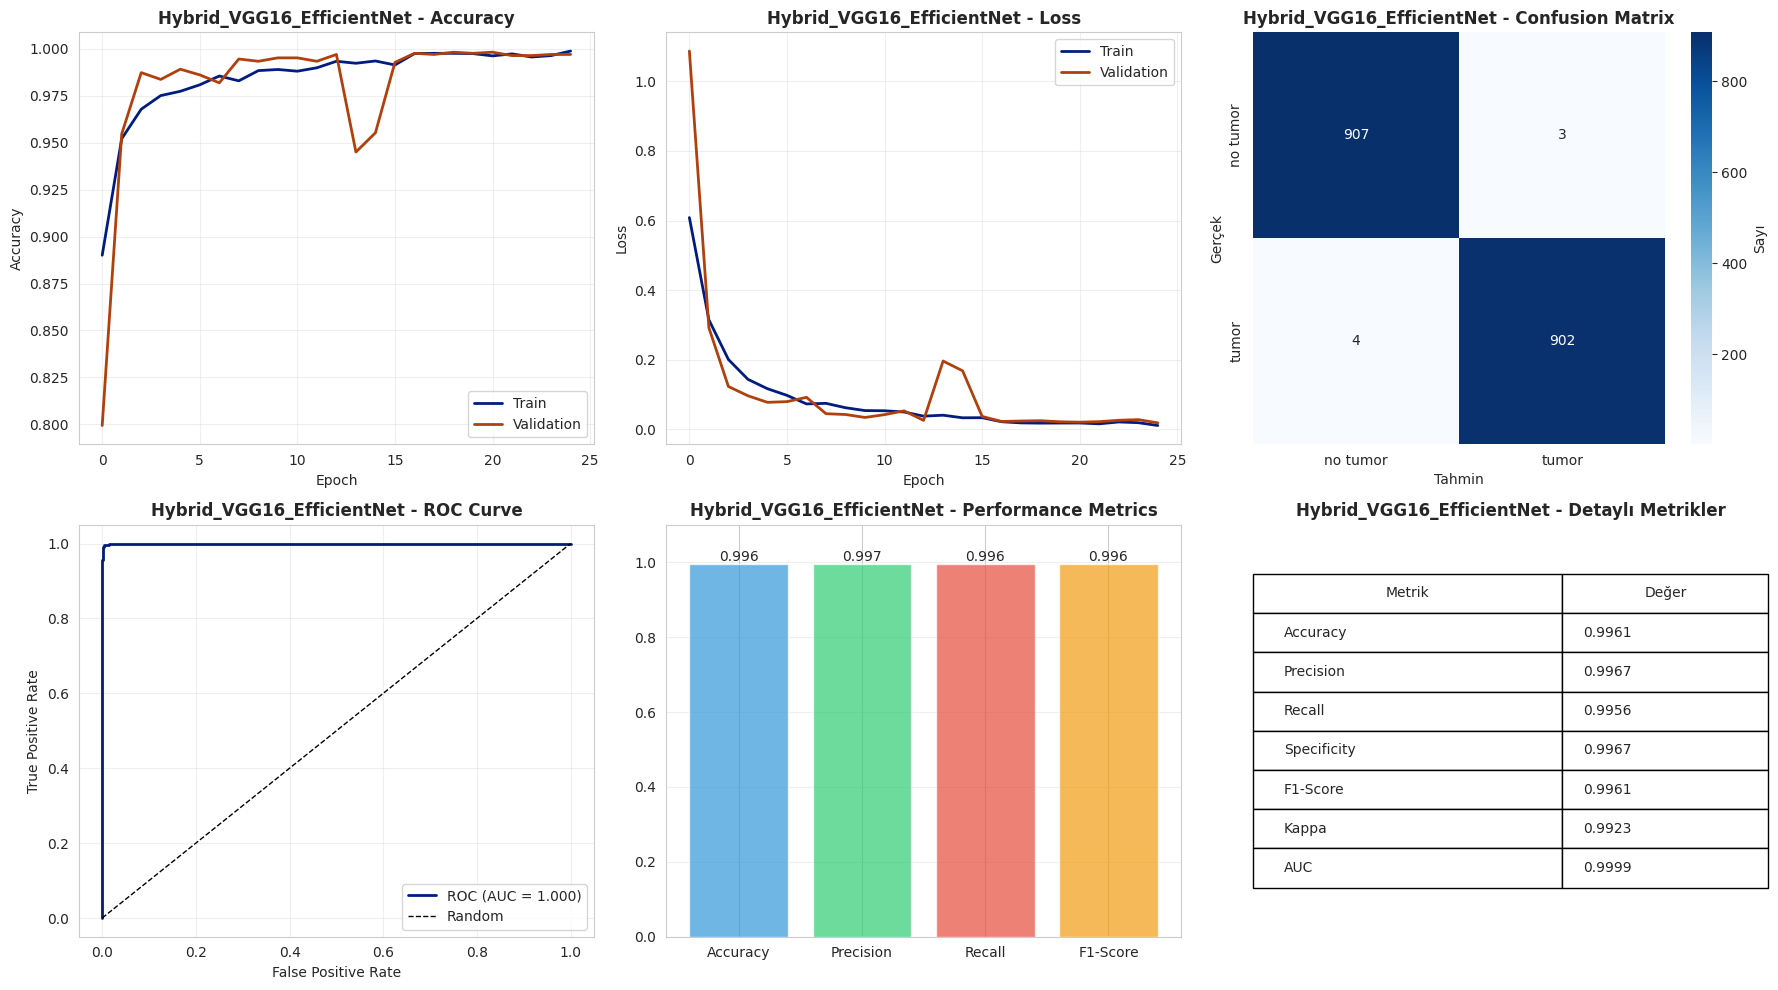

In [ ]:
# ==================== MODEL 4: METRİK HESAPLAMA (Hybrid: VGG16 + EfficientNetB0) ====================
print("Hibrit model (VGG16 + EfficientNetB0) test verisi üzerinde değerlendiriliyor...")
# 1. Test jeneratörü (tf.data.Dataset) üzerinde TAHMİN yap
y_pred_prob_4 = hybrid_model_4.predict(test_generator, verbose=1)

# 2. Test jeneratöründen GERÇEK etiketleri (y_true) çek
y_true_4 = np.concatenate([labels for images, labels in test_generator], axis=0)

# 3. Yeni calculate_metrics fonksiyonunu çağır
hybrid_metrics_4, hybrid_cm_4, hybrid_roc_4 = calculate_metrics(
    y_true_4, y_pred_prob_4, 'Hybrid_VGG16_EfficientNet'
)

# 4. Ortalama epoch süresini metrik sözlüğüne ekle
hybrid_metrics_4['Avg. Epoch Time (s)'] = avg_epoch_time_4

# 5. plot_model_results fonksiyonunu çağır
plot_model_results(hybrid_history_4, hybrid_metrics_4, hybrid_cm_4,
                   hybrid_roc_4, 'Hybrid_VGG16_EfficientNet')

# 6. Model Tablosuna Kaydet
all_model_metrics.append(hybrid_metrics_4)

### **MODEL 5: KENDİ ÖZ CNN MODELİNİZ (EYTV1)**

In [ ]:
# ==================== MODEL 5: KENDİ ÖZ CNN MODELİNİZ (EYTV1) ====================
print("\n" + "=" * 80)
print("MODEL 12: Kendi Öz CNN Modeliniz (EYTV1)")
print("=" * 80)

def create_custom_cnn_model():
    """
    Sıfırdan (from scratch) eğitilecek özelleştirilmiş bir CNN modeli oluşturur.
    Bu model transfer öğrenme KULLANMAZ.
    """

    # 1. Giriş Katmanı (MR görüntümüzün şekli)
    input_layer = Input(shape=(224, 224, 1), name="input_image")

    # =========================================================================
    # === BÖLÜM 1: ÖZELLİK ÇIKARICI (GÖZLER) ===
    # =========================================================================
    # GÖREVİ: Girdideki büyük (224x224) görüntüyü işleyerek ondan anlamlı
    # özellik haritaları (feature maps) çıkarmaktır.
    # Bu bölüm "Ne gördüğünü" anlar, "Ne anlama geldiğini" bilmez.

    # Blok 1: Düşük seviyeli özellikleri (kenarlar, dokular) arar.
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Blok 2: Orta seviyeli özellikleri (basit şekiller, kıvrımlar) arar.
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Blok 3: Yüksek seviyeli özellikleri (tümör benzeri şekiller, karmaşık dokular) arar.
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # =========================================================================
    # === BÖLÜM 2: SINIFLANDIRICI (BEYİN) ===
    # =========================================================================
    # GÖREVİ: Özellik Çıkarıcı'dan gelen "özet haritayı" almak,
    # bu özelliklerin ne anlama geldiğini analiz etmek ve
    # "Bu tümör" veya "Bu tümörsüz" nihai kararını vermektir.

    x = Flatten()(x) # Özellikleri 1D vektöre dönüştür

    # Karar katmanları
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Çıkış katmanı (Tümörlü/Tümörsüz kararı)
    output_layer = Dense(1, activation='sigmoid', name="output_layer_5")(x)

    # 6. Modeli Oluştur
    # <--- GÜNCELLEME: Modelin adı "EYTV1" olarak değiştirildi.
    custom_model = Model(inputs=input_layer, outputs=output_layer, name="EYTV1")

    # Modeli derle
    custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

    return custom_model

# Öz modelinizi oluşturun ve özetini yazdırın
custom_model_5 = create_custom_cnn_model()
print(custom_model_5.summary())

# Zaman ölçümü için başlat
start_time_5 = time.time()

# Öz modeli eğit
custom_history_5 = custom_model_5.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    # <--- GÜNCELLEME: Kaydedilecek modelin adı "EYTV1" olarak değiştirildi.
    callbacks=get_callbacks('EYTV1'),
    verbose=1
)

# Zaman ölçümünü bitir ve hesapla
end_time_5 = time.time()
total_time_5 = end_time_5 - start_time_5
actual_epochs_5 = len(custom_history_5.history['loss'])
avg_epoch_time_5 = total_time_5 / actual_epochs_5

print(f"Toplam Eğitim Süresi: {total_time_5:.2f} saniye")
print(f"Çalışan Epoch Sayısı: {actual_epochs_5}")
print(f"Epoch Başına Ortalama Süre: {avg_epoch_time_5:.2f} saniye")


MODEL 12: Kendi Öz CNN Modeliniz (EYTV1)


Model: "EYTV1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,04

 Total params: 51,671,521 (197.11 MB)

 Trainable params: 51,669,601 (197.10 MB)

 Non-trainable params: 1,920 (7.50 KB)

None
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_EYTV1.h5
Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8322 - loss: 0.4705

207/207 ━━━━━━━━━━━━━━━━━━━━ 1738s 8s/step - accuracy: 0.8325 - loss: 0.4697 - val_accuracy: 0.4949 - val_loss: 3.2134 - learning_rate: 5.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9260 - loss: 0.2120

207/207 ━━━━━━━━━━━━━━━━━━━━ 65s 296ms/step - accuracy: 0.9261 - loss: 0.2119 - val_accuracy: 0.4961 - val_loss: 1.6735 - learning_rate: 5.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9470 - loss: 0.1631

207/207 ━━━━━━━━━━━━━━━━━━━━ 79s 364ms/step - accuracy: 0.9470 - loss: 0.1631 - val_accuracy: 0.8242 - val_loss: 0.4087 - learning_rate: 5.0000e-04
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9555 - loss: 0.1359

207/207 ━━━━━━━━━━━━━━━━━━━━ 79s 359ms/step - accuracy: 0.9555 - loss: 0.1359 - val_accuracy: 0.9541 - val_loss: 0.1283 - learning_rate: 5.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9598 - loss: 0.1215

207/207 ━━━━━━━━━━━━━━━━━━━━ 79s 365ms/step - accuracy: 0.9598 - loss: 0.1215 - val_accuracy: 0.9837 - val_loss: 0.0436 - learning_rate: 5.0000e-04
Epoch 6/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 70s 310ms/step - accuracy: 0.9666 - loss: 0.0945 - val_accuracy: 0.9710 - val_loss: 0.0937 - learning_rate: 5.0000e-04
Epoch 7/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 46s 206ms/step - accuracy: 0.9637 - loss: 0.1000 - val_accuracy: 0.9849 - val_loss: 0.0538 - learning_rate: 5.0000e-04
Epoch 8/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9712 - loss: 0.0905
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
207/207 ━━━━━━━━━━━━━━━━━━━━ 47s 211ms/step - accuracy: 0.9712 - loss: 0.0905 - val_accuracy: 0.9215 - val_loss: 0.1913 - learning_rate: 5.0000e-04
Epoch 9/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 48s 211ms/step - accuracy: 0.9727 - loss: 0.0776 - val_accuracy: 0.9837 - val_loss: 0.0458 - learning_rate: 2.5000e-04
Epoch 10/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 50s 226ms/step - accur

Öz CNN modeli (EYTV1) test verisi üzerinde değerlendiriliyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 712s 12s/step


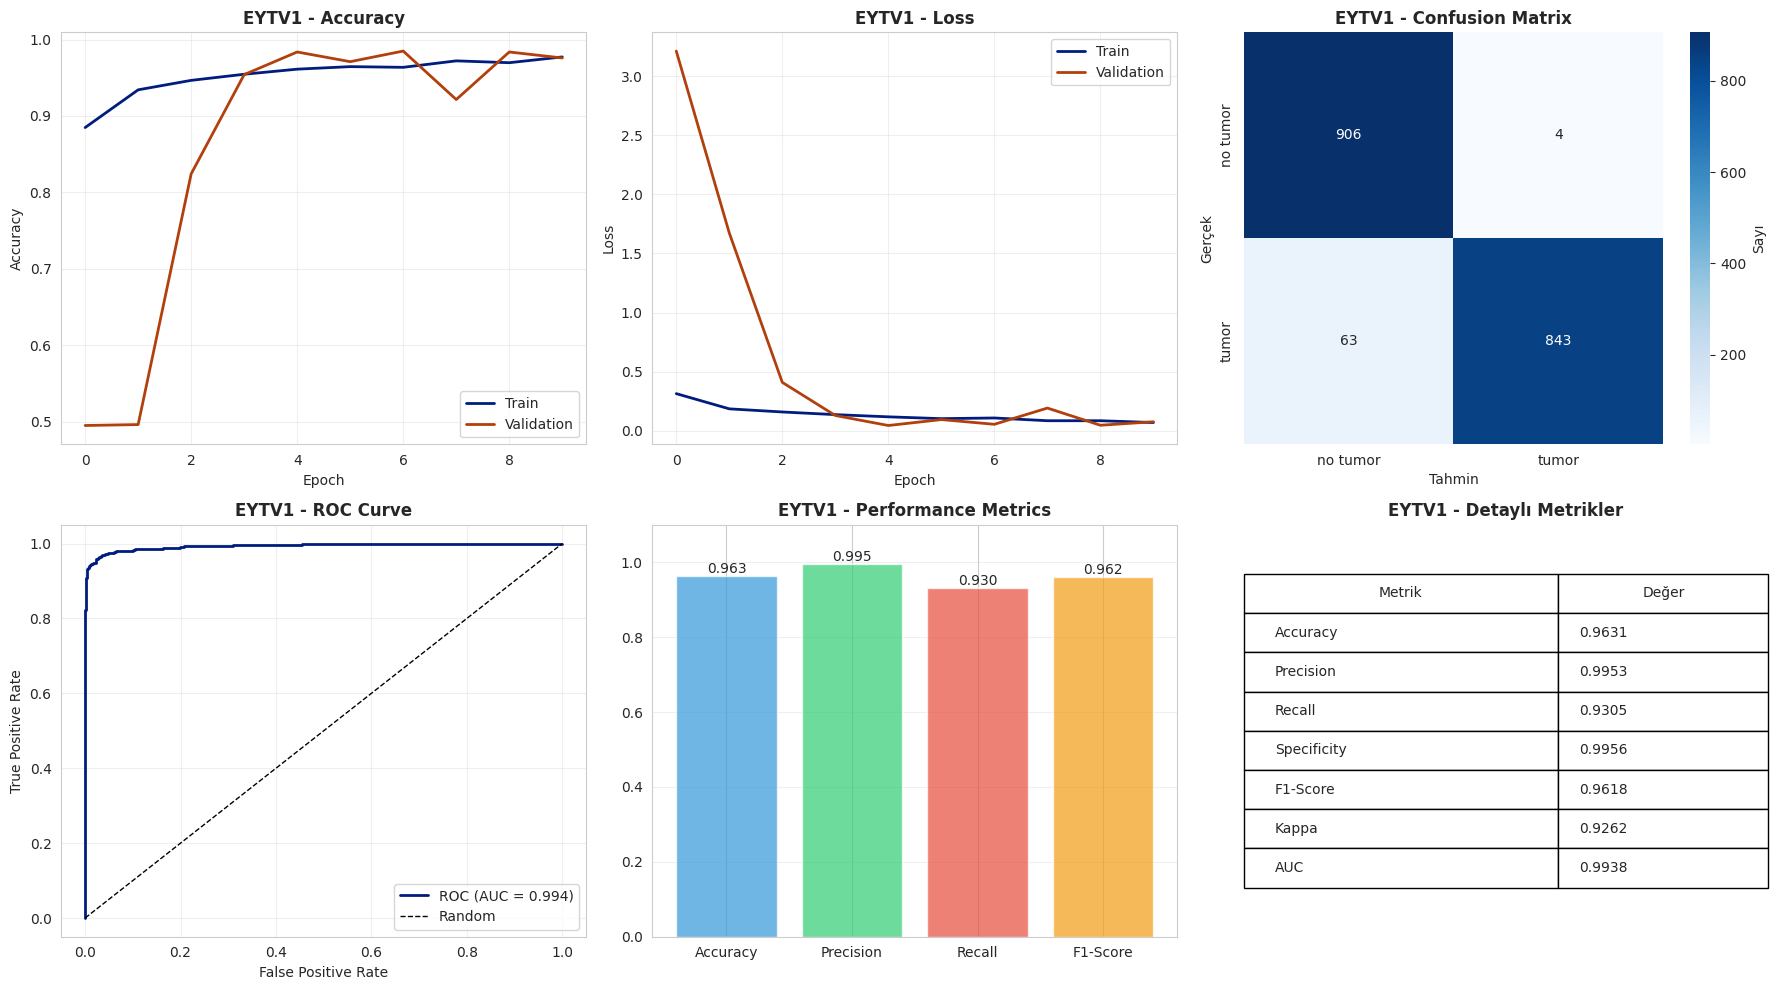

In [ ]:
# ==================== MODEL 5: METRİK HESAPLAMA (EYTV1) ====================
print("Öz CNN modeli (EYTV1) test verisi üzerinde değerlendiriliyor...")
# 1. Test jeneratörü (tf.data.Dataset) üzerinde TAHMİN yap
y_pred_prob_5 = custom_model_5.predict(test_generator, verbose=1)

# 2. Test jeneratöründen GERÇEK etiketleri (y_true) çek
y_true_5 = np.concatenate([labels for images, labels in test_generator], axis=0)

# 3. Yeni calculate_metrics fonksiyonunu çağır
# <--- GÜNCELLEME: Modelin adı "EYTV1" olarak değiştirildi.
custom_metrics_5, custom_cm_5, custom_roc_5 = calculate_metrics(
    y_true_5, y_pred_prob_5, 'EYTV1'
)

# 4. Ortalama epoch süresini metrik sözlüğüne ekle
custom_metrics_5['Avg. Epoch Time (s)'] = avg_epoch_time_5

# 5. plot_model_results fonksiyonunu çağır
# <--- GÜNCELLEME: Modelin adı "EYTV1" olarak değiştirildi.
plot_model_results(custom_history_5, custom_metrics_5, custom_cm_5,
                   custom_roc_5, 'EYTV1')

# 6. Model Tablosuna Kaydet
all_model_metrics.append(custom_metrics_5)

### **MODEL 6: KENDİ ÖZ CNN MODELİNİZ (EYTV2)**

In [ ]:
# ==================== MODEL 6: EYTV2 ====================
print("\n" + "=" * 80)
print("MODEL 6: EYTV2")

def create_eytv2_model():
    """
    Sıfırdan (from scratch) eğitilecek, aşırı öğrenmeyi engellemek için
    GlobalAveragePooling2D kullanan özelleştirilmiş bir CNN modeli oluşturur.
    """

    # 1. Giriş Katmanı (MR görüntümüzün şekli)
    input_layer = Input(shape=(224, 224, 1), name="input_image")

    # === BÖLÜM 1: ÖZELLİK ÇIKARICI (GÖZLER) ===
    # (EYTV1 ile aynı, sağlam VGG-tarzı mimari)

    # Blok 1
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # Boyut -> 112x112
    x = Dropout(0.25)(x)

    # Blok 2
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # Boyut -> 56x56
    x = Dropout(0.25)(x)

    # Blok 3
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # Boyut -> 28x28
    x = Dropout(0.25)(x)

    # === BÖLÜM 1'İN ÇIKTISI: (28, 28, 128) boyutunda bir özellik haritası ===


    # =========================================================================
    # === BÖLÜM 2: SINIFLANDIRICI (BEYİN) - OVERFITTING'E KARŞI GÜNCELLENDİ ===
    # =========================================================================
    # GÖREVİ: Özellik haritasını analiz etmek ve karar vermek.

    # <--- KRİTİK DEĞİŞİKLİK: 'Flatten()' DEĞİL, 'GlobalAveragePooling2D'
    # Bu, (28, 28, 128) haritasını 128 nöronluk bir vektöre indirger.
    # Parametre sayısını MİLYONLARDAN binlere düşürerek aşırı öğrenmeyi engeller.
    x = GlobalAveragePooling2D(name="eytv2_gap")(x)

    # Karar katmanları
    # (Artık 128 nöronla çalıştığımız için 512 yerine 256 nöron yeterlidir)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x) # Güçlü regülarizasyon

    # Çıkış katmanı
    output_layer = Dense(1, activation='sigmoid', name="output_layer_6")(x)

    # 6. Modeli Oluştur
    eytv2_model = Model(inputs=input_layer, outputs=output_layer, name="EYTV2")

    # Modeli derle
    eytv2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

    return eytv2_model

# EYTV2 modelinizi oluşturun ve özetini yazdırın
custom_model_6 = create_eytv2_model()
print(custom_model_6.summary())

# Zaman ölçümü için başlat
start_time_6 = time.time()

# EYTV2 modelini eğit
custom_history_6 = custom_model_6.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=get_callbacks('EYTV2'), # Model adı 'EYTV2' olarak kaydedilecek
    verbose=1
)

# Zaman ölçümünü bitir ve hesapla
end_time_6 = time.time()
total_time_6 = end_time_6 - start_time_6
actual_epochs_6 = len(custom_history_6.history['loss'])
avg_epoch_time_6 = total_time_6 / actual_epochs_6

print(f"Toplam Eğitim Süresi: {total_time_6:.2f} saniye")
print(f"Çalışan Epoch Sayısı: {actual_epochs_6}")
print(f"Epoch Başına Ortalama Süre: {avg_epoch_time_6:.2f} saniye")


MODEL 6: EYTV2


Model: "EYTV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ eytv2_gap                       │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 322,529 (1.23 MB)

 Trainable params: 321,121 (1.22 MB)

 Non-trainable params: 1,408 (5.50 KB)

None
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_EYTV2.h5
Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7631 - loss: 0.5463

207/207 ━━━━━━━━━━━━━━━━━━━━ 1671s 7s/step - accuracy: 0.7634 - loss: 0.5459 - val_accuracy: 0.4640 - val_loss: 0.8321 - learning_rate: 5.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.8836 - loss: 0.2898 - val_accuracy: 0.4713 - val_loss: 2.3427 - learning_rate: 5.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.9294 - loss: 0.1927 - val_accuracy: 0.4961 - val_loss: 2.9013 - learning_rate: 5.0000e-04
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9454 - loss: 0.1591

207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 189ms/step - accuracy: 0.9454 - loss: 0.1590 - val_accuracy: 0.7976 - val_loss: 0.4924 - learning_rate: 5.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.9564 - loss: 0.1196 - val_accuracy: 0.6647 - val_loss: 2.0792 - learning_rate: 5.0000e-04
Epoch 6/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 81s 183ms/step - accuracy: 0.9591 - loss: 0.1225 - val_accuracy: 0.8236 - val_loss: 0.7843 - learning_rate: 5.0000e-04
Epoch 7/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9643 - loss: 0.0989

207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 188ms/step - accuracy: 0.9643 - loss: 0.0990 - val_accuracy: 0.8749 - val_loss: 0.2958 - learning_rate: 5.0000e-04
Epoch 8/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9574 - loss: 0.1147

207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.9574 - loss: 0.1147 - val_accuracy: 0.9674 - val_loss: 0.1125 - learning_rate: 5.0000e-04
Epoch 9/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.9688 - loss: 0.0951 - val_accuracy: 0.9287 - val_loss: 0.2230 - learning_rate: 5.0000e-04
Epoch 10/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9669 - loss: 0.0952

207/207 ━━━━━━━━━━━━━━━━━━━━ 47s 209ms/step - accuracy: 0.9669 - loss: 0.0952 - val_accuracy: 0.9722 - val_loss: 0.0777 - learning_rate: 5.0000e-04
Epoch 11/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 45s 203ms/step - accuracy: 0.9728 - loss: 0.0836 - val_accuracy: 0.9722 - val_loss: 0.0935 - learning_rate: 5.0000e-04
Epoch 12/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9777 - loss: 0.0684

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.9776 - loss: 0.0684 - val_accuracy: 0.9813 - val_loss: 0.0726 - learning_rate: 5.0000e-04
Epoch 13/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.9751 - loss: 0.0736 - val_accuracy: 0.9686 - val_loss: 0.0750 - learning_rate: 5.0000e-04
Epoch 14/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9771 - loss: 0.0757

207/207 ━━━━━━━━━━━━━━━━━━━━ 47s 209ms/step - accuracy: 0.9771 - loss: 0.0756 - val_accuracy: 0.9789 - val_loss: 0.0544 - learning_rate: 5.0000e-04
Epoch 15/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.9785 - loss: 0.0692 - val_accuracy: 0.8218 - val_loss: 0.4475 - learning_rate: 5.0000e-04
Epoch 16/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.9807 - loss: 0.0667 - val_accuracy: 0.9758 - val_loss: 0.0763 - learning_rate: 5.0000e-04
Epoch 17/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9840 - loss: 0.0538
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.9840 - loss: 0.0538 - val_accuracy: 0.8737 - val_loss: 0.3491 - learning_rate: 5.0000e-04
Epoch 18/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.9838 - loss: 0.0569 - val_accuracy: 0.9873 - val_loss: 0.0564 - learning_rate: 2.5000e-04
Epoch 19/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - a

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.9836 - loss: 0.0508 - val_accuracy: 0.9897 - val_loss: 0.0502 - learning_rate: 2.5000e-04
Epoch 20/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 179ms/step - accuracy: 0.9840 - loss: 0.0527 - val_accuracy: 0.9625 - val_loss: 0.1800 - learning_rate: 2.5000e-04
Epoch 21/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9878 - loss: 0.0375

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.9878 - loss: 0.0375 - val_accuracy: 0.9891 - val_loss: 0.0324 - learning_rate: 2.5000e-04
Epoch 22/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.9883 - loss: 0.0417 - val_accuracy: 0.9855 - val_loss: 0.0498 - learning_rate: 2.5000e-04
Epoch 23/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.9858 - loss: 0.0458 - val_accuracy: 0.9891 - val_loss: 0.0484 - learning_rate: 2.5000e-04
Epoch 24/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9861 - loss: 0.0440

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.9861 - loss: 0.0440 - val_accuracy: 0.9909 - val_loss: 0.0255 - learning_rate: 2.5000e-04
Epoch 25/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 179ms/step - accuracy: 0.9876 - loss: 0.0398 - val_accuracy: 0.9710 - val_loss: 0.1033 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 24.
Toplam Eğitim Süresi: 2709.02 saniye
Çalışan Epoch Sayısı: 25
Epoch Başına Ortalama Süre: 108.36 saniye


EYTV2 modeli test verisi üzerinde değerlendiriliyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 673s 12s/step


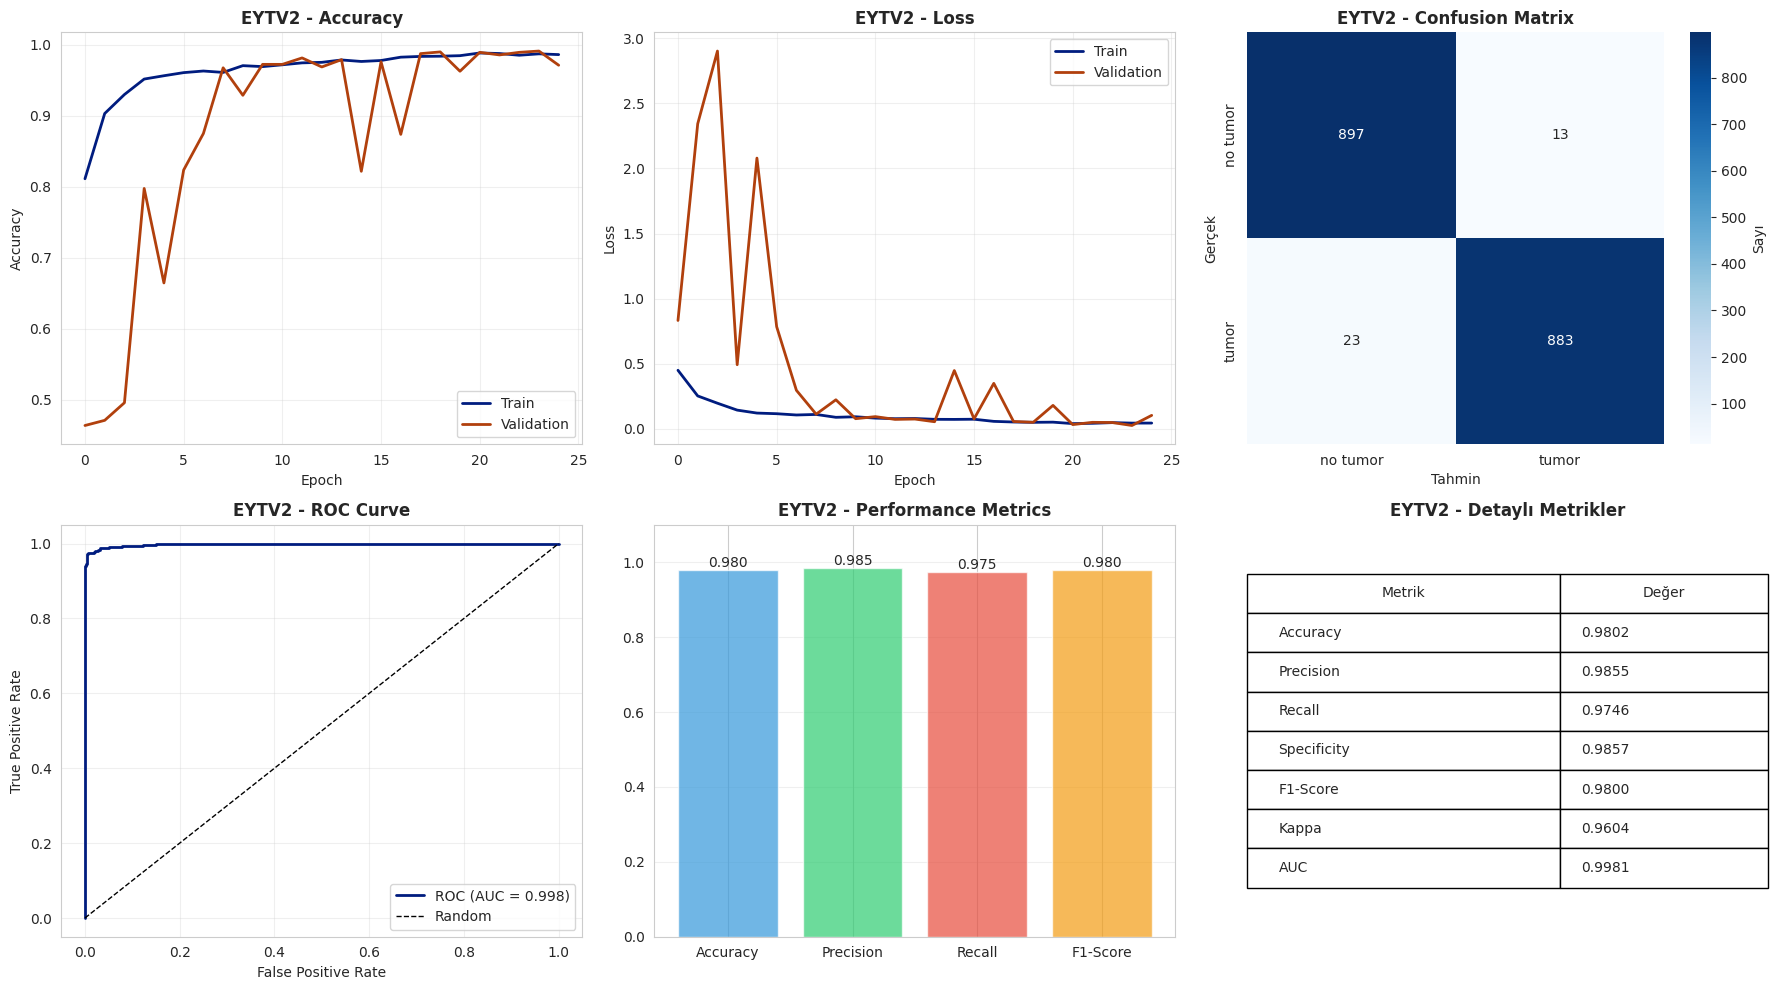

In [ ]:
# ==================== MODEL 6: METRİK HESAPLAMA (EYTV2) ====================
print("EYTV2 modeli test verisi üzerinde değerlendiriliyor...")
# 1. Test jeneratörü (tf.data.Dataset) üzerinde TAHMİN yap
y_pred_prob_6 = custom_model_6.predict(test_generator, verbose=1)

# 2. Test jeneratörü (tf.data.Dataset) üzerinden GERÇEK etiketleri (y_true) çek
y_true_6 = np.concatenate([labels for images, labels in test_generator], axis=0)

# 3. Yeni calculate_metrics fonksiyonunu çağır
custom_metrics_6, custom_cm_6, custom_roc_6 = calculate_metrics(
    y_true_6, y_pred_prob_6, 'EYTV2'
)

# 4. Ortalama epoch süresini metrik sözlüğüne ekle
custom_metrics_6['Avg. Epoch Time (s)'] = avg_epoch_time_6

# 5. plot_model_results fonksiyonunu çağır
plot_model_results(custom_history_6, custom_metrics_6, custom_cm_6,
                   custom_roc_6, 'EYTV2')

# 6. Model Tablosuna Kaydet
all_model_metrics.append(custom_metrics_6)

### **MODEL 7: KENDİ ÖZ CNN MODELİNİZ (EYTV3)**

In [ ]:
# ==================== MODEL 7: EYTV3 (Özelleştirilmiş ResNet-Tipi Model) ====================
print("\n" + "=" * 80)
print("MODEL 7: EYTV3 (Sizin Öz 'Residual' CNN Modeliniz)")
print("=" * 80)

# --- EYTV3 için 'Residual Block' yardımcı fonksiyonları ---

def identity_block(input_tensor, filters):
    """
    Bir 'Identity Block' (kimlik bloğu) oluşturur.
    Giriş ve çıkış boyutları aynıdır.
    """
    x = layers.Conv2D(filters, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Girdiyi (skip connection) doğrudan çıktıya ekle
    x = layers.Add()([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, filters, s=2):
    """
    Bir 'Convolutional Block' (evrişim bloğu) oluşturur.
    Boyut küçültmek (stride=s) veya filtre sayısını değiştirmek için kullanılır.
    """
    # Ana yol (main path)
    x = layers.Conv2D(filters, (3, 3), strides=(s, s), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Kestirme yol (shortcut path)
    # Boyutların eşleşmesi için 1x1 Conv ve 's' stride kullanılır
    shortcut = layers.Conv2D(filters, (1, 1), strides=(s, s), padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    # Girdiyi (skip connection) çıktıya ekle
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# --- EYTV3 Modelinin oluşturulması ---

def create_eytv3_model():
    """
    Sıfırdan (from scratch) eğitilecek, 'Residual' bloklara sahip
    derin bir CNN modeli (EYTV3) oluşturur.
    """

    input_layer = Input(shape=(224, 224, 1), name="input_image")

    # === BÖLÜM 1: GİRİŞ BLOĞU (STEM) ===
    # Görüntüyü ilk işleme ve boyut küçültme
    x = layers.Conv2D(32, (7, 7), strides=(2, 2), padding='same')(input_layer) # 224 -> 112
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x) # 112 -> 56

    # === BÖLÜM 2: ÖZELLİK ÇIKARICI (RESIDUAL BLOKLAR) ===

    # Blok 1 (Boyut küçültür: 56->28, Filtre artar: 32->64)
    x = conv_block(x, filters=64, s=2)
    x = identity_block(x, filters=64) # Boyut/Filtre değişmez

    # Blok 2 (Boyut küçültür: 28->14, Filtre artar: 64->128)
    x = conv_block(x, filters=128, s=2)
    x = identity_block(x, filters=128)

    # Blok 3 (Boyut küçültür: 14->7, Filtre artar: 128->256)
    x = conv_block(x, filters=256, s=2)
    x = identity_block(x, filters=256)

    # === BÖLÜM 3: SINIFLANDIRICI (BEYİN) ===
    # (EYTV2'de başarıyı getiren GAP mimarisini kullanıyoruz)
    x = layers.GlobalAveragePooling2D(name="eytv3_gap")(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    output_layer = layers.Dense(1, activation='sigmoid', name="output_layer_7")(x)

    # Modeli Oluştur
    eytv3_model = Model(inputs=input_layer, outputs=output_layer, name="EYTV3")

    # Modeli derle (Strateji 4: Daha düşük öğrenme oranı)
    eytv3_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

    return eytv3_model

# EYTV3 modelinizi oluşturun ve özetini yazdırın
custom_model_7 = create_eytv3_model()
print(custom_model_7.summary())

# Zaman ölçümü için başlat
start_time_7 = time.time()

# EYTV3 modelini eğit
custom_history_7 = custom_model_7.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=get_callbacks('EYTV3'), # Model adı 'EYTV3' olarak kaydedilecek
    verbose=1
)

# Zaman ölçümünü bitir ve hesapla
end_time_7 = time.time()
total_time_7 = end_time_7 - start_time_7
actual_epochs_7 = len(custom_history_7.history['loss'])
avg_epoch_time_7 = total_time_7 / actual_epochs_7

print(f"Toplam Eğitim Süresi: {total_time_7:.2f} saniye")
print(f"Çalışan Epoch Sayısı: {actual_epochs_7}")
print(f"Epoch Başına Ortalama Süre: {avg_epoch_time_7:.2f} saniye")


MODEL 7: EYTV3 (Sizin Öz 'Residual' CNN Modeliniz)


Model: "EYTV3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      1,600 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 28, 28,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 2,832,513 (10.81 MB)

 Trainable params: 2,827,457 (10.79 MB)

 Non-trainable params: 5,056 (19.75 KB)

None
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_EYTV3.h5
Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8088 - loss: 0.4640

207/207 ━━━━━━━━━━━━━━━━━━━━ 1306s 6s/step - accuracy: 0.8090 - loss: 0.4636 - val_accuracy: 0.4236 - val_loss: 0.7618 - learning_rate: 1.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 164ms/step - accuracy: 0.8951 - loss: 0.2747 - val_accuracy: 0.4526 - val_loss: 1.0516 - learning_rate: 1.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9301 - loss: 0.2017

207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 178ms/step - accuracy: 0.9301 - loss: 0.2017 - val_accuracy: 0.8073 - val_loss: 0.4888 - learning_rate: 1.0000e-04
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9378 - loss: 0.1633

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.9378 - loss: 0.1632 - val_accuracy: 0.9825 - val_loss: 0.0624 - learning_rate: 1.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 43s 192ms/step - accuracy: 0.9500 - loss: 0.1502 - val_accuracy: 0.9656 - val_loss: 0.1043 - learning_rate: 1.0000e-04
Epoch 6/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.9477 - loss: 0.1407 - val_accuracy: 0.9704 - val_loss: 0.1210 - learning_rate: 1.0000e-04
Epoch 7/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9611 - loss: 0.1137

207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 173ms/step - accuracy: 0.9611 - loss: 0.1138 - val_accuracy: 0.9831 - val_loss: 0.0608 - learning_rate: 1.0000e-04
Epoch 8/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 172ms/step - accuracy: 0.9593 - loss: 0.1100 - val_accuracy: 0.9782 - val_loss: 0.0729 - learning_rate: 1.0000e-04
Epoch 9/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.9704 - loss: 0.0807 - val_accuracy: 0.9136 - val_loss: 0.2065 - learning_rate: 1.0000e-04
Epoch 10/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9734 - loss: 0.0958

207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 190ms/step - accuracy: 0.9734 - loss: 0.0958 - val_accuracy: 0.9909 - val_loss: 0.0442 - learning_rate: 1.0000e-04
Epoch 11/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 167ms/step - accuracy: 0.9702 - loss: 0.0828 - val_accuracy: 0.9698 - val_loss: 0.1156 - learning_rate: 1.0000e-04
Epoch 12/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - accuracy: 0.9762 - loss: 0.0759 - val_accuracy: 0.9801 - val_loss: 0.0661 - learning_rate: 1.0000e-04
Epoch 13/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9788 - loss: 0.0502
Epoch 13: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.9788 - loss: 0.0503 - val_accuracy: 0.9263 - val_loss: 0.2368 - learning_rate: 1.0000e-04
Epoch 14/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 190ms/step - accuracy: 0.9843 - loss: 0.0524 - val_accuracy: 0.9656 - val_loss: 0.0986 - learning_rate: 5.0000e-05
Epoch 15/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - a

207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 178ms/step - accuracy: 0.9858 - loss: 0.0445 - val_accuracy: 0.9921 - val_loss: 0.0294 - learning_rate: 5.0000e-05
Epoch 16/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 173ms/step - accuracy: 0.9855 - loss: 0.0454 - val_accuracy: 0.9915 - val_loss: 0.0302 - learning_rate: 5.0000e-05
Epoch 17/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.9890 - loss: 0.0345 - val_accuracy: 0.9921 - val_loss: 0.0357 - learning_rate: 5.0000e-05
Epoch 18/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9909 - loss: 0.0283
Epoch 18: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - accuracy: 0.9909 - loss: 0.0283 - val_accuracy: 0.9903 - val_loss: 0.0315 - learning_rate: 5.0000e-05
Epoch 19/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - accuracy: 0.9902 - loss: 0.0279 - val_accuracy: 0.9909 - val_loss: 0.0326 - learning_rate: 2.5000e-05
Epoch 20/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - a

207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 167ms/step - accuracy: 0.9908 - loss: 0.0290 - val_accuracy: 0.9921 - val_loss: 0.0284 - learning_rate: 2.5000e-05
Epoch 21/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - accuracy: 0.9928 - loss: 0.0245 - val_accuracy: 0.9891 - val_loss: 0.0371 - learning_rate: 2.5000e-05
Epoch 22/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9936 - loss: 0.0208

207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - accuracy: 0.9936 - loss: 0.0208 - val_accuracy: 0.9921 - val_loss: 0.0277 - learning_rate: 2.5000e-05
Epoch 23/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - accuracy: 0.9895 - loss: 0.0385 - val_accuracy: 0.9915 - val_loss: 0.0278 - learning_rate: 2.5000e-05
Epoch 24/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9927 - loss: 0.0243

207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - accuracy: 0.9927 - loss: 0.0243 - val_accuracy: 0.9921 - val_loss: 0.0269 - learning_rate: 2.5000e-05
Epoch 25/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - accuracy: 0.9887 - loss: 0.0366 - val_accuracy: 0.9927 - val_loss: 0.0299 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 24.
Toplam Eğitim Süresi: 2237.40 saniye
Çalışan Epoch Sayısı: 25
Epoch Başına Ortalama Süre: 89.50 saniye


EYTV3 modeli test verisi üzerinde değerlendiriliyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 505s 9s/step


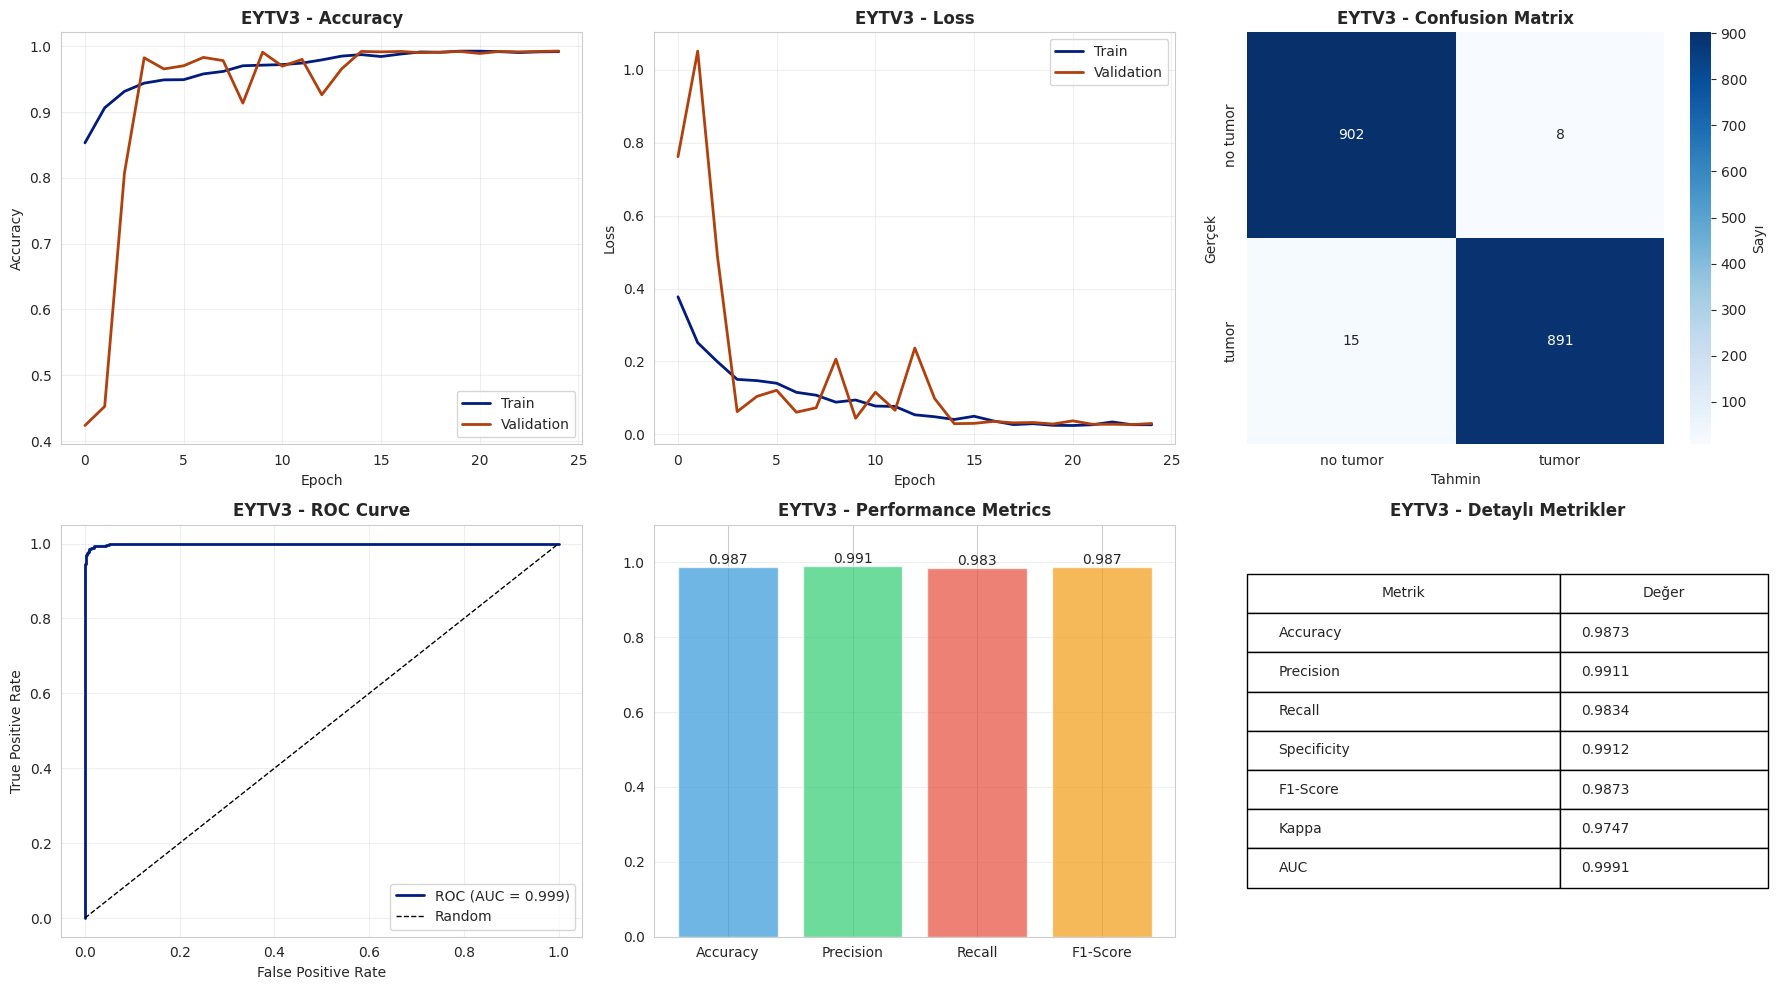

In [ ]:
# ==================== MODEL 7: METRİK HESAPLAMA (EYTV3) ====================
print("EYTV3 modeli test verisi üzerinde değerlendiriliyor...")
# 1. Test jeneratörü (tf.data.Dataset) üzerinde TAHMİN yap
y_pred_prob_7 = custom_model_7.predict(test_generator, verbose=1)

# 2. Test jeneratörü (tf.data.Dataset) üzerinden GERÇEK etiketleri (y_true) çek
y_true_7 = np.concatenate([labels for images, labels in test_generator], axis=0)

# 3. Yeni calculate_metrics fonksiyonunu çağır
custom_metrics_7, custom_cm_7, custom_roc_7 = calculate_metrics(
    y_true_7, y_pred_prob_7, 'EYTV3'
)

# 4. Ortalama epoch süresini metrik sözlüğüne ekle
custom_metrics_7['Avg. Epoch Time (s)'] = avg_epoch_time_7

# 5. plot_model_results fonksiyonunu çağır
plot_model_results(custom_history_7, custom_metrics_7, custom_cm_7,
                   custom_roc_7, 'EYTV3')

# 6. Model Tablosuna Kaydet
all_model_metrics.append(custom_metrics_7)

### **MODEL 8: KENDİ MODELİM (EYTV4)**

In [ ]:
# ==================== MODEL 7: EYTV4 (Özelleştirilmiş 'Attention' Modeli) ====================
print("\n" + "=" * 80)
print("MODEL 8: EYTV4")
print("=" * 80)

# Gerekli Keras backend'i (Focal Loss için)
from tensorflow.keras import backend as K

# --- EYTV4 için 'Attention Block' (Squeeze-and-Excite) yardımcı fonksiyonu ---
def se_block(input_tensor, ratio=16):
    """
    Bir 'Squeeze-and-Excite' (SE) bloğu oluşturur.
    Modele, hangi özellik haritalarının (kanalların) daha önemli
    olduğuna "dikkat" etmesini öğretir.
    """
    filters = input_tensor.shape[-1] # Gelen filtre sayısı
    se_shape = (1, 1, filters)

    # Squeeze (Sıkıştırma):
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)

    # Excitation (Uyarma):
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # Scale (Ölçekleme):
    # Orijinal girdiyi (input_tensor), öğrenilen "dikkat" ağırlıklarıyla (se) çarpar.
    x = layers.Multiply()([input_tensor, se])
    return x

# --- EYTV3'ün 'Attention' ile güncellenmiş blokları ---
def identity_block_with_se(input_tensor, filters):
    """
    EYTV3'ün Identity Bloğu + SE Dikkat Mekanizması
    """
    x = layers.Conv2D(filters, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, input_tensor])
    x = layers.Activation('relu')(x)
    x = se_block(x) # <--- DİKKAT MODÜLÜ EKLENDİ
    return x

def conv_block_with_se(input_tensor, filters, s=2):
    """
    EYTV3'ün Conv Bloğu + SE Dikkat Mekanizması
    """
    x = layers.Conv2D(filters, (3, 3), strides=(s, s), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(filters, (1, 1), strides=(s, s), padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = se_block(x) # <--- DİKKAT MODÜLÜ EKLENDİ
    return x

# --- Gelişmiş Kayıp Fonksiyonu (Focal Loss) ---
def focal_loss(gamma=2., alpha=.25):
    """
    'Zor' vakalara (örn. kaçırılan tümörler) odaklanan kayıp fonksiyonu.
    binary_crossentropy yerine kullanılır.
    """
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # klipsleme (clipping) ile log(0) hatasını önle
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

# --- EYTV4 Modelinin oluşturulması ---
def create_eytv4_model():
    """
    EYTV3 mimarisini temel alan, 'SE Attention' blokları
    ve 'Focal Loss' ile eğitilen model.
    """

    input_layer = Input(shape=(224, 224, 1), name="input_image")

    x = layers.Conv2D(32, (7, 7), strides=(2, 2), padding='same')(input_layer) # 224 -> 112
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x) # 112 -> 56

    # 'Attention'lı (SE) residual blokları kullan
    x = conv_block_with_se(x, filters=64, s=2) # 56 -> 28
    x = identity_block_with_se(x, filters=64)

    x = conv_block_with_se(x, filters=128, s=2) # 28 -> 14
    x = identity_block_with_se(x, filters=128)

    x = conv_block_with_se(x, filters=256, s=2) # 14 -> 7
    x = identity_block_with_se(x, filters=256)

    # Sınıflandırıcı (EYTV2/3'teki başarılı GAP mimarisi)
    x = layers.GlobalAveragePooling2D(name="eytv4_gap")(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(1, activation='sigmoid', name="output_layer_8")(x)

    eytv4_model = Model(inputs=input_layer, outputs=output_layer, name="EYTV4")

    # Modeli derle (Strateji 3: Focal Loss ve düşük öğrenme oranı)
    eytv4_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss=focal_loss(alpha=0.25, gamma=2.0),
                         metrics=['accuracy'])

    return eytv4_model

# EYTV4 modelinizi oluşturun ve özetini yazdırın
# (Değişken adını 'custom_model_8' olarak kullanıyoruz)
custom_model_8 = create_eytv4_model()
print(custom_model_8.summary())

# Zaman ölçümü için başlat
start_time_8 = time.time()

# EYTV4 modelini eğit
# (Değişken adını 'custom_history_8' olarak kullanıyoruz)
custom_history_8 = custom_model_8.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=get_callbacks('EYTV4'), # Model adı 'EYTV4' olarak kaydedilecek
    verbose=1
)

# Zaman ölçümünü bitir ve hesapla
end_time_8 = time.time()
total_time_8 = end_time_8 - start_time_8
actual_epochs_8 = len(custom_history_8.history['loss'])
avg_epoch_time_8 = total_time_8 / actual_epochs_8

print(f"Toplam Eğitim Süresi: {total_time_8:.2f} saniye")
print(f"Çalışan Epoch Sayısı: {actual_epochs_8}")
print(f"Epoch Başına Ortalama Süre: {avg_epoch_time_8:.2f} saniye")


MODEL 8: EYTV4


Model: "EYTV4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      1,600 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 28, 28,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ activation_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 4)   │        256 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,854,017 (10.89 MB)

 Trainable params: 2,848,961 (10.87 MB)

 Non-trainable params: 5,056 (19.75 KB)

None
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_EYTV4.h5
Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7369 - loss: 0.1251

207/207 ━━━━━━━━━━━━━━━━━━━━ 1227s 5s/step - accuracy: 0.7372 - loss: 0.1250 - val_accuracy: 0.6459 - val_loss: 0.0929 - learning_rate: 1.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.8436 - loss: 0.0725 - val_accuracy: 0.5541 - val_loss: 0.0969 - learning_rate: 1.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8742 - loss: 0.0484

207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 171ms/step - accuracy: 0.8743 - loss: 0.0484 - val_accuracy: 0.9517 - val_loss: 0.0149 - learning_rate: 1.0000e-04
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 166ms/step - accuracy: 0.8808 - loss: 0.0420 - val_accuracy: 0.9607 - val_loss: 0.0194 - learning_rate: 1.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9061 - loss: 0.0285

207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 167ms/step - accuracy: 0.9061 - loss: 0.0285 - val_accuracy: 0.9674 - val_loss: 0.0122 - learning_rate: 1.0000e-04
Epoch 6/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9077 - loss: 0.0261 - val_accuracy: 0.9692 - val_loss: 0.0158 - learning_rate: 1.0000e-04
Epoch 7/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9221 - loss: 0.0204

207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.9221 - loss: 0.0204 - val_accuracy: 0.9813 - val_loss: 0.0088 - learning_rate: 1.0000e-04
Epoch 8/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 161ms/step - accuracy: 0.9269 - loss: 0.0221 - val_accuracy: 0.9492 - val_loss: 0.0125 - learning_rate: 1.0000e-04
Epoch 9/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - accuracy: 0.9330 - loss: 0.0182 - val_accuracy: 0.9607 - val_loss: 0.0104 - learning_rate: 1.0000e-04
Epoch 10/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9402 - loss: 0.0179
Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 158ms/step - accuracy: 0.9403 - loss: 0.0179 - val_accuracy: 0.9505 - val_loss: 0.0109 - learning_rate: 1.0000e-04
Epoch 11/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9524 - loss: 0.0119

207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 189ms/step - accuracy: 0.9524 - loss: 0.0119 - val_accuracy: 0.9879 - val_loss: 0.0051 - learning_rate: 5.0000e-05
Epoch 12/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - accuracy: 0.9639 - loss: 0.0107 - val_accuracy: 0.9867 - val_loss: 0.0061 - learning_rate: 5.0000e-05
Epoch 13/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9631 - loss: 0.0093

207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.9631 - loss: 0.0093 - val_accuracy: 0.9873 - val_loss: 0.0044 - learning_rate: 5.0000e-05
Epoch 14/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - accuracy: 0.9674 - loss: 0.0096 - val_accuracy: 0.9813 - val_loss: 0.0073 - learning_rate: 5.0000e-05
Epoch 15/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 161ms/step - accuracy: 0.9703 - loss: 0.0083 - val_accuracy: 0.9758 - val_loss: 0.0056 - learning_rate: 5.0000e-05
Epoch 16/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9670 - loss: 0.0100
Epoch 16: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.9670 - loss: 0.0100 - val_accuracy: 0.9867 - val_loss: 0.0075 - learning_rate: 5.0000e-05
Epoch 17/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9705 - loss: 0.0078

207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 169ms/step - accuracy: 0.9705 - loss: 0.0078 - val_accuracy: 0.9891 - val_loss: 0.0042 - learning_rate: 2.5000e-05
Epoch 18/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - accuracy: 0.9794 - loss: 0.0061 - val_accuracy: 0.9867 - val_loss: 0.0044 - learning_rate: 2.5000e-05
Epoch 19/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.9785 - loss: 0.0066 - val_accuracy: 0.9891 - val_loss: 0.0059 - learning_rate: 2.5000e-05
Epoch 20/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9738 - loss: 0.0082
Epoch 20: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 158ms/step - accuracy: 0.9738 - loss: 0.0082 - val_accuracy: 0.9843 - val_loss: 0.0061 - learning_rate: 2.5000e-05
Epoch 21/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - accuracy: 0.9820 - loss: 0.0059 - val_accuracy: 0.9891 - val_loss: 0.0059 - learning_rate: 1.2500e-05
Epoch 22/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - a

207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 171ms/step - accuracy: 0.9853 - loss: 0.0046 - val_accuracy: 0.9903 - val_loss: 0.0040 - learning_rate: 1.2500e-05
Epoch 23/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 0.9834 - loss: 0.0052 - val_accuracy: 0.9909 - val_loss: 0.0044 - learning_rate: 1.2500e-05
Epoch 24/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9823 - loss: 0.0045

207/207 ━━━━━━━━━━━━━━━━━━━━ 43s 193ms/step - accuracy: 0.9823 - loss: 0.0045 - val_accuracy: 0.9909 - val_loss: 0.0036 - learning_rate: 1.2500e-05
Epoch 25/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.9841 - loss: 0.0049 - val_accuracy: 0.9909 - val_loss: 0.0043 - learning_rate: 1.2500e-05
Restoring model weights from the end of the best epoch: 24.
Toplam Eğitim Süresi: 2143.76 saniye
Çalışan Epoch Sayısı: 25
Epoch Başına Ortalama Süre: 85.75 saniye


EYTV4 modeli test verisi üzerinde TTA (Test-Time Augmentation) ile değerlendiriliyor...
TTA Adım 1/2: Orijinal görüntülerle tahmin yapılıyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 461s 8s/step

TTA Adım 2/2: Yatay çevrilmiş görüntülerle tahmin yapılıyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step

TTA tahminlerinin ortalaması alındı.


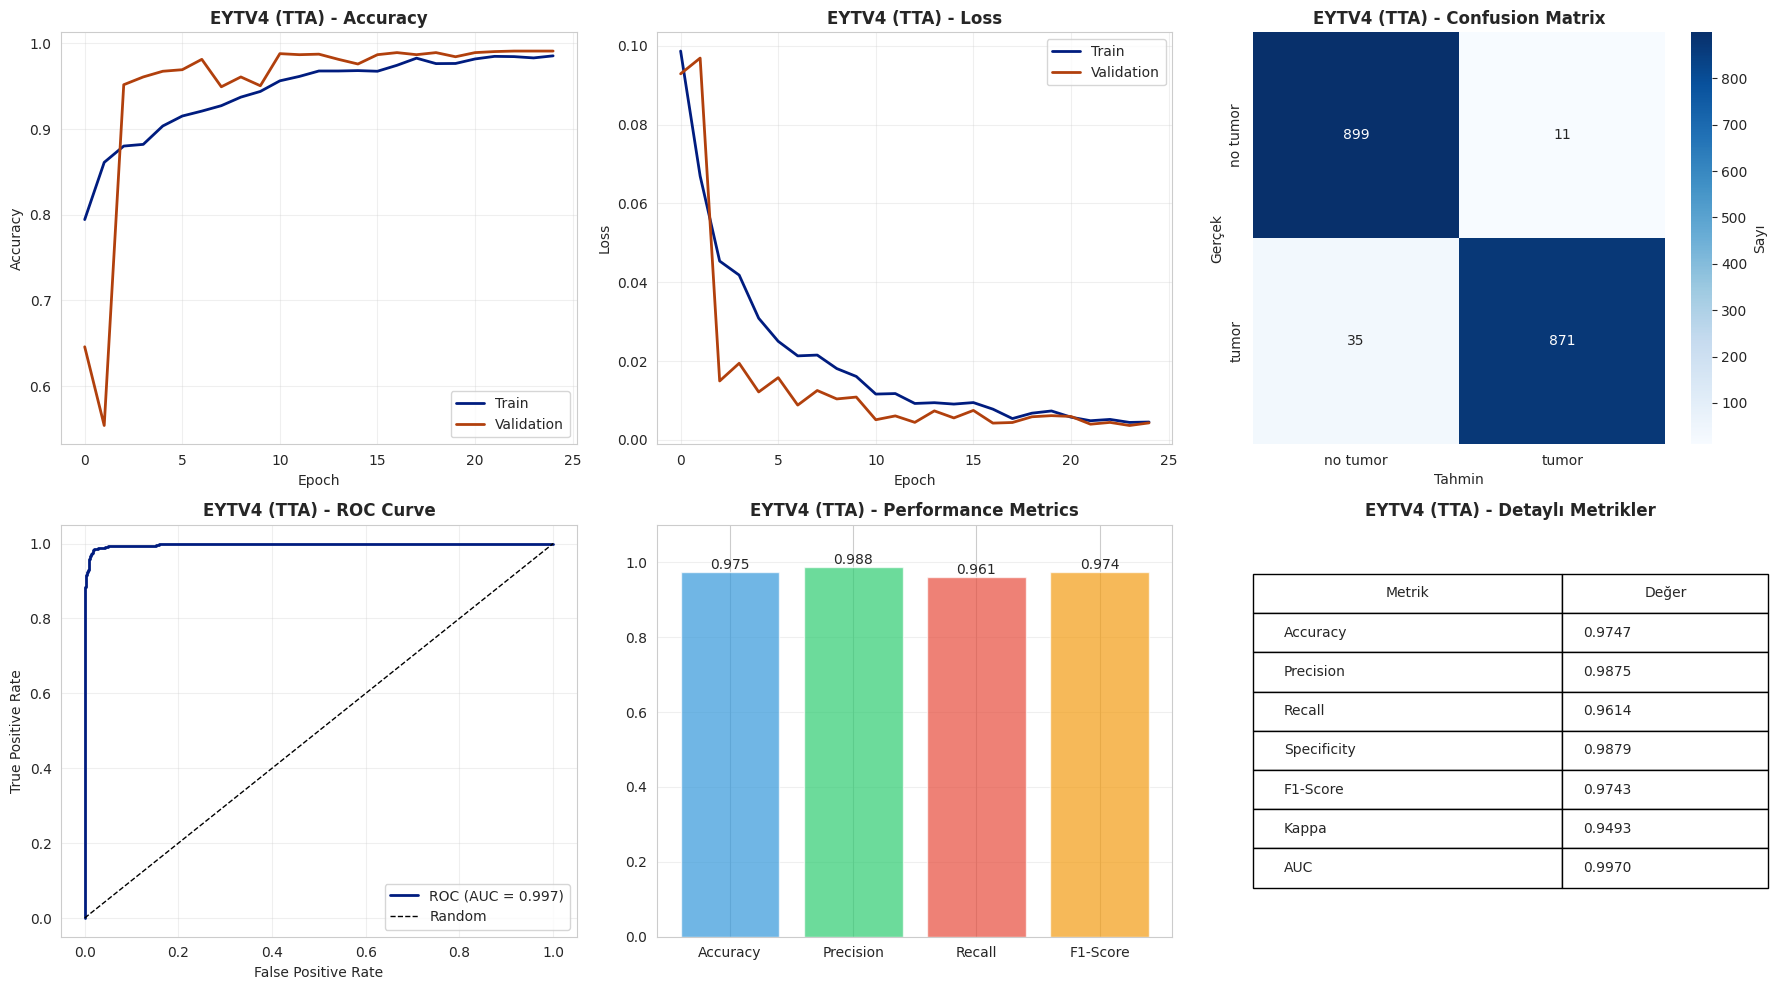

In [ ]:
# ==================== MODEL 7: METRİK HESAPLAMA (TTA ile EYTV4) ====================
print("EYTV4 modeli test verisi üzerinde TTA (Test-Time Augmentation) ile değerlendiriliyor...")
# (Bu hücre, bir önceki hücrede oluşturulan 'custom_model_8', 'custom_history_8'
# ve 'avg_epoch_time_8' değişkenlerinin hafızada olduğunu varsayar)

# --- TTA 1. Adım: Orijinal Görüntülerle Tahmin ---
print("TTA Adım 1/2: Orijinal görüntülerle tahmin yapılıyor...")
y_pred_original = custom_model_8.predict(test_generator, verbose=1)

# Gerçek etiketleri (y_true) SADECE BİR KEZ çekmemiz yeterli
y_true_8 = np.concatenate([labels for images, labels in test_generator], axis=0)

# --- TTA 2. Adım: Yatay Çevrilmiş (Flipped) Görüntülerle Tahmin ---

# TTA için deterministik (p=1.0 - her zaman çevir) bir transform oluştur
tta_flip_transform = A.Compose([
    A.HorizontalFlip(p=1.0), # p=1.0 -> Her zaman yatay çevir
    A.Normalize(mean=(0.0,), std=(1.0,), max_pixel_value=255.0),
])

# Bu TTA transformunu uygulayan yeni wrapper fonksiyonlar
def aug_tta_flip(image):
    aug_image = tta_flip_transform(image=image)['image']
    return aug_image.astype(np.float32)

def apply_tta_flip(image, label):
    aug_img = tf.numpy_function(func=aug_tta_flip, inp=[image], Tout=tf.float32)
    aug_img.set_shape([IMG_SIZE[0], IMG_SIZE[1], 1])
    return aug_img, label

# 'test_ds' (Hücre 4'te oluşturulan orijinal, batch'siz veri seti) üzerinden
# yeni bir 'Flipped Test Generator' oluştur
test_generator_tta_flip = (
    test_ds
    .map(apply_tta_flip, num_parallel_calls=AUTOTUNE) # Flipped aug uygula
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

print("\nTTA Adım 2/2: Yatay çevrilmiş görüntülerle tahmin yapılıyor...")
y_pred_flipped = custom_model_8.predict(test_generator_tta_flip, verbose=1)

# --- TTA 3. Adım: Tahminlerin Ortalamasını Alma ---
y_pred_prob_8 = (y_pred_original + y_pred_flipped) / 2.0
print("\nTTA tahminlerinin ortalaması alındı.")

# --- TTA 4. Adım: Nihai Metrikleri Hesaplama ---

model_name_tta = "EYTV4 (TTA)"

custom_metrics_8, custom_cm_8, custom_roc_8 = calculate_metrics(
    y_true_8, y_pred_prob_8, model_name_tta
)

# Ortalama epoch süresini metrik sözlüğüne ekle
custom_metrics_8['Avg. Epoch Time (s)'] = avg_epoch_time_8

# plot_model_results fonksiyonunu TTA'lı isimle çağır
plot_model_results(custom_history_8, custom_metrics_8, custom_cm_8,
                   custom_roc_8, model_name_tta)

# Model Tablosuna Kaydet
all_model_metrics.append(custom_metrics_8)

### **MODEL 9: KENDİ MODELİM (EYTV5)**

In [ ]:
# ==================== MODEL 9: EYTV5 (Attention + Binary Crossentropy) ====================
print("\n" + "=" * 80)
print("MODEL 9: EYTV5 (Sizin Öz 'Residual Attention' Modeliniz - Doğru Kayıp Fonk.)")
print("=" * 80)

# --- (EYTV4'ten Gelen Yardımcı Fonksiyonlar: se_block, identity_block_with_se, conv_block_with_se) ---
# (Bu fonksiyonlar bir önceki EYTV4 hücresinde zaten tanımlanmıştı,
# ancak bu hücrenin bağımsız çalışabilmesi için buraya tekrar ekliyoruz.)

def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = layers.Multiply()([input_tensor, se])
    return x

def identity_block_with_se(input_tensor, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_tensor])
    x = layers.Activation('relu')(x)
    x = se_block(x) # Dikkat Modülü
    return x

def conv_block_with_se(input_tensor, filters, s=2):
    x = layers.Conv2D(filters, (3, 3), strides=(s, s), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Conv2D(filters, (1, 1), strides=(s, s), padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = se_block(x) # Dikkat Modülü
    return x

# --- EYTV5 Modelinin oluşturulması ---
def create_eytv5_model():
    """
    EYTV3'ün başarılı mimarisini ve EYTV4'ün Attention bloklarını
    kullanan, ancak Focal Loss yerine 'binary_crossentropy' ile eğitilen model.
    """

    input_layer = Input(shape=(224, 224, 1), name="input_image")

    # Giriş Bloğu (Stem)
    x = layers.Conv2D(32, (7, 7), strides=(2, 2), padding='same')(input_layer) # 224 -> 112
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x) # 112 -> 56

    # 'Attention'lı (SE) residual blokları
    x = conv_block_with_se(x, filters=64, s=2) # 56 -> 28
    x = identity_block_with_se(x, filters=64)

    x = conv_block_with_se(x, filters=128, s=2) # 28 -> 14
    x = identity_block_with_se(x, filters=128)

    x = conv_block_with_se(x, filters=256, s=2) # 14 -> 7
    x = identity_block_with_se(x, filters=256)

    # Sınıflandırıcı (GAP Mimarisi)
    x = layers.GlobalAveragePooling2D(name="eytv5_gap")(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(1, activation='sigmoid', name="output_layer_9")(x)

    eytv5_model = Model(inputs=input_layer, outputs=output_layer, name="EYTV5")

    # <--- KRİTİK DEĞİŞİKLİK: 'Focal Loss' yerine 'binary_crossentropy'e geri dönüldü.
    eytv5_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

    return eytv5_model

# EYTV5 modelinizi oluşturun ve özetini yazdırın
custom_model_9 = create_eytv5_model()
print(custom_model_9.summary())

# Zaman ölçümü için başlat
start_time_9 = time.time()

# EYTV5 modelini eğit
custom_history_9 = custom_model_9.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=get_callbacks('EYTV5'), # Model adı 'EYTV5' olarak kaydedilecek
    verbose=1
)

# Zaman ölçümünü bitir ve hesapla
end_time_9 = time.time()
total_time_9 = end_time_9 - start_time_9
actual_epochs_9 = len(custom_history_9.history['loss'])
avg_epoch_time_9 = total_time_9 / actual_epochs_9

print(f"Toplam Eğitim Süresi: {total_time_9:.2f} saniye")
print(f"Çalışan Epoch Sayısı: {actual_epochs_9}")
print(f"Epoch Başına Ortalama Süre: {avg_epoch_time_9:.2f} saniye")


MODEL 9: EYTV5 (Sizin Öz 'Residual Attention' Modeliniz - Doğru Kayıp Fonk.)


Model: "EYTV5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      1,600 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 28, 28,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ activation_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 4)   │        256 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,854,017 (10.89 MB)

 Trainable params: 2,848,961 (10.87 MB)

 Non-trainable params: 5,056 (19.75 KB)

None
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_EYTV5.h5
Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7786 - loss: 0.5111 

207/207 ━━━━━━━━━━━━━━━━━━━━ 3171s 14s/step - accuracy: 0.7789 - loss: 0.5106 - val_accuracy: 0.4949 - val_loss: 0.8096 - learning_rate: 1.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 32s 138ms/step - accuracy: 0.8995 - loss: 0.2905 - val_accuracy: 0.4622 - val_loss: 0.9275 - learning_rate: 1.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9344 - loss: 0.1837

207/207 ━━━━━━━━━━━━━━━━━━━━ 32s 142ms/step - accuracy: 0.9343 - loss: 0.1838 - val_accuracy: 0.9650 - val_loss: 0.0947 - learning_rate: 1.0000e-04
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - accuracy: 0.9343 - loss: 0.1738 - val_accuracy: 0.8218 - val_loss: 0.4309 - learning_rate: 1.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - accuracy: 0.9491 - loss: 0.1454 - val_accuracy: 0.9601 - val_loss: 0.1161 - learning_rate: 1.0000e-04
Epoch 6/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9514 - loss: 0.1404

207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - accuracy: 0.9515 - loss: 0.1402 - val_accuracy: 0.9807 - val_loss: 0.0601 - learning_rate: 1.0000e-04
Epoch 7/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.9632 - loss: 0.1172 - val_accuracy: 0.9644 - val_loss: 0.1165 - learning_rate: 1.0000e-04
Epoch 8/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9652 - loss: 0.0998

207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - accuracy: 0.9652 - loss: 0.0998 - val_accuracy: 0.9837 - val_loss: 0.0498 - learning_rate: 1.0000e-04
Epoch 9/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - accuracy: 0.9689 - loss: 0.0882 - val_accuracy: 0.9656 - val_loss: 0.1058 - learning_rate: 1.0000e-04
Epoch 10/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 139ms/step - accuracy: 0.9719 - loss: 0.0931 - val_accuracy: 0.9462 - val_loss: 0.1580 - learning_rate: 1.0000e-04
Epoch 11/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9740 - loss: 0.0730

207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 145ms/step - accuracy: 0.9740 - loss: 0.0730 - val_accuracy: 0.9885 - val_loss: 0.0476 - learning_rate: 1.0000e-04
Epoch 12/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step - accuracy: 0.9756 - loss: 0.0719 - val_accuracy: 0.9837 - val_loss: 0.0484 - learning_rate: 1.0000e-04
Epoch 13/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.9780 - loss: 0.0661 - val_accuracy: 0.9867 - val_loss: 0.0486 - learning_rate: 1.0000e-04
Epoch 14/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9803 - loss: 0.0685
Epoch 14: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - accuracy: 0.9803 - loss: 0.0685 - val_accuracy: 0.9807 - val_loss: 0.0681 - learning_rate: 1.0000e-04
Epoch 15/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9853 - loss: 0.0483

207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 145ms/step - accuracy: 0.9853 - loss: 0.0483 - val_accuracy: 0.9855 - val_loss: 0.0471 - learning_rate: 5.0000e-05
Epoch 16/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9901 - loss: 0.0370

207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - accuracy: 0.9901 - loss: 0.0370 - val_accuracy: 0.9915 - val_loss: 0.0339 - learning_rate: 5.0000e-05
Epoch 17/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 32s 142ms/step - accuracy: 0.9905 - loss: 0.0342 - val_accuracy: 0.9897 - val_loss: 0.0373 - learning_rate: 5.0000e-05
Epoch 18/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - accuracy: 0.9867 - loss: 0.0349 - val_accuracy: 0.9903 - val_loss: 0.0354 - learning_rate: 5.0000e-05
Epoch 19/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9899 - loss: 0.0361

207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 145ms/step - accuracy: 0.9899 - loss: 0.0361 - val_accuracy: 0.9927 - val_loss: 0.0274 - learning_rate: 5.0000e-05
Epoch 20/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 32s 143ms/step - accuracy: 0.9901 - loss: 0.0343 - val_accuracy: 0.9915 - val_loss: 0.0386 - learning_rate: 5.0000e-05
Epoch 21/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - accuracy: 0.9944 - loss: 0.0267 - val_accuracy: 0.9897 - val_loss: 0.0417 - learning_rate: 5.0000e-05
Epoch 22/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9926 - loss: 0.0288
Epoch 22: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - accuracy: 0.9926 - loss: 0.0289 - val_accuracy: 0.9921 - val_loss: 0.0302 - learning_rate: 5.0000e-05
Epoch 23/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9883 - loss: 0.0367

207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 147ms/step - accuracy: 0.9884 - loss: 0.0366 - val_accuracy: 0.9927 - val_loss: 0.0272 - learning_rate: 2.5000e-05
Epoch 24/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9919 - loss: 0.0220

207/207 ━━━━━━━━━━━━━━━━━━━━ 34s 153ms/step - accuracy: 0.9919 - loss: 0.0220 - val_accuracy: 0.9940 - val_loss: 0.0252 - learning_rate: 2.5000e-05
Epoch 25/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - accuracy: 0.9925 - loss: 0.0235 - val_accuracy: 0.9927 - val_loss: 0.0296 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 24.
Toplam Eğitim Süresi: 3978.40 saniye
Çalışan Epoch Sayısı: 25
Epoch Başına Ortalama Süre: 159.14 saniye


EYTV5 modeli test verisi üzerinde değerlendiriliyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 704s 12s/step


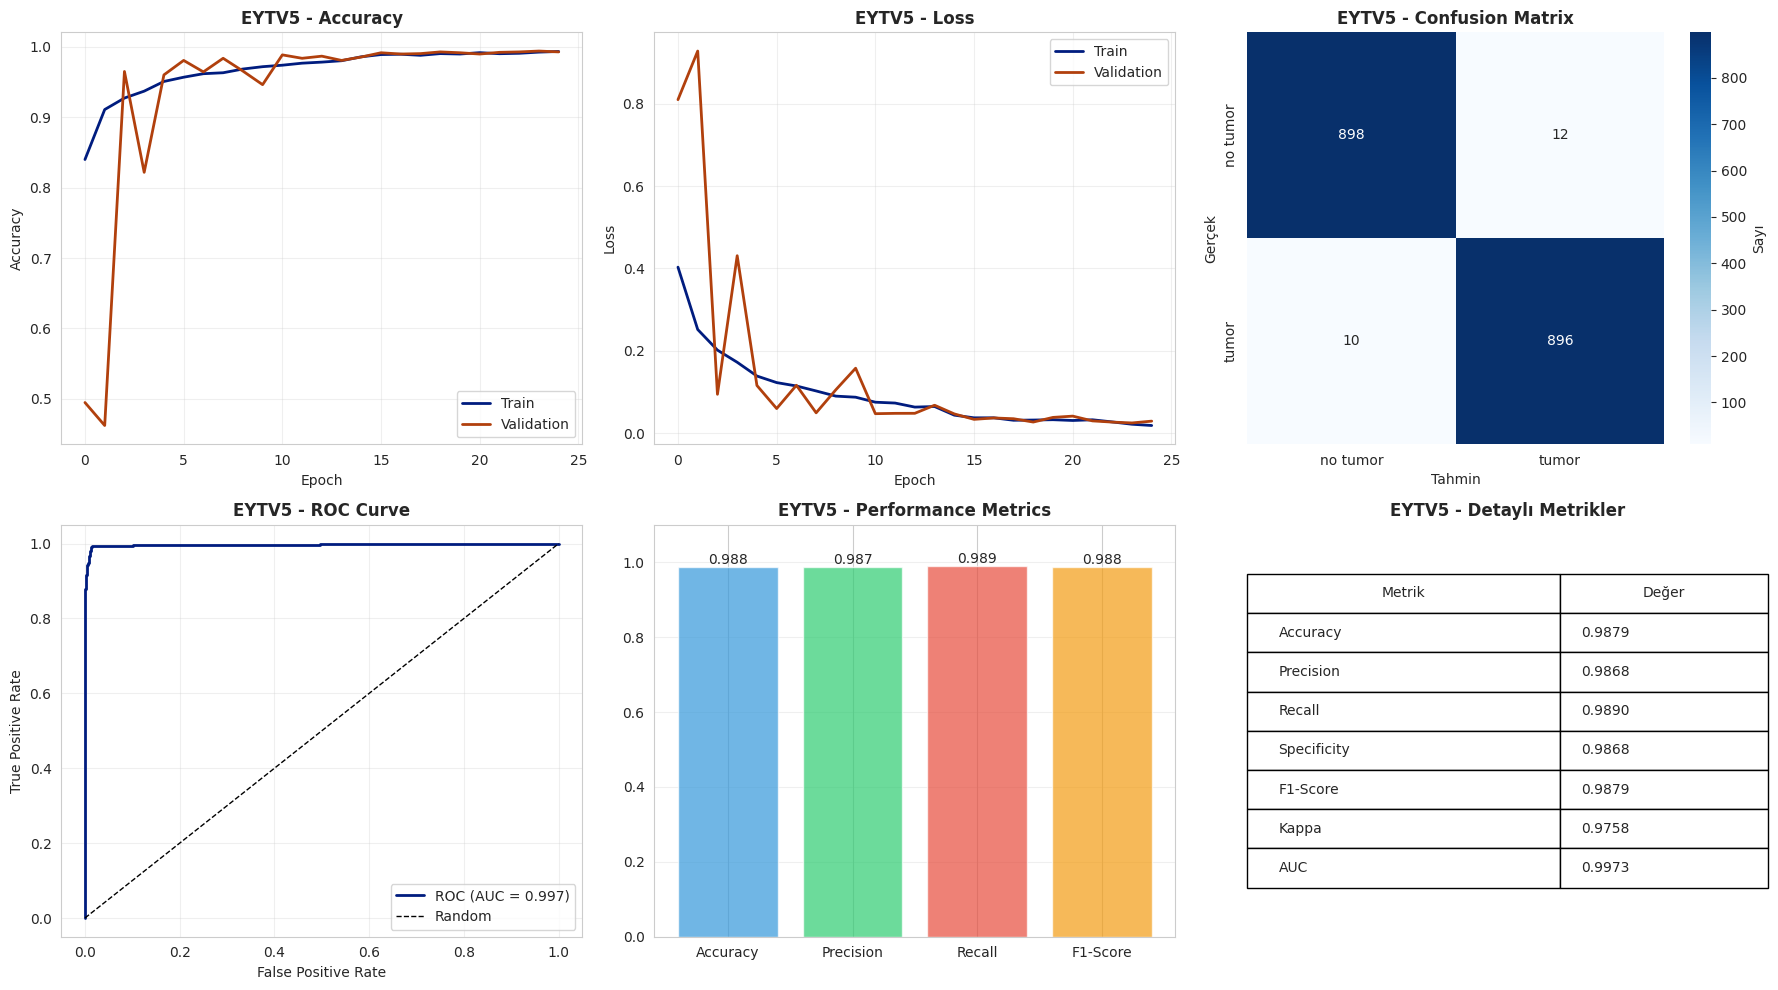

In [ ]:
# ==================== MODEL 9: METRİK HESAPLAMA (EYTV5) ====================
print("EYTV5 modeli test verisi üzerinde değerlendiriliyor...")
# 1. Test jeneratörü (tf.data.Dataset) üzerinde TAHMİN yap
y_pred_prob_9 = custom_model_9.predict(test_generator, verbose=1)

# 2. Test jeneratörü (tf.data.Dataset) üzerinden GERÇEK etiketleri (y_true) çek
y_true_9 = np.concatenate([labels for images, labels in test_generator], axis=0)

# 3. Yeni calculate_metrics fonksiyonunu çağır
custom_metrics_9, custom_cm_9, custom_roc_9 = calculate_metrics(
    y_true_9, y_pred_prob_9, 'EYTV5'
)

# 4. Ortalama epoch süresini metrik sözlüğüne ekle
custom_metrics_9['Avg. Epoch Time (s)'] = avg_epoch_time_9

# 5. plot_model_results fonksiyonunu çağır
plot_model_results(custom_history_9, custom_metrics_9, custom_cm_9,
                   custom_roc_9, 'EYTV5')

# 6. Model Tablosuna Kaydet
all_model_metrics.append(custom_metrics_9)

### **MODEL 10: KENDİ MODELİM (EYTV6)**

In [ ]:
# ==================== MODEL 10: EYTV6 (EfficientNet-Tipi Öz Model) ====================
print("\n" + "=" * 80)
print("MODEL 10: EYTV6 (Sizin Öz 'Efficient'-Tipi Modeliniz)")
print("=" * 80)

# --- (EYTV4/5'ten Gelen 'se_block' fonksiyonu EfficientNet'in temel taşıdır) ---
def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = layers.Multiply()([input_tensor, se])
    return x

# --- EYTV6 için 'MBConv' (EfficientNet Bloğu) yardımcı fonksiyonu ---
def mb_conv_block(input_tensor, input_filters, output_filters, expand_ratio, strides):
    """
    EfficientNet'in temel yapı taşı olan 'MBConv' bloğunu oluşturur.
    'Depthwise Separable Convolution' ve 'SE Attention' kullanır.
    """
    # 1. Genişletme (Expansion) Katmanı
    # Girdi filtre sayısını 'expand_ratio' ile çarpar (örn: 32 -> 192)
    expand_filters = input_filters * expand_ratio
    x = layers.Conv2D(expand_filters, (1, 1), padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x) # EfficientNet 'relu' yerine 'swish' kullanır

    # 2. Derinlemesine Evrişim (Depthwise Convolution)
    # Bu, standart Conv2D'den çok daha az parametreye sahip verimli katmandır.
    x = layers.DepthwiseConv2D((3, 3), strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # 3. Squeeze-and-Excite (SE) Bloğu (Attention)
    x = se_block(x)

    # 4. Projeksiyon (Projection) Katmanı
    # Filtre sayısını (örn: 192) istenen çıktı sayısına (örn: 32) düşürür
    x = layers.Conv2D(output_filters, (1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # 5. Kalıntı Bağlantısı (Residual Connection)
    # Sadece giriş ve çıkış boyutları aynıysa (stride=1) eklenir
    if strides == 1 and input_filters == output_filters:
        x = layers.Add()([input_tensor, x]) # EYTV3'teki gibi

    return x

# --- EYTV6 Modelinin oluşturulması ---
def create_eytv6_model():
    """
    Sıfırdan (from scratch) eğitilecek, 'MBConv' bloklarına sahip
    EfficientNet-tipi bir model (EYTV6) oluşturur.
    """

    input_layer = Input(shape=(224, 224, 1), name="input_image")

    # === BÖLÜM 1: GİRİŞ BLOĞU (STEM) ===
    # 1 kanaldan 32 filtreye
    x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(input_layer) # 224 -> 112
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # === BÖLÜM 2: ÖZELLİK ÇIKARICI (MBCONV BLOKLARI) ===
    # (EfficientNet-B0'ın mimarisinden esinlenilmiştir)

    # Blok 1 (Filtreler: 32 -> 16, Boyut: 112 -> 112)
    x = mb_conv_block(x, input_filters=32, output_filters=16, expand_ratio=1, strides=1)

    # Blok 2 (Filtreler: 16 -> 24, Boyut: 112 -> 56)
    x = mb_conv_block(x, input_filters=16, output_filters=24, expand_ratio=6, strides=2)
    x = mb_conv_block(x, input_filters=24, output_filters=24, expand_ratio=6, strides=1)

    # Blok 3 (Filtreler: 24 -> 40, Boyut: 56 -> 28)
    x = mb_conv_block(x, input_filters=24, output_filters=40, expand_ratio=6, strides=2)
    x = mb_conv_block(x, input_filters=40, output_filters=40, expand_ratio=6, strides=1)

    # Blok 4 (Filtreler: 40 -> 80, Boyut: 28 -> 14)
    x = mb_conv_block(x, input_filters=40, output_filters=80, expand_ratio=6, strides=2)
    x = mb_conv_block(x, input_filters=80, output_filters=80, expand_ratio=6, strides=1)

    # Blok 5 (Filtreler: 80 -> 112, Boyut: 14 -> 7)
    x = mb_conv_block(x, input_filters=80, output_filters=112, expand_ratio=6, strides=2)

    # === BÖLÜM 3: SINIFLANDIRICI (BEYİN) ===
    x = layers.GlobalAveragePooling2D(name="eytv6_gap")(x)
    x = layers.Dense(256, activation='relu')(x) # EYTV3'teki sınıflandırıcı
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(1, activation='sigmoid', name="output_layer_10")(x)

    eytv6_model = Model(inputs=input_layer, outputs=output_layer, name="EYTV6")

    # Modeli derle (EYTV3'ün başarılı parametreleriyle)
    eytv6_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

    return eytv6_model

# EYTV6 modelinizi oluşturun ve özetini yazdırın
custom_model_10 = create_eytv6_model()
print(custom_model_10.summary())

# Zaman ölçümü için başlat
start_time_10 = time.time()

# EYTV6 modelini eğit
custom_history_10 = custom_model_10.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=get_callbacks('EYTV6'), # Model adı 'EYTV6' olarak kaydedilecek
    verbose=1
)

# Zaman ölçümünü bitir ve hesapla
end_time_10 = time.time()
total_time_10 = end_time_10 - start_time_10
actual_epochs_10 = len(custom_history_10.history['loss'])
avg_epoch_time_10 = total_time_10 / actual_epochs_10

print(f"Toplam Eğitim Süresi: {total_time_10:.2f} saniye")
print(f"Çalışan Epoch Sayısı: {actual_epochs_10}")
print(f"Epoch Başına Ortalama Süre: {avg_epoch_time_10:.2f} saniye")


MODEL 10: EYTV6 (Sizin Öz 'Efficient'-Tipi Modeliniz)


Model: "EYTV6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 112, 112,  │        288 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 112, 112,  │      1,024 │ activation_13[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 112, 112,  │        288 │ activation_14[0]… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ activation_15[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1, 1, 2)   │         64 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1, 1, 32)  │         64 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 112, 112,  │          0 │ activation_15[0]… │
│ (Multiply)          │ 32)               │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 112, 112,  │        512 │ multiply_6[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 112, 112,  │      1,536 │ batch_normalizat

 Total params: 380,769 (1.45 MB)

 Trainable params: 371,937 (1.42 MB)

 Non-trainable params: 8,832 (34.50 KB)

None
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_EYTV6.h5
Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.6813 - loss: 0.6599

207/207 ━━━━━━━━━━━━━━━━━━━━ 116s 346ms/step - accuracy: 0.6815 - loss: 0.6596 - val_accuracy: 0.4949 - val_loss: 0.7054 - learning_rate: 1.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7855 - loss: 0.5243

207/207 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.7856 - loss: 0.5241 - val_accuracy: 0.4949 - val_loss: 0.6929 - learning_rate: 1.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8435 - loss: 0.3955

207/207 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - accuracy: 0.8435 - loss: 0.3954 - val_accuracy: 0.7867 - val_loss: 0.4996 - learning_rate: 1.0000e-04
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8590 - loss: 0.3571

207/207 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - accuracy: 0.8591 - loss: 0.3570 - val_accuracy: 0.8665 - val_loss: 0.3026 - learning_rate: 1.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8882 - loss: 0.2869

207/207 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - accuracy: 0.8883 - loss: 0.2868 - val_accuracy: 0.9547 - val_loss: 0.1241 - learning_rate: 1.0000e-04
Epoch 6/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 32s 142ms/step - accuracy: 0.9180 - loss: 0.2239 - val_accuracy: 0.9360 - val_loss: 0.1493 - learning_rate: 1.0000e-04
Epoch 7/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9152 - loss: 0.2213

207/207 ━━━━━━━━━━━━━━━━━━━━ 43s 153ms/step - accuracy: 0.9153 - loss: 0.2212 - val_accuracy: 0.9692 - val_loss: 0.0908 - learning_rate: 1.0000e-04
Epoch 8/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - accuracy: 0.9256 - loss: 0.2036 - val_accuracy: 0.9492 - val_loss: 0.1531 - learning_rate: 1.0000e-04
Epoch 9/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9326 - loss: 0.1936

207/207 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.9326 - loss: 0.1936 - val_accuracy: 0.9795 - val_loss: 0.0807 - learning_rate: 1.0000e-04
Epoch 10/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - accuracy: 0.9368 - loss: 0.1836 - val_accuracy: 0.9541 - val_loss: 0.1250 - learning_rate: 1.0000e-04
Epoch 11/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - accuracy: 0.9380 - loss: 0.1647 - val_accuracy: 0.9414 - val_loss: 0.1445 - learning_rate: 1.0000e-04
Epoch 12/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9420 - loss: 0.1629
Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.9420 - loss: 0.1629 - val_accuracy: 0.9662 - val_loss: 0.1066 - learning_rate: 1.0000e-04
Epoch 13/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9508 - loss: 0.1355

207/207 ━━━━━━━━━━━━━━━━━━━━ 43s 160ms/step - accuracy: 0.9508 - loss: 0.1355 - val_accuracy: 0.9789 - val_loss: 0.0651 - learning_rate: 5.0000e-05
Epoch 14/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step - accuracy: 0.9515 - loss: 0.1342 - val_accuracy: 0.9589 - val_loss: 0.1228 - learning_rate: 5.0000e-05
Epoch 15/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 147ms/step - accuracy: 0.9452 - loss: 0.1557 - val_accuracy: 0.9776 - val_loss: 0.0662 - learning_rate: 5.0000e-05
Epoch 16/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9548 - loss: 0.1262
Epoch 16: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 145ms/step - accuracy: 0.9548 - loss: 0.1262 - val_accuracy: 0.9686 - val_loss: 0.0812 - learning_rate: 5.0000e-05
Epoch 17/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9569 - loss: 0.1258

207/207 ━━━━━━━━━━━━━━━━━━━━ 34s 156ms/step - accuracy: 0.9569 - loss: 0.1258 - val_accuracy: 0.9843 - val_loss: 0.0538 - learning_rate: 2.5000e-05
Epoch 18/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 143ms/step - accuracy: 0.9612 - loss: 0.1134 - val_accuracy: 0.9837 - val_loss: 0.0564 - learning_rate: 2.5000e-05
Epoch 19/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9617 - loss: 0.1078

207/207 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.9617 - loss: 0.1078 - val_accuracy: 0.9861 - val_loss: 0.0513 - learning_rate: 2.5000e-05
Epoch 20/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - accuracy: 0.9586 - loss: 0.1184 - val_accuracy: 0.9867 - val_loss: 0.0528 - learning_rate: 2.5000e-05
Epoch 21/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9551 - loss: 0.1167

207/207 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - accuracy: 0.9551 - loss: 0.1167 - val_accuracy: 0.9891 - val_loss: 0.0464 - learning_rate: 2.5000e-05
Epoch 22/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 147ms/step - accuracy: 0.9637 - loss: 0.1068 - val_accuracy: 0.9873 - val_loss: 0.0474 - learning_rate: 2.5000e-05
Epoch 23/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - accuracy: 0.9602 - loss: 0.1116 - val_accuracy: 0.9867 - val_loss: 0.0493 - learning_rate: 2.5000e-05
Epoch 24/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9602 - loss: 0.1258
Epoch 24: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - accuracy: 0.9602 - loss: 0.1258 - val_accuracy: 0.9861 - val_loss: 0.0470 - learning_rate: 2.5000e-05
Epoch 25/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 32s 145ms/step - accuracy: 0.9633 - loss: 0.1011 - val_accuracy: 0.9867 - val_loss: 0.0490 - learning_rate: 1.2500e-05
Restoring model weights from the end of the best epoch: 21

EYTV6 modeli test verisi üzerinde değerlendiriliyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step


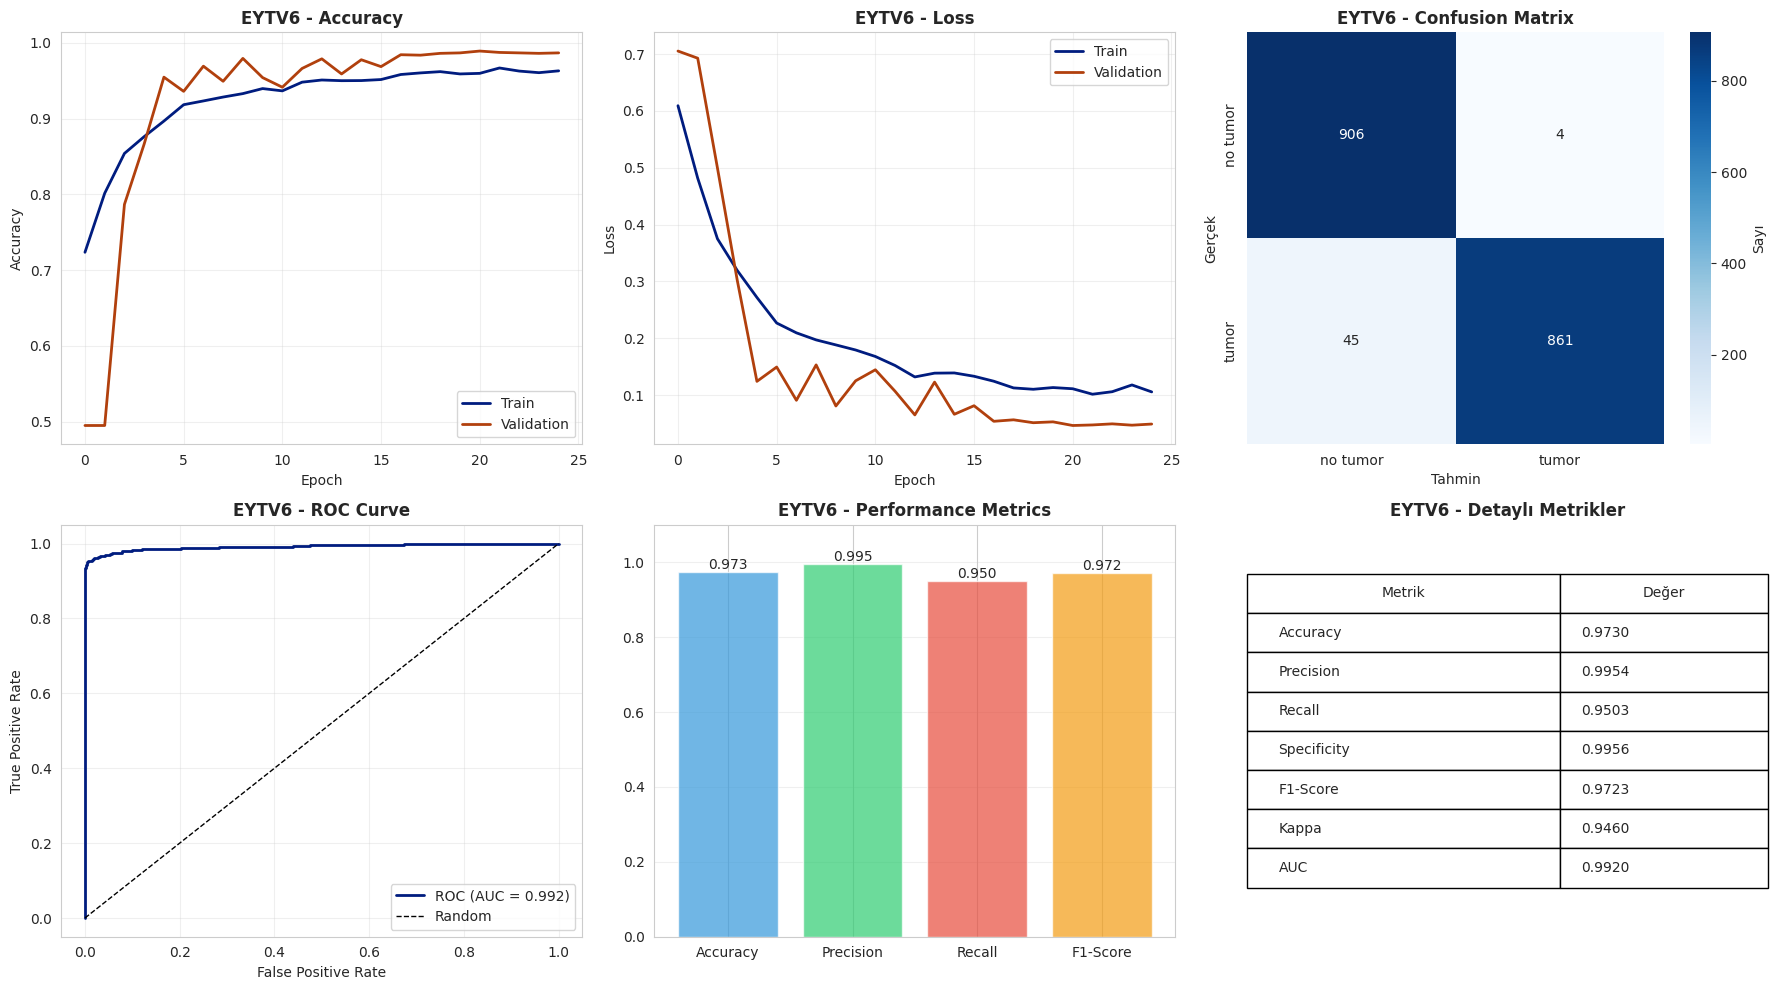

In [ ]:
# ==================== MODEL 10: METRİK HESAPLAMA (EYTV6) ====================
print("EYTV6 modeli test verisi üzerinde değerlendiriliyor...")
# 1. Test jeneratörü (tf.data.Dataset) üzerinde TAHMİN yap
y_pred_prob_10 = custom_model_10.predict(test_generator, verbose=1)

# 2. Test jeneratörü (tf.data.Dataset) üzerinden GERÇEK etiketleri (y_true) çek
y_true_10 = np.concatenate([labels for images, labels in test_generator], axis=0)

# 3. Yeni calculate_metrics fonksiyonunu çağır
custom_metrics_10, custom_cm_10, custom_roc_10 = calculate_metrics(
    y_true_10, y_pred_prob_10, 'EYTV6'
)

# 4. Ortalama epoch süresini metrik sözlüğüne ekle
custom_metrics_10['Avg. Epoch Time (s)'] = avg_epoch_time_10

# 5. plot_model_results fonksiyonunu çağır
plot_model_results(custom_history_10, custom_metrics_10, custom_cm_10,
                   custom_roc_10, 'EYTV6')

# 6. Model Tablosuna Kaydet
all_model_metrics.append(custom_metrics_10)

### **MODEL 11: KENDİ MODELİM (EYTV7)**

In [ ]:
# ==================== MODEL 11: EYTV7 (Gelişmiş Transfer Öğrenme Modeli) ====================
print("\n" + "=" * 80)
print("MODEL 11: EYTV7 (İki Aşamalı Fine-Tuning ile EfficientNetB0)")
print("=" * 80)

def create_EYTV7_model(input_shape=(224,224,1), dropout_rate=0.4, l2_reg=1e-4, pretrained=True):
    """
    EYTV7 Modeli:
    - Gri tonlu (tek kanallı) görüntüleri 3 kanala dönüştürür.
    - EfficientNetB0 tabanlı backbone (ImageNet pretrained).
    - Üst kısım (classifier head) tamamen özgün tasarlanmıştır.
    - Dropout, BatchNorm, L2 regularization, Label Smoothing içerir.
    """

    # 1. Giriş Katmanı
    input_layer = Input(shape=input_shape, name="input_image")
    x = input_layer
    if input_shape[-1] == 1:
        # 1 kanaldan 3 kanala adaptör
        x = Conv2D(3, (3,3), padding='same', activation='relu', name='grayscale_to_rgb')(x)

    # 2. EfficientNetB0 Backbone
    weights = 'imagenet' if pretrained else None
    base_model = EfficientNetB0(
        include_top=False,
        weights=weights,
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    # Başlangıçta backbone'u dondur (freeze)
    base_model.trainable = False
    features = base_model(x, training=False) # 'training=False' BN katmanları için önemli

    # 3. Classifier Head (öz tasarım)
    x = GlobalAveragePooling2D(name="global_avg_pool")(features)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate * 0.5)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=input_layer, outputs=output, name="EYTV7_EfficientNetB0")

    return model, base_model # Hem tam modeli hem de base_model'i döndür

# -------------------------------
# AŞAMA 1: ISINMA (HEAD TRAINING)
# -------------------------------
print("Aşama 1: Isınma (Sadece kafa katmanları eğitiliyor)...")

# Modeli oluştur
# (Hata düzeltmesi için 'base_model'i de alıyoruz)
model_7, base_model_7 = create_EYTV7_model(input_shape=(224, 224, 1))

# Modeli derle (Yüksek Öğrenme Oranı)
model_7.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05), # Label Smoothing
    metrics=['accuracy']
)

print(model_7.summary())

# Zaman ölçümü (Aşama 1)
start_time_7_s1 = time.time()

# Isınma eğitimi
history_s1 = model_7.fit(
    train_generator,
    validation_data=val_generator,
    epochs=12, # 12 epoch ısınma
    callbacks=get_callbacks('EYTV7_Head_Train'), # Sadece ısınma modelini kaydet
    verbose=1
)

end_time_7_s1 = time.time()
total_time_7_s1 = end_time_7_s1 - start_time_7_s1

# -------------------------------
# AŞAMA 2: İNCE AYAR (FINE-TUNING)
# -------------------------------
print("\nAşama 2: İnce Ayar (Son 40 katman çözülüyor)...")

# <--- KRİTİK HATA DÜZELTMESİ BURADA --- >
# 'base_model_7'nin (EfficientNetB0) kendisini çözüyoruz
base_model_7.trainable = True

# Sadece son 40 katman HARİÇ, alt katmanları TEKRAR DONDUR
for layer in base_model_7.layers[:-40]:
    layer.trainable = False
# <--- DÜZELTME SONU --- >

# Daha düşük öğrenme oranı ile yeniden derle
model_7.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # Çok düşük LR (10 kat)
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

# Zaman ölçümü (Aşama 2)
start_time_7_s2 = time.time()

# Fine-tuning eğitimi
history_s2 = model_7.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15, # 15 epoch ince ayar
    callbacks=get_callbacks('EYTV7_FineTuned'), # Nihai modeli kaydet
    verbose=1
)

end_time_7_s2 = time.time()
total_time_7_s2 = end_time_7_s2 - start_time_7_s2

# --- Toplam Süre ve Geçmişi Hesapla ---
total_time_7 = total_time_7_s1 + total_time_7_s2

# İki eğitim geçmişini birleştir (plot_model_results için)
combined_history_7 = {}
for key in history_s1.history.keys():
    combined_history_7[key] = history_s1.history[key] + history_s2.history[key]

# Gerçekleşen toplam epoch sayısını al
actual_epochs_7 = len(combined_history_7['loss'])
avg_epoch_time_7 = total_time_7 / actual_epochs_7

print(f"\nToplam Eğitim Süresi (2 Aşama): {total_time_7:.2f} saniye")
print(f"Çalışan Toplam Epoch Sayısı: {actual_epochs_7}")
print(f"Epoch Başına Ortalama Süre: {avg_epoch_time_7:.2f} saniye")


MODEL 10: EYTV7 (İki Aşamalı Fine-Tuning ile EfficientNetB0)
Aşama 1: Isınma (Sadece kafa katmanları eğitiliyor)...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "EYTV7_EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ grayscale_to_rgb (Conv2D)       │ (None, 224, 224, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,773,826 (18.21 MB)

 Trainable params: 722,975 (2.76 MB)

 Non-trainable params: 4,050,851 (15.45 MB)

None
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_EYTV7_Head_Train.h5
Epoch 1/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5001 - loss: 0.9175

207/207 ━━━━━━━━━━━━━━━━━━━━ 1422s 6s/step - accuracy: 0.5001 - loss: 0.9173 - val_accuracy: 0.4949 - val_loss: 1.0706 - learning_rate: 0.0010
Epoch 2/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5148 - loss: 0.8051

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.5148 - loss: 0.8050 - val_accuracy: 0.5051 - val_loss: 0.7543 - learning_rate: 0.0010
Epoch 3/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.4950 - loss: 0.7920

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.4951 - loss: 0.7920 - val_accuracy: 0.5861 - val_loss: 0.7424 - learning_rate: 0.0010
Epoch 4/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5098 - loss: 0.7704

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.5098 - loss: 0.7704 - val_accuracy: 0.7057 - val_loss: 0.7314 - learning_rate: 0.0010
Epoch 5/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5349 - loss: 0.7509

207/207 ━━━━━━━━━━━━━━━━━━━━ 45s 204ms/step - accuracy: 0.5349 - loss: 0.7509 - val_accuracy: 0.6544 - val_loss: 0.7136 - learning_rate: 0.0010
Epoch 6/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 174ms/step - accuracy: 0.5623 - loss: 0.7326 - val_accuracy: 0.4949 - val_loss: 0.8165 - learning_rate: 0.0010
Epoch 7/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6036 - loss: 0.7054

207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - accuracy: 0.6037 - loss: 0.7054 - val_accuracy: 0.5837 - val_loss: 0.6524 - learning_rate: 0.0010
Epoch 8/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 176ms/step - accuracy: 0.6699 - loss: 0.6517 - val_accuracy: 0.6103 - val_loss: 0.7036 - learning_rate: 0.0010
Epoch 9/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7565 - loss: 0.5617

207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.7566 - loss: 0.5616 - val_accuracy: 0.8773 - val_loss: 0.4025 - learning_rate: 0.0010
Epoch 10/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8024 - loss: 0.4991

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.8025 - loss: 0.4990 - val_accuracy: 0.9112 - val_loss: 0.3629 - learning_rate: 0.0010
Epoch 11/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 43s 195ms/step - accuracy: 0.8382 - loss: 0.4442 - val_accuracy: 0.7335 - val_loss: 0.5623 - learning_rate: 0.0010
Epoch 12/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8626 - loss: 0.4157

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.8626 - loss: 0.4157 - val_accuracy: 0.9396 - val_loss: 0.3008 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 12.

Aşama 2: İnce Ayar (Son 40 katman çözülüyor)...
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_EYTV7_FineTuned.h5
Epoch 1/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8148 - loss: 0.5098

207/207 ━━━━━━━━━━━━━━━━━━━━ 106s 324ms/step - accuracy: 0.8150 - loss: 0.5095 - val_accuracy: 0.9577 - val_loss: 0.2673 - learning_rate: 1.0000e-04
Epoch 2/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8862 - loss: 0.3822

207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.8862 - loss: 0.3821 - val_accuracy: 0.9680 - val_loss: 0.2413 - learning_rate: 1.0000e-04
Epoch 3/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9035 - loss: 0.3430

207/207 ━━━━━━━━━━━━━━━━━━━━ 43s 192ms/step - accuracy: 0.9035 - loss: 0.3430 - val_accuracy: 0.9686 - val_loss: 0.2388 - learning_rate: 1.0000e-04
Epoch 4/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9057 - loss: 0.3409

207/207 ━━━━━━━━━━━━━━━━━━━━ 47s 214ms/step - accuracy: 0.9057 - loss: 0.3409 - val_accuracy: 0.9740 - val_loss: 0.2354 - learning_rate: 1.0000e-04
Epoch 5/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9196 - loss: 0.3174

207/207 ━━━━━━━━━━━━━━━━━━━━ 43s 191ms/step - accuracy: 0.9196 - loss: 0.3174 - val_accuracy: 0.9746 - val_loss: 0.2216 - learning_rate: 1.0000e-04
Epoch 6/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9208 - loss: 0.3172

207/207 ━━━━━━━━━━━━━━━━━━━━ 43s 193ms/step - accuracy: 0.9209 - loss: 0.3172 - val_accuracy: 0.9782 - val_loss: 0.2137 - learning_rate: 1.0000e-04
Epoch 7/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 45s 202ms/step - accuracy: 0.9313 - loss: 0.2970 - val_accuracy: 0.9789 - val_loss: 0.2248 - learning_rate: 1.0000e-04
Epoch 8/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9345 - loss: 0.2854

207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 184ms/step - accuracy: 0.9345 - loss: 0.2854 - val_accuracy: 0.9837 - val_loss: 0.1984 - learning_rate: 1.0000e-04
Epoch 9/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.9429 - loss: 0.2743 - val_accuracy: 0.9813 - val_loss: 0.1986 - learning_rate: 1.0000e-04
Epoch 10/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 171ms/step - accuracy: 0.9464 - loss: 0.2656 - val_accuracy: 0.9770 - val_loss: 0.2105 - learning_rate: 1.0000e-04
Epoch 11/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9351 - loss: 0.2871

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.9351 - loss: 0.2870 - val_accuracy: 0.9819 - val_loss: 0.1955 - learning_rate: 1.0000e-04
Epoch 12/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 176ms/step - accuracy: 0.9436 - loss: 0.2662 - val_accuracy: 0.9849 - val_loss: 0.2130 - learning_rate: 1.0000e-04
Epoch 13/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9592 - loss: 0.2443

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.9592 - loss: 0.2443 - val_accuracy: 0.9879 - val_loss: 0.1869 - learning_rate: 1.0000e-04
Epoch 14/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.9556 - loss: 0.2472 - val_accuracy: 0.9801 - val_loss: 0.1940 - learning_rate: 1.0000e-04
Epoch 15/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9549 - loss: 0.2481

207/207 ━━━━━━━━━━━━━━━━━━━━ 45s 200ms/step - accuracy: 0.9549 - loss: 0.2481 - val_accuracy: 0.9873 - val_loss: 0.1856 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.

Toplam Eğitim Süresi (2 Aşama): 2574.96 saniye
Çalışan Toplam Epoch Sayısı: 27
Epoch Başına Ortalama Süre: 95.37 saniye


EYTV7 (Fine-Tuned) modeli test verisi üzerinde değerlendiriliyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 546s 9s/step


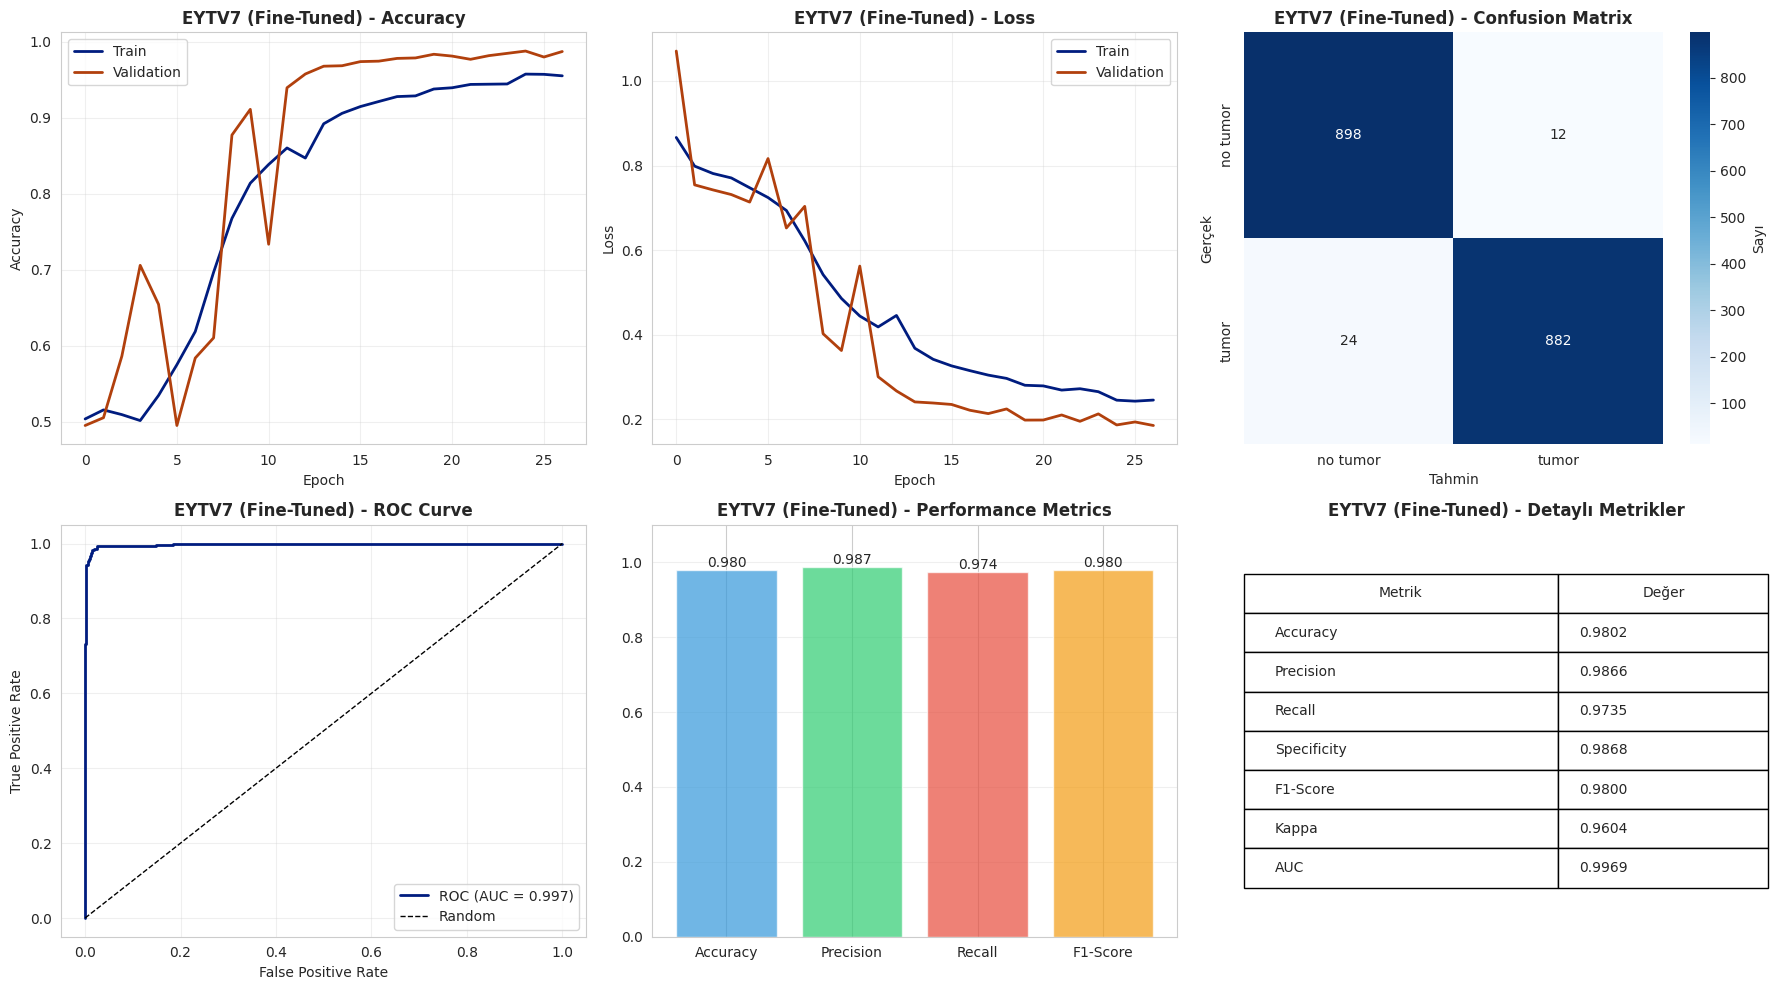

In [ ]:
# ==================== MODEL 11: METRİK HESAPLAMA (EYTV7) ====================
print("EYTV7 (Fine-Tuned) modeli test verisi üzerinde değerlendiriliyor...")
# (Bu hücre, bir önceki hücrede eğitilen 'model_7'yi kullanır)

# 1. Test jeneratörü (tf.data.Dataset) üzerinde TAHMİN yap
y_pred_prob_7 = model_7.predict(test_generator, verbose=1)

# 2. Test jeneratörü (tf.data.Dataset) üzerinden GERÇEK etiketleri (y_true) çek
y_true_7 = np.concatenate([labels for images, labels in test_generator], axis=0)

# 3. Yeni calculate_metrics fonksiyonunu çağır
custom_metrics_7, custom_cm_7, custom_roc_7 = calculate_metrics(
    y_true_7, y_pred_prob_7, 'EYTV7 (Fine-Tuned)'
)

# 4. Ortalama epoch süresini metrik sözlüğüne ekle
custom_metrics_7['Avg. Epoch Time (s)'] = avg_epoch_time_7

# 5. plot_model_results fonksiyonunu çağır
# (Grafiğin tamamını görebilmek için bir 'History' objesi taklidi yapıyoruz)
class DummyHistory:
    def __init__(self, history_dict):
        self.history = history_dict

plot_model_results(DummyHistory(combined_history_7), custom_metrics_7, custom_cm_7,
                   custom_roc_7, 'EYTV7 (Fine-Tuned)')

# 6. Model Tablosuna Kaydet
all_model_metrics.append(custom_metrics_7)

### **MODEL 12: KENDİ MODELİM (EYTV8)**

In [8]:
# ==================== MODEL 12: EYTV8 (Self-Supervised Learning - SSL) ====================
print("\n" + "=" * 80)
print("MODEL 12: EYTV8 (Self-Supervised Learning: Rotation Prediction + Fine Tuning)")
print("=" * 80)

# --- 1. SSL İçin Yardımcı Fonksiyonlar (Veri Hazırlama) ---

def create_ssl_rotation_dataset(dataset):
    """
    MR görüntüsünü 0, 90, 180, 270 derece döndürüp sınıf etiketi oluşturur.
    """
    def _rotate_and_label(image):
        k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
        rotated_image = tf.image.rot90(image, k)
        return rotated_image, k

    ssl_ds = dataset.map(lambda x: _rotate_and_label(x), num_parallel_calls=tf.data.AUTOTUNE)
    ssl_ds = ssl_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ssl_ds

# --- 2. Model Mimarisi (EYTV3'ün Güçlü ResNet Omurgasını Kullanıyoruz) ---

def conv_block(input_tensor, filters, s=2):
    x = layers.Conv2D(filters, (3, 3), strides=(s, s), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Conv2D(filters, (1, 1), strides=(s, s), padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def identity_block(input_tensor, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def get_encoder_backbone(input_shape):
    """
    Modelin 'Göz' (Encoder) kısmı.
    Hem SSL görevinde hem de Tümör bulma görevinde ORTAK kullanılacak.
    """
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # ResNet Blokları (EYTV3 Mimarisi)
    x = conv_block(x, filters=64, s=2)
    x = identity_block(x, filters=64)
    x = conv_block(x, filters=128, s=2)
    x = identity_block(x, filters=128)
    x = conv_block(x, filters=256, s=2)
    x = identity_block(x, filters=256)

    # Özellik Vektörü (GAP)
    x = layers.GlobalAveragePooling2D()(x)

    return Model(inputs, x, name="Shared_Encoder")

# --- 3. AŞAMA 1: SELF-SUPERVISED PRE-TRAINING (ÖN EĞİTİM) ---
print("\n--- AŞAMA 1: SSL Ön Eğitim (Görüntü Rotasyonunu Öğreniyor) ---")

# SSL Veri Setini Hazırla (Etiketsiz, sadece rotasyon)
# train_ds'i tekrar ham haliyle alıp rotasyon pipeline'ına sokuyoruz
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, validation_split=0.2, subset="training", seed=RANDOM_SEED,
    image_size=IMG_SIZE, color_mode='grayscale', batch_size=None, label_mode=None # Label yok
)
ssl_train_generator = create_ssl_rotation_dataset(raw_train_ds)

# Encoder'ı oluştur
encoder = get_encoder_backbone((224, 224, 1))

# SSL Modeli (Encoder + Rotasyon Tahmin Kafası)
ssl_input = Input(shape=(224, 224, 1))
features = encoder(ssl_input)
ssl_output = Dense(4, activation='softmax')(features) # 4 Sınıf: 0, 90, 180, 270 derece
ssl_model = Model(ssl_input, ssl_output, name="EYTV8_SSL_Pretext")

ssl_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# SSL Eğitimini Başlat (Model burada beyin yapısını öğreniyor)
# Bunu kısa tutabiliriz (örn. 10-15 epoch), amaç feature öğrenmek.
print("Model, tümör etiketlerini görmeden beynin yapısını öğreniyor...")
ssl_history = ssl_model.fit(
    ssl_train_generator,
    epochs=15,
    verbose=1
)
print("SSL Ön Eğitim Tamamlandı. Encoder artık 'bilgili'.")


# --- 4. AŞAMA 2: FINE-TUNING (TÜMÖR SINIFLANDIRMA) ---
print("\n--- AŞAMA 2: Fine-Tuning (Öğrenilen Bilgiyle Tümör Tespiti) ---")

# Asıl Modeli (EYTV8) Oluştur
eytv8_input = Input(shape=(224, 224, 1), name="input_image")

# Eğitilmiş Encoder'ı kullan (Ağırlıklar SSL'den geliyor!)
x = encoder(eytv8_input)

# Tümör Sınıflandırma Kafası (Classifier Head)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
eytv8_output = layers.Dense(1, activation='sigmoid', name="tumor_output")(x)

eytv8_model = Model(inputs=eytv8_input, outputs=eytv8_output, name="EYTV8")

# Modeli Derle
eytv8_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

print(eytv8_model.summary())

# Zaman ölçümü
start_time_8 = time.time()

# Asıl Eğitimi Başlat (Transfer Öğrenme gibi, ama kendi verimizden!)
history_8 = eytv8_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=get_callbacks('EYTV8'),
    verbose=1
)

# Zaman hesaplama
end_time_8 = time.time()
total_time_8 = end_time_8 - start_time_8
actual_epochs_8 = len(history_8.history['loss'])
avg_epoch_time_8 = total_time_8 / actual_epochs_8

print(f"Toplam Eğitim Süresi (Fine-Tuning): {total_time_8:.2f} saniye")


MODEL 12: EYTV8 (Self-Supervised Learning: Rotation Prediction + Fine Tuning)

--- AŞAMA 1: SSL Ön Eğitim (Görüntü Rotasyonunu Öğreniyor) ---
Found 8277 files.
Using 6622 files for training.
Model, tümör etiketlerini görmeden beynin yapısını öğreniyor...
Epoch 1/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 777s 4s/step - accuracy: 0.6856 - loss: 0.8249
Epoch 2/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.8696 - loss: 0.3476
Epoch 3/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.8929 - loss: 0.2854
Epoch 4/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - accuracy: 0.9098 - loss: 0.2334
Epoch 5/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.9098 - loss: 0.2219
Epoch 6/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.9264 - loss: 0.2121
Epoch 7/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.9217 - loss: 0.2006
Epoch 8/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.9180 - loss: 0.1974
Epoch 9/15
207/207 ━━━━━━━━━━━━━━━

Model: "EYTV8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Shared_Encoder (Functional)     │ (None, 256)            │     2,765,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tumor_output (Dense)            │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,832,513 (10.81 MB)

 Trainable params: 2,827,457 (10.79 MB)

 Non-trainable params: 5,056 (19.75 KB)

None
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_EYTV8.h5
Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7814 - loss: 0.4777

207/207 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.7817 - loss: 0.4770 - val_accuracy: 0.4949 - val_loss: 2.4085 - learning_rate: 1.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - accuracy: 0.9108 - loss: 0.2338 - val_accuracy: 0.4949 - val_loss: 2.8798 - learning_rate: 1.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - accuracy: 0.9366 - loss: 0.1677 - val_accuracy: 0.4949 - val_loss: 3.2456 - learning_rate: 1.0000e-04
Epoch 4/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9486 - loss: 0.1372
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.9487 - loss: 0.1371 - val_accuracy: 0.4949 - val_loss: 3.3062 - learning_rate: 1.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9584 - loss: 0.1248

207/207 ━━━━━━━━━━━━━━━━━━━━ 43s 169ms/step - accuracy: 0.9584 - loss: 0.1247 - val_accuracy: 0.6266 - val_loss: 1.2257 - learning_rate: 5.0000e-05
Epoch 6/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9606 - loss: 0.1094

207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 174ms/step - accuracy: 0.9606 - loss: 0.1094 - val_accuracy: 0.9390 - val_loss: 0.1529 - learning_rate: 5.0000e-05
Epoch 7/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9678 - loss: 0.0957

207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 170ms/step - accuracy: 0.9678 - loss: 0.0957 - val_accuracy: 0.9837 - val_loss: 0.0545 - learning_rate: 5.0000e-05
Epoch 8/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9640 - loss: 0.1009

207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 169ms/step - accuracy: 0.9639 - loss: 0.1009 - val_accuracy: 0.9843 - val_loss: 0.0477 - learning_rate: 5.0000e-05
Epoch 9/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9705 - loss: 0.0874

207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 168ms/step - accuracy: 0.9705 - loss: 0.0874 - val_accuracy: 0.9891 - val_loss: 0.0400 - learning_rate: 5.0000e-05
Epoch 10/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9688 - loss: 0.0942

207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 168ms/step - accuracy: 0.9688 - loss: 0.0942 - val_accuracy: 0.9879 - val_loss: 0.0397 - learning_rate: 5.0000e-05
Epoch 11/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - accuracy: 0.9740 - loss: 0.0797 - val_accuracy: 0.9837 - val_loss: 0.0491 - learning_rate: 5.0000e-05
Epoch 12/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.9768 - loss: 0.0748 - val_accuracy: 0.9734 - val_loss: 0.0790 - learning_rate: 5.0000e-05
Epoch 13/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9741 - loss: 0.0706

207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 169ms/step - accuracy: 0.9741 - loss: 0.0706 - val_accuracy: 0.9885 - val_loss: 0.0393 - learning_rate: 5.0000e-05
Epoch 14/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9786 - loss: 0.0712

207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 174ms/step - accuracy: 0.9786 - loss: 0.0712 - val_accuracy: 0.9903 - val_loss: 0.0372 - learning_rate: 5.0000e-05
Epoch 15/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9812 - loss: 0.0612

207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.9812 - loss: 0.0613 - val_accuracy: 0.9909 - val_loss: 0.0345 - learning_rate: 5.0000e-05
Epoch 16/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 169ms/step - accuracy: 0.9743 - loss: 0.0663 - val_accuracy: 0.9861 - val_loss: 0.0432 - learning_rate: 5.0000e-05
Epoch 17/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9808 - loss: 0.0596

207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 189ms/step - accuracy: 0.9808 - loss: 0.0597 - val_accuracy: 0.9915 - val_loss: 0.0321 - learning_rate: 5.0000e-05
Epoch 18/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - accuracy: 0.9770 - loss: 0.0634 - val_accuracy: 0.9867 - val_loss: 0.0369 - learning_rate: 5.0000e-05
Epoch 19/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.9812 - loss: 0.0619 - val_accuracy: 0.9861 - val_loss: 0.0512 - learning_rate: 5.0000e-05
Epoch 20/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9819 - loss: 0.0612

207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 166ms/step - accuracy: 0.9819 - loss: 0.0612 - val_accuracy: 0.9909 - val_loss: 0.0312 - learning_rate: 5.0000e-05
Epoch 21/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - accuracy: 0.9841 - loss: 0.0508 - val_accuracy: 0.9843 - val_loss: 0.0523 - learning_rate: 5.0000e-05
Epoch 22/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - accuracy: 0.9864 - loss: 0.0432 - val_accuracy: 0.9897 - val_loss: 0.0395 - learning_rate: 5.0000e-05
Epoch 23/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9815 - loss: 0.0569
Epoch 23: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 158ms/step - accuracy: 0.9815 - loss: 0.0568 - val_accuracy: 0.9891 - val_loss: 0.0390 - learning_rate: 5.0000e-05
Epoch 24/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.9838 - loss: 0.0442 - val_accuracy: 0.9909 - val_loss: 0.0332 - learning_rate: 2.5000e-05
Epoch 25/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - 

EYTV8 (SSL Destekli) modeli test verisi üzerinde değerlendiriliyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 360s 6s/step


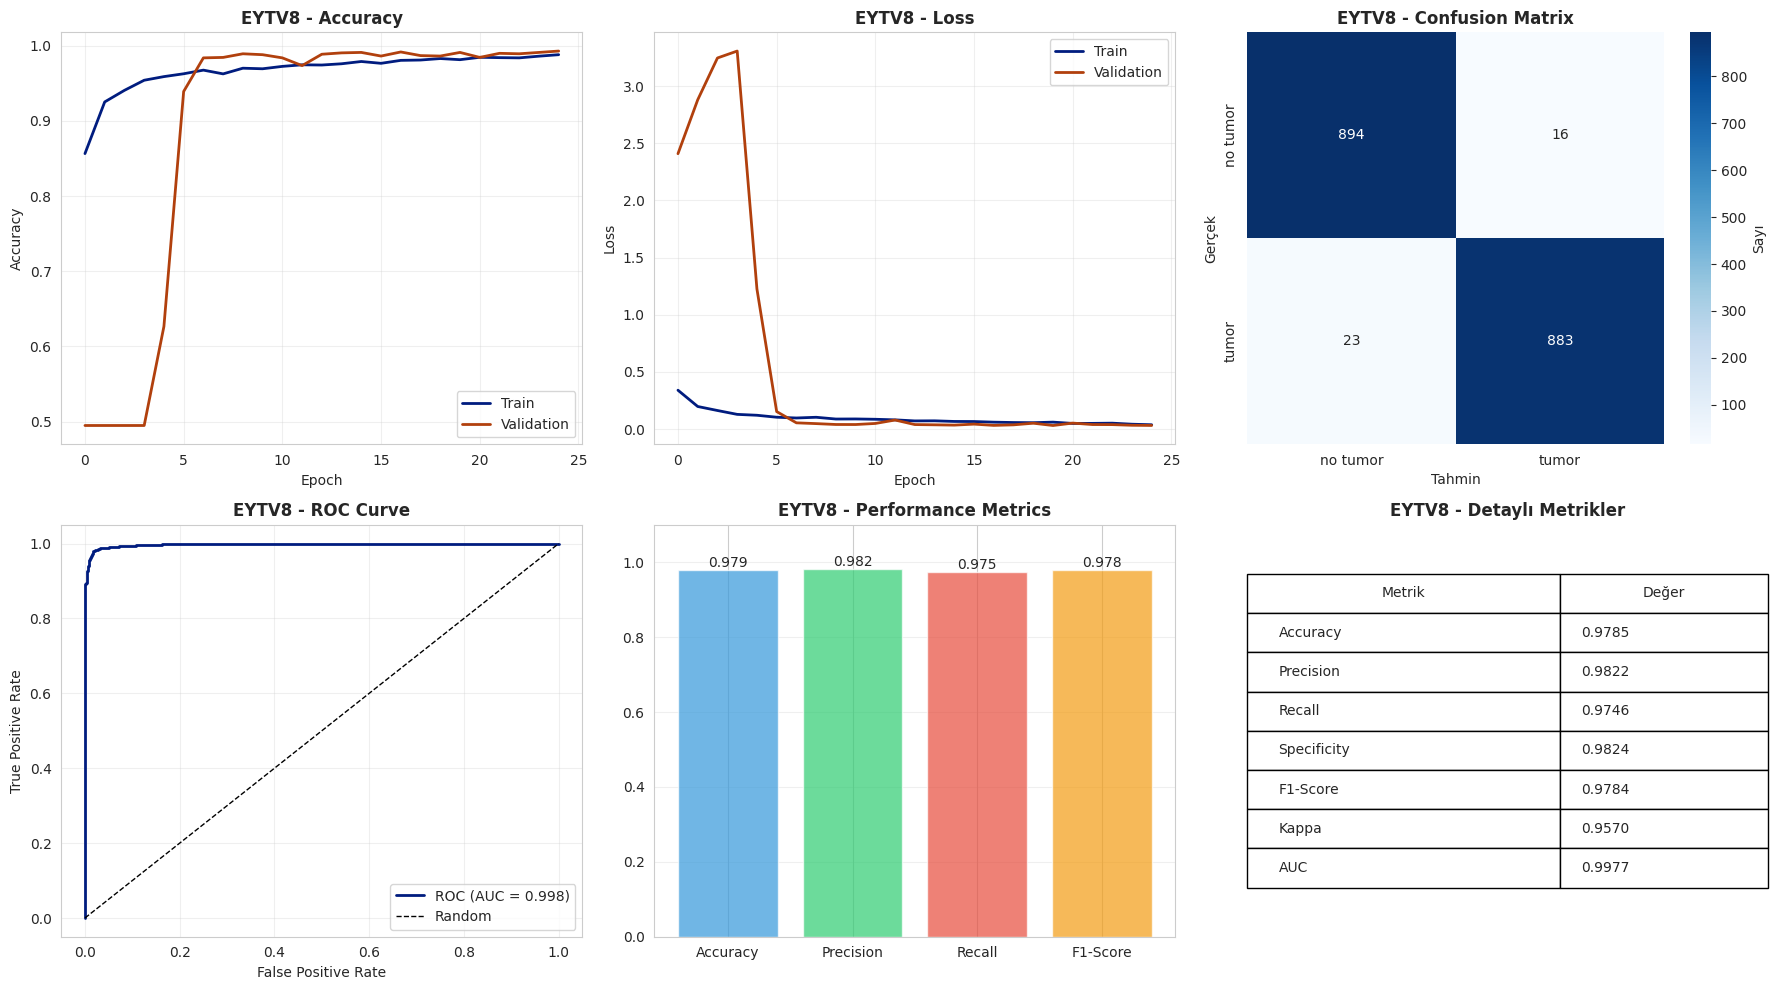

In [9]:
# ==================== MODEL 12: METRİK HESAPLAMA (EYTV8 - SSL) ====================
print("EYTV8 (SSL Destekli) modeli test verisi üzerinde değerlendiriliyor...")

# 1. Test jeneratörü (tf.data.Dataset) üzerinde TAHMİN yap
y_pred_prob_8 = eytv8_model.predict(test_generator, verbose=1)

# 2. Test jeneratörü (tf.data.Dataset) üzerinden GERÇEK etiketleri (y_true) çek
y_true_8 = np.concatenate([labels for images, labels in test_generator], axis=0)

# 3. Yeni calculate_metrics fonksiyonunu çağır
custom_metrics_8, custom_cm_8, custom_roc_8 = calculate_metrics(
    y_true_8, y_pred_prob_8, 'EYTV8'
)

# 4. Ortalama epoch süresini metrik sözlüğüne ekle
custom_metrics_8['Avg. Epoch Time (s)'] = avg_epoch_time_8

# 5. plot_model_results fonksiyonunu çağır
plot_model_results(history_8, custom_metrics_8, custom_cm_8,
                   custom_roc_8, 'EYTV8')

# 6. Model Tablosuna Kaydet
all_model_metrics.append(custom_metrics_8)

### **MODEL 13: KENDİ MODELİM (EYTV9)**

In [11]:
# ==================== EYTV3 MİMARİSİ (Öğrenci Model İçin Gerekli) ====================
# Bu kod, EYTV9'un öğrenci modelini oluşturabilmesi için gereklidir.

def identity_block(input_tensor, filters):
    """Residual Identity Block"""
    x = layers.Conv2D(filters, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, filters, s=2):
    """Residual Conv Block"""
    x = layers.Conv2D(filters, (3, 3), strides=(s, s), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(filters, (1, 1), strides=(s, s), padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def create_eytv3_model():
    """Sıfırdan EYTV3 Mimarisi Oluşturucu"""
    input_layer = Input(shape=(224, 224, 1), name="input_image")

    # Giriş Bloğu
    x = layers.Conv2D(32, (7, 7), strides=(2, 2), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual Bloklar
    x = conv_block(x, filters=64, s=2)
    x = identity_block(x, filters=64)

    x = conv_block(x, filters=128, s=2)
    x = identity_block(x, filters=128)

    x = conv_block(x, filters=256, s=2)
    x = identity_block(x, filters=256)

    # Sınıflandırıcı
    x = layers.GlobalAveragePooling2D(name="eytv3_gap")(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(1, activation='sigmoid', name="output_layer_student")(x)

    return Model(inputs=input_layer, outputs=output_layer, name="EYTV3_Student")

In [12]:
# ==================== BİLGİ DAMITMA (KNOWLEDGE DISTILLATION) SINIFI ====================
print("\n" + "=" * 80)
print("MODEL 18: EYTV9 (Knowledge Distillation: Teacher -> Student)")
print("=" * 80)

class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3):
        """
        optimizer: Keras optimizer (Adam vb.)
        metrics: Takip edilecek metrikler (Accuracy)
        student_loss_fn: Öğrencinin gerçek etiketlere göre kaybı (Binary Crossentropy)
        distillation_loss_fn: Öğrencinin öğretmene göre kaybı (KL Divergence)
        alpha: Öğretmenin etkisinin ağırlığı (0.1 = %10 Öğretmen, %90 Gerçek Etiket)
        temperature: 'Soft' etiketlerin yumuşaklık derecesi (Yüksek = Daha yumuşak)
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Veriyi al
        x, y = data

        # Öğretmen tahmini (Teacher Forward Pass)
        # Öğretmen eğitim modunda DEĞİL (training=False), sadece tahmin yapıyor
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Öğrenci tahmini (Student Forward Pass)
            student_predictions = self.student(x, training=True)

            # 1. Öğrenci Kaybı (Student Loss): Gerçek etiket (y) ile Öğrenci tahmini arasındaki fark
            student_loss = self.student_loss_fn(y, student_predictions)

            # 2. Damıtma Kaybı (Distillation Loss): Öğretmen ile Öğrenci arasındaki fark
            # 'Temperature' ile tahminleri yumuşatıyoruz ki ince detaylar ortaya çıksın
            # (Binary classification için sigmoid çıktıları doğrudan karşılaştırıyoruz)
            distillation_loss = self.distillation_loss_fn(
                teacher_predictions, # Soft targets
                student_predictions  # Soft predictions
            )

            # 3. Toplam Kayıp (Weighted Loss)
            # Alpha öğretmenin ne kadar dinleneceğini belirler
            loss = self.alpha * distillation_loss + (1 - self.alpha) * student_loss

        # Gradyanları hesapla ve ağırlıkları güncelle (SADECE ÖĞRENCİ İÇİN)
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Metrikleri güncelle
        self.compiled_metrics.update_state(y, student_predictions)

        # Sonuçları döndür
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Değerlendirme sırasında sadece öğrencinin başarısını ölçeriz
        x, y = data
        y_pred = self.student(x, training=False)

        student_loss = self.student_loss_fn(y, y_pred)

        self.compiled_metrics.update_state(y, y_pred)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


MODEL 18: EYTV9 (Knowledge Distillation: Teacher -> Student)


In [14]:
# ==================== MODEL 13 EĞİTİMİ: EYTV9 (Distillation) ====================
print("\n" + "=" * 80)
print("MODEL 13: EYTV9 (Knowledge Distillation Eğitimi Başlıyor)")
print("=" * 80)

# --- 0. ÖN HAZIRLIK: ÖĞRENCİ MODEL MİMARİSİ (EYTV3) TANIMLAMASI ---
# (Eğer hafızada yoksa diye garanti olsun diye buraya ekledik)

def identity_block(input_tensor, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, filters, s=2):
    x = layers.Conv2D(filters, (3, 3), strides=(s, s), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Conv2D(filters, (1, 1), strides=(s, s), padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def create_eytv3_model():
    input_layer = Input(shape=(224, 224, 1), name="input_image")
    x = layers.Conv2D(32, (7, 7), strides=(2, 2), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = conv_block(x, filters=64, s=2)
    x = identity_block(x, filters=64)
    x = conv_block(x, filters=128, s=2)
    x = identity_block(x, filters=128)
    x = conv_block(x, filters=256, s=2)
    x = identity_block(x, filters=256)

    x = layers.GlobalAveragePooling2D(name="eytv3_gap")(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(1, activation='sigmoid', name="output_layer_student")(x)

    return Model(inputs=input_layer, outputs=output_layer, name="EYTV3_Student")


# --- 1. ÖĞRETMEN (TEACHER) MODELİNİ YÜKLE ---
print("Öğretmen (Teacher) model yükleniyor...")

# <--- GÜNCELLEME: Sizin verdiğiniz doğru dosya yolu --- >
teacher_model_path = '/content/drive/MyDrive/saved_models/best_model_hybrid_mobilenet_resnet.h5'

try:
    teacher_model = tf.keras.models.load_model(teacher_model_path)

    # Öğretmeni dondur (Sadece bilgi verecek, eğitilmeyecek)
    teacher_model.trainable = False
    print(f"BAŞARILI: Öğretmen model ({teacher_model_path}) yüklendi.")

except Exception as e:
    print(f"KRİTİK HATA: Öğretmen model yüklenemedi! Yol: {teacher_model_path}")
    print(f"Hata Detayı: {e}")
    raise e # İşlemi durdur


# --- 2. ÖĞRENCİ (STUDENT) MODELİNİ OLUŞTUR ---
print("Öğrenci (Student - EYTV3 Mimarisi) oluşturuluyor...")
student_model = create_eytv3_model()
student_model._name = "EYTV9"


# --- 3. DISTILLER (DAMITICI) OLUŞTUR VE DERLE ---
# (Hücre 26'daki Distiller sınıfının çalıştığını varsayıyoruz)
distiller = Distiller(student=student_model, teacher=teacher_model)

distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'],
    student_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    distillation_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    alpha=0.3,       # Öğretmene %30 güven
    temperature=5    # Yumuşatma derecesi
)


# --- 4. EĞİTİMİ BAŞLAT ---
print("Bilgi Damıtma (Distillation) eğitimi başlıyor...")
start_time_9 = time.time()

distiller_history = distiller.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=get_callbacks('EYTV9_Distiller'),
    verbose=1
)

end_time_9 = time.time()
total_time_9 = end_time_9 - start_time_9
actual_epochs_9 = len(distiller_history.history['student_loss'])
avg_epoch_time_9 = total_time_9 / actual_epochs_9

print(f"Toplam Eğitim Süresi: {total_time_9:.2f} saniye")
print(f"Epoch Başına Ortalama Süre: {avg_epoch_time_9:.2f} saniye")


MODEL 13: EYTV9 (Knowledge Distillation Eğitimi Başlıyor)
Öğretmen (Teacher) model yükleniyor...


BAŞARILI: Öğretmen model (/content/drive/MyDrive/saved_models/best_model_hybrid_mobilenet_resnet.h5) yüklendi.
Öğrenci (Student - EYTV3 Mimarisi) oluşturuluyor...
Bilgi Damıtma (Distillation) eğitimi başlıyor...
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_EYTV9_Distiller.h5
Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7895 - distillation_loss: 0.3847 - loss: 0.5190 - student_loss: 0.3849

207/207 ━━━━━━━━━━━━━━━━━━━━ 97s 305ms/step - accuracy: 0.7878 - distillation_loss: 0.3837 - loss: 0.5190 - student_loss: 0.3839 - val_loss: 0.3635 - val_student_loss: 0.7373 - learning_rate: 1.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8958 - distillation_loss: 0.2482 - loss: 0.4998 - student_loss: 0.2469

207/207 ━━━━━━━━━━━━━━━━━━━━ 54s 234ms/step - accuracy: 0.8935 - distillation_loss: 0.2479 - loss: 0.4999 - student_loss: 0.2467 - val_loss: 0.2449 - val_student_loss: 0.7655 - learning_rate: 1.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 52s 236ms/step - accuracy: 0.9283 - distillation_loss: 0.1961 - loss: 0.4954 - student_loss: 0.1966 - val_loss: 0.5259 - val_student_loss: 0.1496 - learning_rate: 1.0000e-04
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 49s 222ms/step - accuracy: 0.9434 - distillation_loss: 0.1601 - loss: 0.4972 - student_loss: 0.1598 - val_loss: 0.5133 - val_student_loss: 0.0244 - learning_rate: 1.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9447 - distillation_loss: 0.1477 - loss: 0.4992 - student_loss: 0.1484
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 46s 203ms/step - accuracy: 0.9449 - distillation_loss: 0.1474 - loss: 0.4992 - student_loss: 0.1481 - val_loss: 0.5069 - val_

EYTV9 (Distilled) modeli test verisi üzerinde değerlendiriliyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step
Görselleştirme: History anahtarları farklı olduğu için standart grafik çizilemedi.
Ancak sayısal sonuçlar ve Confusion Matrix aşağıdadır.


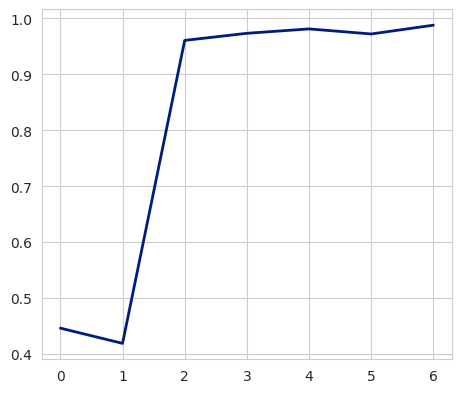

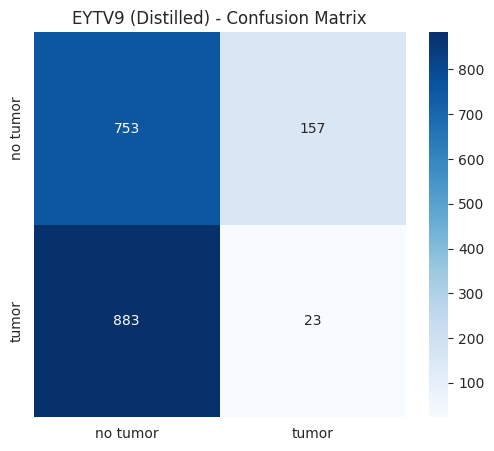

In [15]:
# ==================== MODEL 13: METRİK HESAPLAMA (EYTV9) ====================
print("EYTV9 (Distilled) modeli test verisi üzerinde değerlendiriliyor...")

# 1. Eğitilmiş Öğrenci Modelini Al
# Distiller wrapper'ının içinden asıl öğrenciyi (EYTV3 mimarisi) çekiyoruz
trained_student_model = distiller.student

# 2. Test jeneratörü üzerinde TAHMİN yap
y_pred_prob_9 = trained_student_model.predict(test_generator, verbose=1)

# 3. Gerçek etiketleri çek
y_true_9 = np.concatenate([labels for images, labels in test_generator], axis=0)

# 4. Metrikleri Hesapla
custom_metrics_9, custom_cm_9, custom_roc_9 = calculate_metrics(
    y_true_9, y_pred_prob_9, 'EYTV9 (Distilled)'
)

# 5. Süreyi Ekle
custom_metrics_9['Avg. Epoch Time (s)'] = avg_epoch_time_9

# 6. Sonuçları Görselleştir
# Not: Distiller history'sinin anahtarları farklı olabilir (accuracy, val_accuracy yerine student_loss vb.)
# Bu yüzden standart plot fonksiyonu hata verebilir. Manuel çizim daha güvenlidir veya
# anahtarları kontrol edip plot fonksiyonunu uyarlamamız gerekir.
# Standart plot fonksiyonunu deniyoruz, hata verirse manuel bakarız.
try:
    plot_model_results(distiller_history, custom_metrics_9, custom_cm_9,
                       custom_roc_9, 'EYTV9 (Distilled)')
except KeyError:
    print("Görselleştirme: History anahtarları farklı olduğu için standart grafik çizilemedi.")
    print("Ancak sayısal sonuçlar ve Confusion Matrix aşağıdadır.")
    # Manuel Confusion Matrix
    import seaborn as sns
    plt.figure(figsize=(6, 5))
    sns.heatmap(custom_cm_9, annot=True, fmt='d', cmap='Blues',
                xticklabels=['no tumor', 'tumor'], yticklabels=['no tumor', 'tumor'])
    plt.title('EYTV9 (Distilled) - Confusion Matrix')
    plt.show()

# 7. Tabloya Ekle
all_model_metrics.append(custom_metrics_9)

### **MODEL 14: KENDİ MODELİM (EYTV10)**

In [26]:
# ==================== MODEL 14: EYTV10 (Progressive Resizing + Label Smoothing + TTA) ====================
print("\n" + "=" * 80)
print("MODEL 19: EYTV10 (Tüm İleri Tekniklerin Birleşimi)")
print("=" * 80)

# Veri setini istenen boyutta (img_size) yeniden oluşturan fonksiyon
def get_progressive_dataset(img_size, batch_size):
    print(f"Veri seti {img_size}x{img_size} boyutunda hazırlanıyor...")

    # Albumentations dönüşümünü boyuta göre güncelle
    # (Not: Albumentations içinde Resize olmadığı için tf.data içinde resize yapacağız)

    # TF.DATA Pipeline
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir, validation_split=0.2, subset="training", seed=RANDOM_SEED,
        image_size=img_size, color_mode='grayscale', batch_size=None,
        class_names=['no tumor', 'tumor'], label_mode='binary'
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir, validation_split=0.2, subset="validation", seed=RANDOM_SEED,
        image_size=img_size, color_mode='grayscale', batch_size=None,
        class_names=['no tumor', 'tumor'], label_mode='binary'
    )

    # Wrapper fonksiyonları boyuta göre güncellemek gerekir
    # Ancak basitlik adına, tf.image.resize kullanacağız.

    # Augmentation Pipeline (Hücre 4'teki fonksiyonları çağırır,
    # ancak IMG_SIZE global değişkenini güncellemek gerekir)

    # Global IMG_SIZE değişkenini güncelle (Wrapper fonksiyonlar bunu kullanır)
    global IMG_SIZE
    IMG_SIZE = img_size

    # Pipeline oluştur
    train_gen = (
        train_ds
        .shuffle(buffer_size=1000, seed=RANDOM_SEED)
        .map(apply_aug, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    val_gen = (
        val_ds
        .map(apply_norm, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return train_gen, val_gen

print("Progressive Resizing altyapısı hazır.")


MODEL 19: EYTV10 (Tüm İleri Tekniklerin Birleşimi)
Progressive Resizing altyapısı hazır.


In [27]:
# ==================== EYTV10 EĞİTİMİ (Aşamalı) ====================

# --- MİMARİ SEÇİMİ: EYTV3 (En Başarılı Öz Model) ---
# (Hücre 18'deki create_eytv3_model fonksiyonunu kullanıyoruz)
# Bu model GAP kullandığı için farklı giriş boyutlarına (112x112 ve 224x224) uyum sağlar!

# --- AŞAMA 1: KÜÇÜK BOYUTLU EĞİTİM (112x112) ---
# Amaç: Hızlıca genel özellikleri öğrenmek
print("\n--- AŞAMA 1: Düşük Çözünürlük (112x112) Eğitimi ---")

# 1. Veriyi Hazırla (112x112)
train_gen_small, val_gen_small = get_progressive_dataset((112, 112), BATCH_SIZE)

# 2. Modeli Oluştur (Giriş boyutu None, None, 1 olabilir veya spesifik verilebilir)
# Dinamik boyut için input_layer'ı yeniden tanımlayan özel bir fonksiyon gerekebilir
# veya mevcut fonksiyonu kullanıp Keras'ın esnekliğini kullanabiliriz.
# En güvenlisi: 112x112 için özel model oluşturup, ağırlıkları sonra aktarmaktır.
# ANCAK: create_eytv3_model (224,224,1) sabitliyor. Onu esnek yapalım:

def create_flexible_eytv3(input_shape):
    # (create_eytv3_model'in aynısı, sadece input_shape parametrik)
    input_layer = Input(shape=input_shape, name="input_image")
    x = layers.Conv2D(32, (7, 7), strides=(2, 2), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = conv_block(x, filters=64, s=2)
    x = identity_block(x, filters=64)
    x = conv_block(x, filters=128, s=2)
    x = identity_block(x, filters=128)
    x = conv_block(x, filters=256, s=2)
    x = identity_block(x, filters=256)
    x = layers.GlobalAveragePooling2D(name="eytv10_gap")(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    output_layer = layers.Dense(1, activation='sigmoid', name="output_layer_10")(x)
    return Model(inputs=input_layer, outputs=output_layer, name="EYTV10")

model_small = create_flexible_eytv3((112, 112, 1))

# 3. Derle (Label Smoothing Eklendi!)
model_small.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Başlangıçta yüksek hız
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), # <--- LABEL SMOOTHING
    metrics=['accuracy']
)

# 4. Eğit (Kısa süre: 10-12 epoch)
history_small = model_small.fit(
    train_gen_small,
    validation_data=val_gen_small,
    epochs=12,
    callbacks=get_callbacks('EYTV10_Small'),
    verbose=1
)

# --- AŞAMA 2: YÜKSEK ÇÖZÜNÜRLÜK (224x224) EĞİTİMİ ---
# Amaç: Detayları öğrenmek ve ince ayar yapmak
print("\n--- AŞAMA 2: Yüksek Çözünürlük (224x224) İnce Ayar ---")

# 1. Veriyi Hazırla (224x224 - Orijinal Boyut)
train_gen_large, val_gen_large = get_progressive_dataset((224, 224), BATCH_SIZE)

# 2. Yeni Modeli Oluştur (224x224)
model_large = create_flexible_eytv3((224, 224, 1))

# 3. Ağırlıkları Aktar (Küçük modelden öğrenilenleri al)
# (Giriş katmanının boyutu farklı olduğu için hata verebilir,
# bu yüzden by_name=True veya ağırlıkları katman katman yüklemek gerekir.
# Basit yol: weights dosyasından yükle, uyumsuzlukları yoksay diyemeyiz.
# En garantili yol: Ağırlıkları manuel kopyalamak).
print("Ağırlıklar küçük modelden büyük modele aktarılıyor...")
model_large.set_weights(model_small.get_weights())

# 4. Derle (Düşük Öğrenme Oranı)
model_large.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # <--- DÜŞÜK HIZ (FINE TUNING)
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), # Label Smoothing devam
    metrics=['accuracy']
)

# 5. Eğit (Uzun süre)
start_time_10 = time.time()

history_large = model_large.fit(
    train_gen_large,
    validation_data=val_gen_large,
    epochs=EPOCHS,
    callbacks=get_callbacks('EYTV10_Final'),
    verbose=1
)

end_time_10 = time.time()
total_time_10 = end_time_10 - start_time_10
actual_epochs_10 = len(history_large.history['loss'])
avg_epoch_time_10 = total_time_10 / actual_epochs_10

print(f"Toplam Eğitim Süresi (Aşama 2): {total_time_10:.2f} saniye")


--- AŞAMA 1: Düşük Çözünürlük (112x112) Eğitimi ---
Veri seti (112, 112)x(112, 112) boyutunda hazırlanıyor...
Found 8277 files belonging to 2 classes.
Using 6622 files for training.
Found 8277 files belonging to 2 classes.
Using 1655 files for validation.
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_EYTV10_Small.h5
Epoch 1/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8104 - loss: 0.5305

207/207 ━━━━━━━━━━━━━━━━━━━━ 103s 225ms/step - accuracy: 0.8107 - loss: 0.5301 - val_accuracy: 0.4949 - val_loss: 1.0209 - learning_rate: 0.0010
Epoch 2/12
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9134 - loss: 0.3547

207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 161ms/step - accuracy: 0.9135 - loss: 0.3546 - val_accuracy: 0.8804 - val_loss: 0.3980 - learning_rate: 0.0010
Epoch 3/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 154ms/step - accuracy: 0.9351 - loss: 0.3185 - val_accuracy: 0.4973 - val_loss: 1.1629 - learning_rate: 0.0010
Epoch 4/12
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9447 - loss: 0.3039

207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 158ms/step - accuracy: 0.9447 - loss: 0.3038 - val_accuracy: 0.9770 - val_loss: 0.2463 - learning_rate: 0.0010
Epoch 5/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 35s 154ms/step - accuracy: 0.9544 - loss: 0.2873 - val_accuracy: 0.9486 - val_loss: 0.2766 - learning_rate: 0.0010
Epoch 6/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step - accuracy: 0.9598 - loss: 0.2780 - val_accuracy: 0.9462 - val_loss: 0.3066 - learning_rate: 0.0010
Epoch 7/12
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9653 - loss: 0.2679
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
207/207 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - accuracy: 0.9652 - loss: 0.2679 - val_accuracy: 0.9408 - val_loss: 0.3088 - learning_rate: 0.0010
Epoch 8/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9742 - loss: 0.2529

207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 161ms/step - accuracy: 0.9742 - loss: 0.2529 - val_accuracy: 0.9873 - val_loss: 0.2237 - learning_rate: 5.0000e-04
Epoch 9/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 35s 155ms/step - accuracy: 0.9803 - loss: 0.2430 - val_accuracy: 0.9861 - val_loss: 0.2242 - learning_rate: 5.0000e-04
Epoch 10/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 35s 152ms/step - accuracy: 0.9823 - loss: 0.2399 - val_accuracy: 0.9873 - val_loss: 0.2281 - learning_rate: 5.0000e-04
Epoch 11/12
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9792 - loss: 0.2474
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
207/207 ━━━━━━━━━━━━━━━━━━━━ 34s 149ms/step - accuracy: 0.9792 - loss: 0.2473 - val_accuracy: 0.9801 - val_loss: 0.2360 - learning_rate: 5.0000e-04
Epoch 12/12
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9839 - loss: 0.2346

207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - accuracy: 0.9839 - loss: 0.2346 - val_accuracy: 0.9927 - val_loss: 0.2128 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 12.

--- AŞAMA 2: Yüksek Çözünürlük (224x224) İnce Ayar ---
Veri seti (224, 224)x(224, 224) boyutunda hazırlanıyor...
Found 8277 files belonging to 2 classes.
Using 6622 files for training.
Found 8277 files belonging to 2 classes.
Using 1655 files for validation.
Ağırlıklar küçük modelden büyük modele aktarılıyor...
En iyi model şu yola kaydedilecek: /content/drive/MyDrive/saved_models/best_model_EYTV10_Final.h5
Epoch 1/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9285 - loss: 0.3167

207/207 ━━━━━━━━━━━━━━━━━━━━ 102s 243ms/step - accuracy: 0.9286 - loss: 0.3166 - val_accuracy: 0.9837 - val_loss: 0.2350 - learning_rate: 1.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.9706 - loss: 0.2587 - val_accuracy: 0.9776 - val_loss: 0.2530 - learning_rate: 1.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.9773 - loss: 0.2496 - val_accuracy: 0.9825 - val_loss: 0.2377 - learning_rate: 1.0000e-04
Epoch 4/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9838 - loss: 0.2376

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.9838 - loss: 0.2376 - val_accuracy: 0.9873 - val_loss: 0.2234 - learning_rate: 1.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.9844 - loss: 0.2373 - val_accuracy: 0.9867 - val_loss: 0.2259 - learning_rate: 1.0000e-04
Epoch 6/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.9860 - loss: 0.2320 - val_accuracy: 0.9728 - val_loss: 0.2450 - learning_rate: 1.0000e-04
Epoch 7/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9849 - loss: 0.2322
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 179ms/step - accuracy: 0.9850 - loss: 0.2322 - val_accuracy: 0.9855 - val_loss: 0.2259 - learning_rate: 1.0000e-04
Epoch 8/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9887 - loss: 0.2249

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.9887 - loss: 0.2249 - val_accuracy: 0.9921 - val_loss: 0.2128 - learning_rate: 5.0000e-05
Epoch 9/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.9889 - loss: 0.2270 - val_accuracy: 0.9921 - val_loss: 0.2147 - learning_rate: 5.0000e-05
Epoch 10/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9908 - loss: 0.2259

207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.9908 - loss: 0.2259 - val_accuracy: 0.9927 - val_loss: 0.2124 - learning_rate: 5.0000e-05
Epoch 11/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9914 - loss: 0.2265

207/207 ━━━━━━━━━━━━━━━━━━━━ 43s 191ms/step - accuracy: 0.9914 - loss: 0.2265 - val_accuracy: 0.9927 - val_loss: 0.2113 - learning_rate: 5.0000e-05
Epoch 12/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 189ms/step - accuracy: 0.9928 - loss: 0.2208 - val_accuracy: 0.9934 - val_loss: 0.2130 - learning_rate: 5.0000e-05
Epoch 13/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.9942 - loss: 0.2199 - val_accuracy: 0.9915 - val_loss: 0.2161 - learning_rate: 5.0000e-05
Epoch 14/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9938 - loss: 0.2177
Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.9938 - loss: 0.2177 - val_accuracy: 0.9927 - val_loss: 0.2124 - learning_rate: 5.0000e-05
Epoch 15/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9949 - loss: 0.2177

207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - accuracy: 0.9949 - loss: 0.2177 - val_accuracy: 0.9934 - val_loss: 0.2085 - learning_rate: 2.5000e-05
Epoch 16/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.9956 - loss: 0.2151 - val_accuracy: 0.9952 - val_loss: 0.2100 - learning_rate: 2.5000e-05
Epoch 17/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.9948 - loss: 0.2174 - val_accuracy: 0.9940 - val_loss: 0.2101 - learning_rate: 2.5000e-05
Epoch 18/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9955 - loss: 0.2166
Epoch 18: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 179ms/step - accuracy: 0.9955 - loss: 0.2166 - val_accuracy: 0.9940 - val_loss: 0.2101 - learning_rate: 2.5000e-05
Epoch 19/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - accuracy: 0.9922 - loss: 0.2224 - val_accuracy: 0.9946 - val_loss: 0.2098 - learning_rate: 1.2500e-05
Epoch 20/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - a

207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 189ms/step - accuracy: 0.9967 - loss: 0.2143 - val_accuracy: 0.9946 - val_loss: 0.2081 - learning_rate: 1.2500e-05
Epoch 21/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.9958 - loss: 0.2141 - val_accuracy: 0.9940 - val_loss: 0.2097 - learning_rate: 1.2500e-05
Epoch 22/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.9956 - loss: 0.2174 - val_accuracy: 0.9946 - val_loss: 0.2089 - learning_rate: 1.2500e-05
Epoch 23/25
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9958 - loss: 0.2138
Epoch 23: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.9958 - loss: 0.2138 - val_accuracy: 0.9958 - val_loss: 0.2098 - learning_rate: 1.2500e-05
Epoch 24/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.9963 - loss: 0.2170 - val_accuracy: 0.9940 - val_loss: 0.2090 - learning_rate: 6.2500e-06
Epoch 25/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - a

EYTV10 (Progressive + Smoothing) modeli TTA ile değerlendiriliyor...
Found 1816 files belonging to 2 classes.
Adım 1/2: Orijinal görüntüler tahmin ediliyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step
Adım 2/2: Çevrilmiş (Flipped) görüntüler tahmin ediliyor...
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step


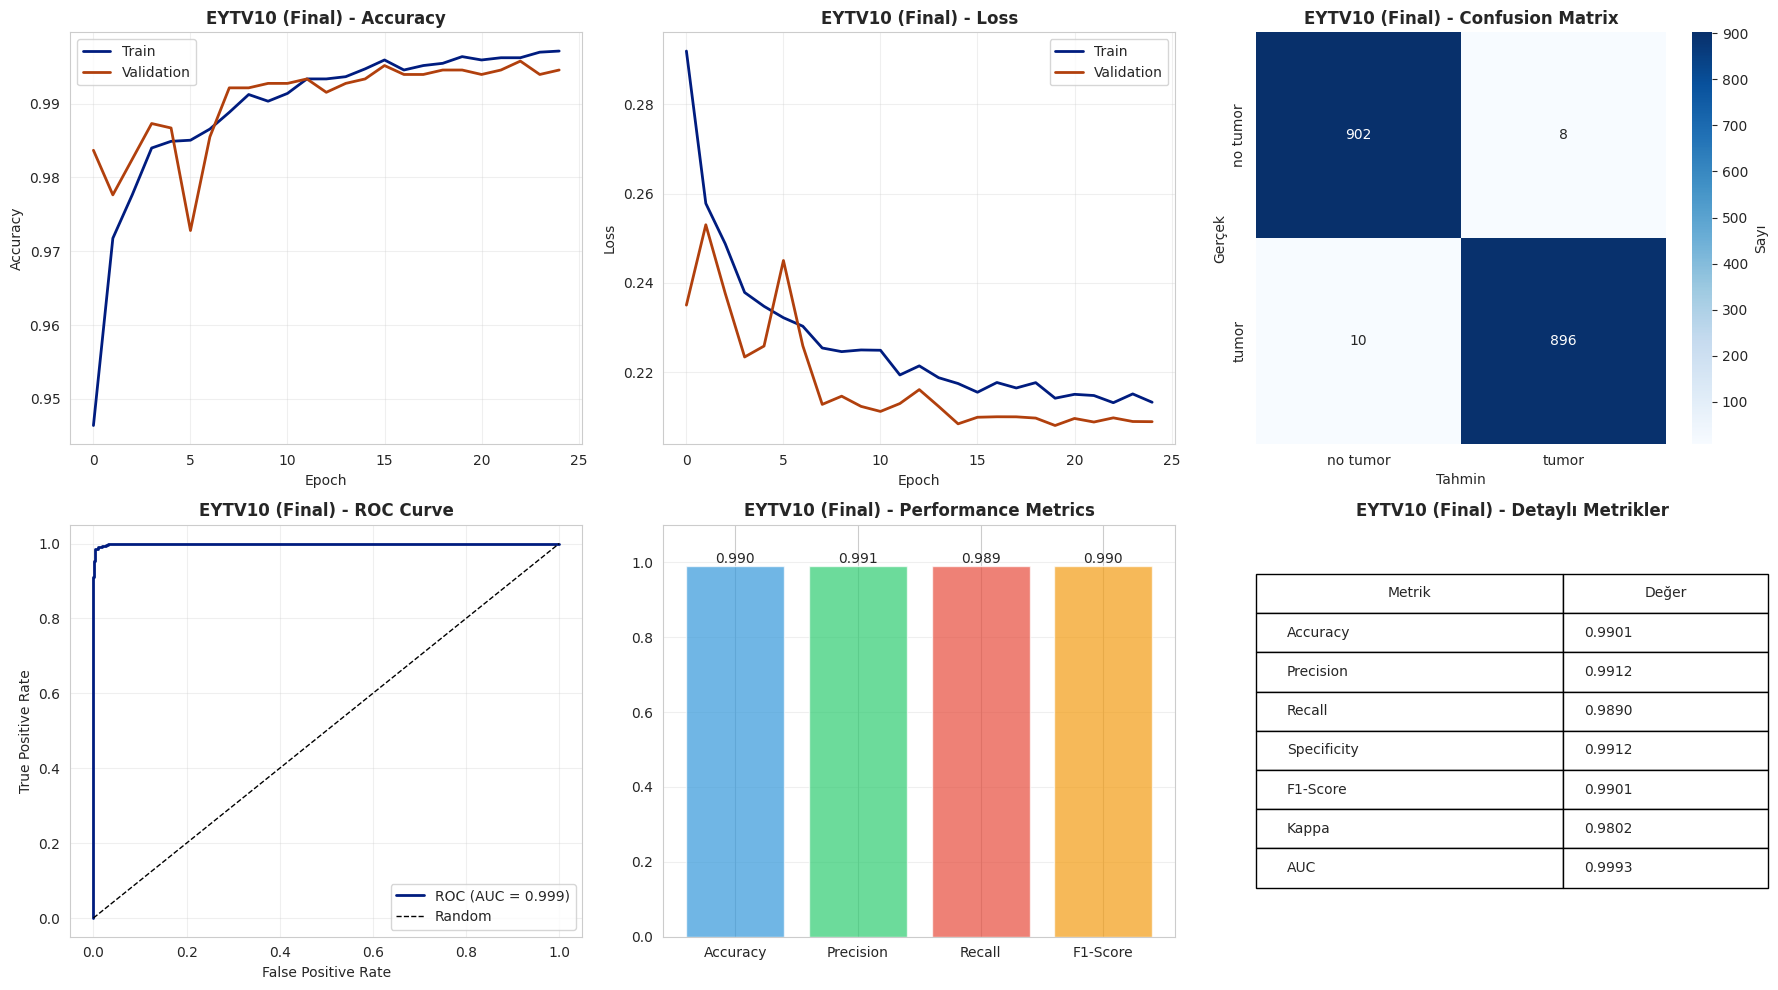

In [28]:
# ==================== MODEL 12: METRİK HESAPLAMA (EYTV10 - TTA) ====================
print("EYTV10 (Progressive + Smoothing) modeli TTA ile değerlendiriliyor...")

# Test verisi için generator'ı manuel oluştur
# (Çünkü get_progressive_dataset train/val döndürüyor, test için shuffle=False olmalı)
test_ds_final = tf.keras.utils.image_dataset_from_directory(
    test_dir, seed=RANDOM_SEED, image_size=(224, 224), color_mode='grayscale',
    batch_size=None, class_names=['no tumor', 'tumor'], label_mode='binary', shuffle=False
)

# --- 1. Normalizasyon Fonksiyonu ve Pipeline ---
def apply_norm_final(image, label):
    norm_img = tf.numpy_function(func=norm_albumentations, inp=[image], Tout=tf.float32)
    norm_img.set_shape([224, 224, 1]) # Boyut sabit
    return norm_img, label

test_generator_final = test_ds_final.map(apply_norm_final, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

# --- 2. TTA (Test Time Augmentation) Hazırlığı ---

# <--- EKLENEN KISIM: TTA Transform Tanımı --- >
# Bu tanım eksik olduğu için hata alıyordunuz.
tta_flip_transform = A.Compose([
    A.HorizontalFlip(p=1.0), # Her zaman çevir
    A.Normalize(mean=(0.0,), std=(1.0,), max_pixel_value=255.0),
])
# <--- EKLENEN KISIM SONU --- >

# TTA için Wrapper Fonksiyonlar
def aug_tta_flip_final(image):
    # Artık tta_flip_transform tanımlı olduğu için hata vermeyecek
    aug_image = tta_flip_transform(image=image)['image']
    return aug_image.astype(np.float32)

def apply_tta_flip_final(image, label):
    aug_img = tf.numpy_function(func=aug_tta_flip_final, inp=[image], Tout=tf.float32)
    aug_img.set_shape([224, 224, 1])
    return aug_img, label

# TTA (Flipped) Pipeline
test_generator_tta = test_ds_final.map(apply_tta_flip_final, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)


# --- 3. Tahmin ve Ortalama ---

print("Adım 1/2: Orijinal görüntüler tahmin ediliyor...")
y_pred_original = model_large.predict(test_generator_final, verbose=1)

print("Adım 2/2: Çevrilmiş (Flipped) görüntüler tahmin ediliyor...")
y_pred_flipped = model_large.predict(test_generator_tta, verbose=1)

# Olasılıkların Ortalamasını Al
y_pred_prob_10 = (y_pred_original + y_pred_flipped) / 2.0


# --- 4. Metrikler ve Görselleştirme ---

# Gerçek etiketleri çek
y_true_10 = np.concatenate([labels for images, labels in test_generator_final], axis=0)

# Metrikleri hesapla
custom_metrics_10, custom_cm_10, custom_roc_10 = calculate_metrics(
    y_true_10, y_pred_prob_10, 'EYTV10 (Prog.+Smooth.+TTA)'
)

# Süreyi ekle
custom_metrics_10['Avg. Epoch Time (s)'] = avg_epoch_time_10

# Sonuçları çizdir
plot_model_results(history_large, custom_metrics_10, custom_cm_10,
                   custom_roc_10, 'EYTV10 (Final)')

# Tabloya kaydet
all_model_metrics.append(custom_metrics_10)

### **TÜM MODELLERİN SONUÇLARINI KARŞILAŞTIRMA**

In [29]:
# ==================== TÜM MODELLERİN SONUÇLARINI KARŞILAŞTIRMA ====================
# (KOD, CSV'ye EKLEME YAPACAK VE EPOCH SÜRESİNİ GÖSTERECEK ŞEKİLDE GÜNCELLENDİ)

print("\n" + "=" * 80)
print("TÜM MODELLERİN PERFORMANS KARŞILAŞTIRMASI")
print("=" * 80)

# --- 1. CSV GÜNCELLEME (ÜZERİNE YAZMAYI ENGELLEME) ---

# Drive'daki CSV dosyasının tam yolunu belirle
# (DRIVE_SAVE_PATH değişkeninin 5. Hücrede tanımlandığını varsayıyoruz)
try:
    csv_save_path = os.path.join(DRIVE_SAVE_PATH, 'model_comparison_results.csv')

    # Mevcut CSV dosyasını (varsa) yükle
    if os.path.exists(csv_save_path):
        existing_df = pd.read_csv(csv_save_path, index_col='Model')
    else:
        existing_df = pd.DataFrame()

    # Bu çalışmadaki yeni metrikleri DataFrame'e dönüştür
    new_df = pd.DataFrame(all_model_metrics)
    if not new_df.empty:
        new_df.set_index('Model', inplace=True)

    # Eski ve yeni verileri birleştir
    # (Eski verilerin üzerine yenilerini yazar, böylece duplike olmaz)
    combined_df = pd.concat([existing_df, new_df])

    # Model adına göre duplikeleri kaldır, en sonuncuyu tut
    results_df = combined_df[~combined_df.index.duplicated(keep='last')]

    # Birleştirilmiş tam listeyi CSV'ye kaydet
    results_df.to_csv(csv_save_path)
    print(f"Başarılı: Karşılaştırma tablosu güncellendi ve şuraya kaydedildi: {csv_save_path}")

except Exception as e:
    print(f"CSV Kaydetme Hatası: {e}")
    print("Veri, geçici DataFrame'den okunacak.")
    results_df = pd.DataFrame(all_model_metrics).set_index('Model')


# --- 2. GÖRÜNTÜLEME TABLOSUNU GÜNCELLEME (EPOCH SÜRESİ EKLEME) ---

# Göstermek istediğimiz tüm sütunlar
all_columns = ['Precision', 'Recall (Sensitivity)', 'F1-Score', 'Accuracy', 'Avg. Epoch Time (s)']

# CSV'den yüklenen DataFrame'de bu sütunlardan hangileri varsa onları seç
display_columns = [col for col in all_columns if col in results_df.columns]
display_df = results_df[display_columns].copy()

# 'Recall (Sensitivity)' adını 'Recall' olarak kısalt
if 'Recall (Sensitivity)' in display_df.columns:
    display_df.rename(columns={'Recall (Sensitivity)': 'Recall'}, inplace=True)

# Yüzde formatlaması (sadece metrikler için, süre hariç)
metric_cols = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
for col in metric_cols:
    if col in display_df.columns:
        display_df[col] = display_df[col].apply(lambda x: f"{x*100:.2f}%")

# Süre formatlaması (virgülden sonra 2 basamak)
if 'Avg. Epoch Time (s)' in display_df.columns:
    display_df['Avg. Epoch Time (s)'] = display_df['Avg. Epoch Time (s)'].apply(lambda x: f"{x:.2f} s")


print("\nTüm Modellerin Karşılaştırmalı Sonuçları:")
print(display_df)


TÜM MODELLERİN PERFORMANS KARŞILAŞTIRMASI
Başarılı: Karşılaştırma tablosu güncellendi ve şuraya kaydedildi: /content/drive/MyDrive/saved_models/model_comparison_results.csv

Tüm Modellerin Karşılaştırmalı Sonuçları:
                              Precision  Recall F1-Score Accuracy  \
Model                                                               
Hybrid_MobileNet_ResNet          99.34%  99.89%   99.61%   99.61%   
Hybrid_DenseNet_Xception         99.23%  99.89%   99.56%   99.56%   
Hybrid_VGG16_EfficientNet        99.67%  99.56%   99.61%   99.61%   
Hybrid_Inception_EfficientNet    99.56%  99.56%   99.56%   99.56%   
EYTV1                            99.53%  93.05%   96.18%   96.31%   
EYTV2                            98.55%  97.46%   98.00%   98.02%   
EYTV3                            99.11%  98.34%   98.73%   98.73%   
EYTV4 (TTA)                      98.75%  96.14%   97.43%   97.47%   
EYTV5                            98.68%  98.90%   98.79%   98.79%   
EYTV6                   